In [73]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Input, MultiHeadAttention, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling1D, Add, Layer

# Configuración de parámetros
img_size = (224, 224)
patch_size = 16
num_patches = (img_size[0] // patch_size) ** 2
embed_dim = 64  # Dimensión del embedding
num_heads = 4  # Cabezas en MultiHeadAttention
num_classes = 3  # Número de clases
batch_size = 32
epochs = 50
learning_rate = 1e-4
mlp_dim = 128  # Dimensión del MLP en el bloque transformer
num_transformer_blocks = 8

# Función para dividir la imagen en patches
class PatchExtractor(Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtractor, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        return patches

# Función para construir un bloque Transformer
def transformer_block(x, num_heads, mlp_dim, dropout_rate=0.1):
    # Multi-Head Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = Add()([x, attn_output])  # Residual Connection
    out1 = LayerNormalization()(out1)

    # Feed-forward network
    ffn = Dense(mlp_dim, activation="relu")(out1)
    ffn = Dense(embed_dim)(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    out2 = Add()([out1, ffn])  # Residual Connection
    out2 = LayerNormalization()(out2)
    return out2

# Construcción del modelo ViT
def build_vit(input_shape, num_patches, embed_dim, num_heads, mlp_dim, num_classes, num_transformer_blocks):
    inputs = Input(shape=input_shape)

    # Extraer patches
    patches = PatchExtractor(patch_size=patch_size)(inputs)

    # Embedding de patches
    patch_embed = Dense(embed_dim)(patches)

    # Agregar embeddings de posición
    positions = Embedding(input_dim=num_patches, output_dim=embed_dim)(tf.range(start=0, limit=num_patches, delta=1))
    x = patch_embed + positions

    # Aplicar bloques Transformer
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, num_heads, mlp_dim)

    # Clasificación
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

# Crear el modelo ViT
vit_model = build_vit(
    input_shape=(img_size[0], img_size[1], 3),
    num_patches=num_patches,
    embed_dim=embed_dim,
    num_heads=num_heads,
    mlp_dim=mlp_dim,
    num_classes=num_classes,
    num_transformer_blocks=num_transformer_blocks,
)

# Compilar el modelo
vit_model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Configuración del generador de datos
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = 'D:/UPN/Capstone/Modelos/Dataset/train'
val_dir = 'D:/UPN/Capstone/Modelos/Dataset/valid'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Entrenar el modelo
history = vit_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs
)

# Guardar el modelo
vit_model.save('D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_vit_v6.keras',save_format='keras')


Found 2724 images belonging to 3 classes.
Found 289 images belonging to 3 classes.
Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.3884 - loss: 1.3117 - val_accuracy: 0.4583 - val_loss: 1.0626
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4375 - loss: 1.0744 - val_accuracy: 0.0000e+00 - val_loss: 1.5310
Epoch 3/50


C:\Users\yeiko\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 712ms/step - accuracy: 0.4704 - loss: 1.0637 - val_accuracy: 0.5590 - val_loss: 0.8973
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step - accuracy: 0.4062 - loss: 1.0041 - val_accuracy: 0.0000e+00 - val_loss: 1.5459
Epoch 5/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 710ms/step - accuracy: 0.5326 - loss: 0.9603 - val_accuracy: 0.6597 - val_loss: 0.7624
Epoch 6/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.5625 - loss: 1.0206 - val_accuracy: 1.0000 - val_loss: 0.3456
Epoch 7/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 66s 731ms/step - accuracy: 0.5836 - loss: 0.8987 - val_accuracy: 0.6910 - val_loss: 0.7256
Epoch 8/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - accuracy: 0.5625 - loss: 0.8864 - val_accuracy: 1.0000 - val_loss: 0.2622
Epoch 9/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 714ms/step - accuracy: 0.6210 - loss: 0.8382 - val_accuracy: 0.7118 - val_loss: 0.6700
Epoch 10/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step - accuracy: 0.5938 - loss: 0.6974 - val_accuracy: 1.00

In [72]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Definición de la capa personalizada PatchExtractor
class PatchExtractor(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtractor, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        return patches

# Ruta del modelo guardado
model_path = 'D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_vit_v4.keras'

# Cargar el modelo
vit_model = load_model(model_path, custom_objects={'PatchExtractor': PatchExtractor})
print("Modelo cargado exitosamente.")

# Recompilar el modelo
vit_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Modelo recompilado.")

# Configuración del generador de datos para entrenamiento y validación
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_dir = 'D:/UPN/Capstone/Modelos/Dataset/train'
val_dir = 'D:/UPN/Capstone/Modelos/Dataset/valid'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Reentrenar el modelo y mostrar las métricas durante cada época
history = vit_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10,  # Ajusta el número de épocas según lo que necesites
    verbose=1  # Esto asegura que se muestren las métricas (pérdida y precisión) durante cada época
)

# Guardar el modelo reentrenado
vit_model.save('D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_vit_v6.keras', save_format='keras')
print("Modelo reentrenado y guardado exitosamente.")



TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_3', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_1'}, 'registered_name': None, 'name': 'input_layer_1', 'inbound_nodes': []}, {'module': None, 'class_name': 'PatchExtractor', 'config': {'name': 'patch_extractor_1', 'trainable': True, 'dtype': 'float32', 'patch_size': 16}, 'registered_name': 'CustomLayers>PatchExtractor', 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'patch_extractor_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 3], 'dtype': 'float32', 'keras_history': ['input_layer_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_18', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, None, 768]}, 'name': 'dense_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, None, 768], 'dtype': 'float32', 'keras_history': ['patch_extractor_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_17'}, 'registered_name': 'Add', 'name': 'add_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, None, 64], 'dtype': 'float32', 'keras_history': ['dense_18', 0, 0]}}, {'class_name': '__tensor__', 'config': {'value': [[0.0197875015437603, -0.03149845451116562, -0.009742189198732376, 0.004924990236759186, 0.04921514913439751, 0.03164166584610939, -0.0015392303466796875, -0.029346276074647903, 0.03912252560257912, -0.009885095059871674, 0.038663242012262344, -0.002889968454837799, 0.04832277074456215, 0.004382573068141937, 0.03843981400132179, -0.014232002198696136, -0.026079177856445312, -0.03268309682607651, 0.04308540001511574, -0.0061453357338905334, -0.034431397914886475, 0.02934812381863594, -0.0075339674949646, -0.001970253884792328, 0.022130105644464493, 0.04744812473654747, -0.04375817999243736, 0.03307691588997841, -0.03609186410903931, -0.010048747062683105, 0.025707092136144638, 0.019038725644350052, -0.028341352939605713, -0.04273378849029541, 0.004940677434206009, 0.020208898931741714, 0.040045980364084244, -0.014051415026187897, -0.0023143403232097626, 0.04370596632361412, 0.009218193590641022, 0.021706853061914444, -0.023459626361727715, 0.02099766954779625, 0.03448648378252983, -0.021589983254671097, 0.019308891147375107, -0.0044615864753723145, 0.03050723299384117, -0.008493460714817047, -0.021492183208465576, -0.04700503498315811, -0.02375861443579197, -0.01987403631210327, 0.018392767757177353, 0.0036127083003520966, -0.016168545931577682, -0.019548822194337845, 0.009706210345029831, 0.04037651792168617, -0.026025056838989258, -0.016776729375123978, 0.02357551082968712, -0.046570491045713425], [-0.02129758708178997, -0.00625929981470108, -0.021338237449526787, 0.03233363851904869, -0.04429911449551582, 0.04860520735383034, -0.013590585440397263, -0.006540011614561081, 0.03100091591477394, 0.030282605439424515, 0.015081886202096939, -0.03854074329137802, -0.04434845596551895, -0.012320447713136673, -0.03244065120816231, -0.023095155134797096, -0.006524346768856049, 0.03389110788702965, 0.03595660999417305, 0.044879090040922165, -0.04446971416473389, -0.013627134263515472, 0.0013433098793029785, 0.015809226781129837, -0.012525845319032669, -0.016842223703861237, -0.0006063692271709442, 0.03432265296578407, 0.03597408905625343, -0.026448488235473633, -0.040269266813993454, 0.007057737559080124, 0.04221517965197563, 0.022339414805173874, -0.016547750681638718, -0.046637095510959625, -0.049555253237485886, -0.0499088279902935, -0.02299962006509304, 0.04053342714905739, -0.0023860223591327667, 0.038454923778772354, 0.025813329964876175, -0.01380382850766182, 0.026261840015649796, -0.025916267186403275, -0.02814934216439724, -0.0337606817483902, -0.024993527680635452, 0.005494214594364166, -0.00026689842343330383, -0.03469977527856827, 0.02248677983880043, 0.002104520797729492, 0.04261672869324684, 0.0009626857936382294, -0.01873648166656494, 0.042211566120386124, -0.0407007560133934, -0.014535747468471527, -0.011341344565153122, 0.02298698201775551, 0.028227154165506363, 0.040949705988168716], [0.030402008444070816, 0.048093054443597794, -0.018097184598445892, -0.04321351274847984, 0.008882343769073486, -0.03729637712240219, -0.02628093957901001, -0.013425968587398529, 0.04150604084134102, 0.04097333922982216, -0.01956266164779663, -0.021236587315797806, 0.014231298118829727, 0.03129695728421211, -0.039210449904203415, -0.008235812187194824, -0.03262375667691231, -0.04996132850646973, -0.016836117953062057, 0.008349455893039703, -0.04341071844100952, -0.0022500865161418915, -0.008098877966403961, -0.027220869436860085, 0.0236525796353817, -0.005913175642490387, -0.013656269758939743, -0.013073861598968506, -0.04016359895467758, -0.009340249001979828, -0.01642923429608345, -0.02418353594839573, 0.04297368600964546, -0.025030434131622314, 0.04570109769701958, -0.02367253415286541, -0.04252829775214195, -0.01395963504910469, -0.02229243516921997, -0.04675910621881485, 0.04922376945614815, 4.633516073226929e-05, -0.04173848778009415, -0.00627594068646431, 0.014309871941804886, 0.03683025762438774, 0.024749670177698135, 0.028777863830327988, -0.030723607167601585, 0.021769512444734573, -0.013879679143428802, -0.04868743568658829, -0.022266972810029984, 0.034373532980680466, 0.04915889725089073, -0.02684863843023777, 0.010462582111358643, -0.010648034512996674, 0.015900541096925735, -0.02626427449285984, 0.04464597627520561, 0.03470398113131523, -0.021413112059235573, 0.008646287024021149], [0.03864574804902077, -0.0003047958016395569, 0.019122231751680374, -0.006289876997470856, 0.03852328285574913, -0.035615526139736176, 0.034442152827978134, -0.01143956184387207, 0.0019229874014854431, 0.0466122142970562, -0.03177608549594879, 0.04592542722821236, 0.032809529453516006, 0.023509230464696884, -0.039559781551361084, -0.02319265715777874, 0.01961411163210869, -0.015342522412538528, 0.010299243032932281, 0.04573268070816994, -0.0004760250449180603, -0.003285743296146393, 0.04003881290555, 0.03355543687939644, -0.03973802179098129, 0.024945523589849472, 0.023136567324399948, 0.006041515618562698, 0.002737961709499359, 0.033782150596380234, -0.004743684083223343, 0.02304976060986519, -0.038703322410583496, -0.01709514856338501, -0.034208644181489944, -0.028386462479829788, -0.015776097774505615, -0.027048205956816673, -0.025571061298251152, -0.0329112783074379, 0.03474379703402519, 0.028585005551576614, 0.04862317815423012, 0.01082080602645874, 0.03258949890732765, 0.023717571049928665, -0.00754319503903389, 0.03194573149085045, 0.015729699283838272, 0.0148165263235569, 0.0376029871404171, 0.037762079387903214, 0.010699879378080368, 0.01665448024868965, -0.04884418472647667, -0.01135331392288208, 0.0005645155906677246, 0.02244647964835167, 0.011346079409122467, -0.009155355393886566, -0.04190944507718086, -0.040653906762599945, -0.022698331624269485, -0.03785077482461929], [-0.003965485841035843, -0.040691278874874115, 0.025057677179574966, -0.0043148621916770935, -0.0019261352717876434, 0.04318287596106529, -0.009387455880641937, -5.0045549869537354e-05, 0.041286174207925797, -0.014450229704380035, -0.014339577406644821, 0.0192108191549778, -0.005375780165195465, -0.04576616361737251, -0.03872460126876831, -0.020830893889069557, -0.011003803461790085, 0.02644674852490425, -0.015455164015293121, -0.03644517809152603, 0.009166635572910309, -0.039908409118652344, -0.019212806597352028, 0.030775774270296097, 0.0220625139772892, 0.02456596866250038, -0.044172611087560654, -0.048170268535614014, -0.04625668749213219, -0.022139668464660645, 0.026768911629915237, 0.04709387943148613, -0.047305166721343994, 0.011495757848024368, 0.035602424293756485, 0.016462650150060654, 0.041073884814977646, -0.016212403774261475, -0.009272299706935883, -0.040055952966213226, 0.026520181447267532, -0.0009279251098632812, 0.014934364706277847, 0.01110536977648735, -0.044844355434179306, -0.022494221106171608, 0.01065291091799736, 0.045142438262701035, -0.01876016892492771, -0.015575777739286423, 0.044671740382909775, 0.007271982729434967, 0.005784057080745697, -0.04264331981539726, 0.04921877756714821, -0.010532379150390625, 0.04899771139025688, 0.04252130910754204, -0.028386974707245827, 0.013753484934568405, -0.04228353500366211, -0.018987834453582764, 0.0017144456505775452, 0.0255858413875103], [0.036505091935396194, 0.03706009313464165, 0.014494452625513077, 0.029166702181100845, 0.04612419381737709, -0.04695305973291397, 0.0032325871288776398, -0.044391464442014694, -0.010464288294315338, -0.025124669075012207, -0.009492479264736176, -0.019326234236359596, -0.015558421611785889, -0.01734834909439087, -0.04959550127387047, 0.021917674690485, -0.0038780346512794495, 0.027147378772497177, -0.03320816904306412, 0.030675258487462997, -0.02247610129415989, 0.017585109919309616, -7.06203281879425e-05, 0.033118296414613724, 0.0409957654774189, -0.0005883462727069855, 0.04027867689728737, 0.014037560671567917, 0.023340914398431778, 0.04396790638566017, -0.028630364686250687, 0.02368743345141411, 0.006126381456851959, -0.0376928448677063, 0.030729103833436966, -0.011118710041046143, -0.041778672486543655, 0.016831044107675552, 0.028336714953184128, -0.02341303788125515, 0.011883318424224854, -0.026021266356110573, -0.03563312441110611, -0.015920735895633698, 0.024982202798128128, -0.009566009044647217, 0.001047872006893158, -0.02357003651559353, 0.028118159621953964, 0.016956936568021774, -0.004118345677852631, -0.010251499712467194, -0.019645297899842262, -0.0012312904000282288, -0.0031016841530799866, -0.040920842438936234, -0.01058938354253769, -0.018818700686097145, -0.031063437461853027, 0.030660022050142288, -0.020413566380739212, 0.04248249903321266, 0.03286483511328697, -0.046867694705724716], [0.04354536905884743, -0.0017994046211242676, 0.048820268362760544, -0.04285633563995361, -0.04242066293954849, -0.012228690087795258, 0.03892851248383522, -0.011356055736541748, -0.0365249402821064, 0.048071909695863724, -0.03578171879053116, 0.0486089326441288, -0.042815208435058594, 0.047362279146909714, -0.0035943984985351562, 0.01675640419125557, -0.021234704181551933, 0.006573963910341263, -0.010455630719661713, 0.02982502058148384, 0.02451859787106514, 0.0152556411921978, -0.03827408701181412, -0.045653510838747025, 0.022964630275964737, -0.03838383033871651, 0.019629087299108505, 0.0420062281191349, 0.023898068815469742, 0.04592433199286461, -0.013646721839904785, -0.027928246185183525, -0.007633127272129059, 0.03284107521176338, 0.032316554337739944, -0.033639490604400635, -0.039505768567323685, 0.03134242072701454, 0.008216451853513718, -0.048643387854099274, 0.0118928924202919, 0.00982804223895073, 0.04206700250506401, -0.03176547586917877, 0.01819727197289467, 0.0035354122519493103, 0.002011369913816452, -0.04325491189956665, -0.024240171536803246, -0.02422383986413479, -0.03275611251592636, 0.003942273557186127, -0.03543907403945923, 0.01413000002503395, -0.04980062320828438, -0.03993410989642143, 0.023326326161623, -0.03838115930557251, 0.01766195520758629, 0.0017783865332603455, 0.04806233569979668, 0.024896036833524704, -0.042519330978393555, 0.04816972091794014], [-0.00875185802578926, -0.0016230568289756775, -0.04864471033215523, -0.008435942232608795, -0.033742524683475494, -0.032037604600191116, 0.03628223016858101, 0.007939435541629791, -0.023158550262451172, -0.0019152387976646423, 0.04172452911734581, 0.005088351666927338, 0.004274547100067139, 0.0074727535247802734, 0.031591106206178665, 0.019977357238531113, 0.02497478947043419, 0.04796941205859184, -0.02398153580725193, 0.02592362090945244, -0.03661562129855156, -0.0279585849493742, 0.022228170186281204, -0.02856849506497383, -0.04701732471585274, -0.024201571941375732, 0.0072116367518901825, 0.011880826205015182, 0.006086181849241257, -0.03232838958501816, 0.010222803801298141, -0.018538903445005417, -0.03663300350308418, -0.044024791568517685, -0.04844396188855171, -0.03582551330327988, 0.010048650205135345, -0.04476860910654068, -0.0190238356590271, 0.04693133011460304, -0.04949970170855522, 0.04842624440789223, -0.04571507126092911, 0.04097327962517738, 0.0008121952414512634, -0.027719318866729736, -0.038105450570583344, -0.0066343434154987335, -0.044594716280698776, 0.017697978764772415, 0.039805855602025986, 0.03624257817864418, 0.02429093047976494, -0.012894868850708008, -0.014547765254974365, 0.0361449234187603, -0.009801268577575684, -0.022496676072478294, -0.04275095462799072, -0.0009113326668739319, 0.029684636741876602, 0.01354542002081871, -0.01859975978732109, -0.009820975363254547], [0.01066659763455391, -0.005991481244564056, -0.04126448556780815, -0.0062555670738220215, 0.01261376217007637, 0.006512533873319626, 0.006293453276157379, -0.030189478769898415, 0.04162866994738579, -0.023030806332826614, -0.0335954912006855, 0.010548006743192673, 0.0423084981739521, 0.04433736577630043, 0.006336379796266556, 0.01268831267952919, 0.049269046634435654, 0.04802210256457329, -0.048963773995637894, 0.010966669768095016, -0.048883069306612015, 0.00870051234960556, 0.001753292977809906, 0.04308220371603966, 0.007783472537994385, 0.019168484956026077, 0.03246878460049629, 0.0027997978031635284, 0.029905352741479874, 0.027240250259637833, -0.003706742078065872, -0.0018645897507667542, -0.01699979230761528, -0.023023296147584915, -0.04140068218111992, 0.0008992068469524384, -0.014929495751857758, 0.024724852293729782, -0.01393667608499527, -0.03552405908703804, 0.03430846706032753, -0.02080134116113186, 0.04609960690140724, -0.039420463144779205, 0.021780919283628464, 0.04604201391339302, -0.0019072778522968292, 0.01653337851166725, 0.01925727352499962, -0.019133830443024635, 0.005599401891231537, -0.018984878435730934, -0.014161504805088043, 0.014697615057229996, 0.008589744567871094, -0.014416851103305817, 0.012292195111513138, 0.03109237179160118, -0.033045172691345215, 0.03066134825348854, 0.0020503997802734375, -0.019554663449525833, 0.003568112850189209, -0.04113809019327164], [-0.019495904445648193, 0.048181746155023575, 0.043336186558008194, -0.006173361092805862, -0.022008538246154785, 0.007385812699794769, -0.044119786471128464, -0.017940163612365723, 0.025255177170038223, -0.04555917903780937, 0.04520902410149574, -0.01423640176653862, 0.02690136805176735, -0.0023999810218811035, -0.005401097238063812, -0.03060131147503853, -0.027042508125305176, -0.04978678375482559, 0.012406133115291595, -0.0019654743373394012, -0.04253247007727623, 0.030546952039003372, -0.008913479745388031, -0.04852950572967529, -0.0037479177117347717, 0.04086865112185478, -0.002768494188785553, -0.008403647691011429, -0.02456566132605076, 0.03415778651833534, -0.0015601031482219696, -0.005256034433841705, 0.005073715001344681, 0.04418492689728737, 0.008784197270870209, 0.027444910258054733, 0.03773423656821251, 0.0493285097181797, 0.03648194298148155, -0.045277297496795654, 0.013326335698366165, 0.04626145586371422, 0.019400600343942642, 0.006278883665800095, -0.04914236068725586, 0.0284210704267025, 0.04884176328778267, 0.00816727802157402, -0.034385133534669876, 0.015945997089147568, -0.012637566775083542, 0.01666593924164772, 0.011355053633451462, 0.025800835341215134, 0.018393922597169876, 0.002804625779390335, -0.01058046892285347, 0.04492593929171562, 0.009716678410768509, -0.03890518099069595, 0.025231745094060898, -0.018577884882688522, -0.032823577523231506, -0.03201136738061905], [0.012735117226839066, -0.009379029273986816, -0.03575768321752548, -0.02701113186776638, 0.02543509379029274, 0.026046965271234512, -0.012004218995571136, 0.04213153198361397, -0.008055496960878372, 0.04785480722784996, -0.020065879449248314, -0.016759347170591354, 0.031034354120492935, -0.007660221308469772, 0.0341329462826252, -0.046335410326719284, -0.007934249937534332, -0.01693497970700264, -0.010630391538143158, -0.0016845352947711945, 0.0306415893137455, 0.04330296441912651, -0.018555857241153717, -0.029625236988067627, -0.03216532617807388, -0.028984272852540016, -0.01115427166223526, -0.004319358617067337, -0.025600267574191093, -0.04127931594848633, -0.005974769592285156, 0.02143676206469536, 0.044709328562021255, 0.042545367032289505, -0.0353030189871788, 0.011494122445583344, 0.02764168754220009, 0.005385447293519974, 0.008444607257843018, 0.016950223594903946, 0.04289412871003151, 0.007051229476928711, -0.023612892255187035, -0.0288520697504282, 0.0032570958137512207, 0.02870718017220497, -0.042372848838567734, -0.04652352258563042, -0.034733034670352936, 0.008462809026241302, -0.0054323188960552216, -0.03543911129236221, 0.015930797904729843, -0.0365060456097126, -0.007924579083919525, -0.0074388980865478516, -0.023776376619935036, -0.0387408509850502, 0.00849226862192154, -0.007010173052549362, -0.00494847446680069, -0.011822808533906937, -0.024987125769257545, 0.004407249391078949], [-0.0417952761054039, 0.03784291818737984, 0.04309213533997536, -0.04524574428796768, 0.004934679716825485, 0.0021414048969745636, -0.044078029692173004, -0.047400761395692825, 0.01201341301202774, -0.030382156372070312, 0.026959966868162155, 0.024693284183740616, -0.011967815458774567, -0.0008604899048805237, 0.03926331177353859, -0.02635866403579712, 0.03405442461371422, 0.0058501362800598145, 0.03180024400353432, -0.006000183522701263, -0.0008275993168354034, -0.031155873090028763, 0.0007051117718219757, 0.026672493666410446, -0.014990843832492828, -0.04729042202234268, -0.0455334298312664, -0.04730251058936119, 0.0336325503885746, 0.04700043424963951, 0.047026488929986954, -0.03722729533910751, 0.012624088674783707, -0.024674762040376663, 0.010907329618930817, 0.029886972159147263, 0.0013558492064476013, -0.038030851632356644, -0.04589482769370079, 0.011647868901491165, -0.0320453867316246, -0.03174901008605957, -0.011079777032136917, -0.015315927565097809, -0.0005037412047386169, 0.0017427578568458557, -0.007334135472774506, -0.03920309618115425, 0.008599616587162018, 0.03488143905997276, -0.0014960989356040955, -0.04850851371884346, -0.02495451085269451, -0.03896738216280937, -0.024404872208833694, -0.04646318033337593, 0.024022530764341354, 0.04813985899090767, 0.01843775436282158, 0.01954803243279457, 0.029324684292078018, 0.04144385829567909, -0.02820793353021145, 0.039311181753873825], [0.00016435235738754272, 0.02990807220339775, -0.04968148469924927, -0.039435744285583496, 0.04425079748034477, 0.04578355327248573, -0.0026165470480918884, -0.003944087773561478, -0.022127067670226097, 0.04114096239209175, -0.004657518118619919, 0.014287326484918594, -0.048906899988651276, 0.009937930852174759, 0.04005679860711098, 0.04748309776186943, -0.04740344360470772, 0.029224585741758347, 0.03928518667817116, 0.03894620016217232, -0.0025226250290870667, 0.0172518752515316, -0.0312652587890625, 0.009159494191408157, -0.036552656441926956, -0.0039016976952552795, -0.013452459126710892, 0.04545417055487633, -0.028406059369444847, 0.040312398225069046, 0.047810766845941544, -0.028745317831635475, 0.02343270555138588, 0.00020625442266464233, 0.04918171092867851, -0.009554050862789154, 0.029432285577058792, -0.01220414787530899, 0.028701256960630417, 0.04091823473572731, 0.014720309525728226, -0.03323831409215927, -0.039586327970027924, 0.019146669656038284, 0.004174042493104935, 0.03417450562119484, -0.014278899878263474, -0.007330764085054398, -0.020341718569397926, 0.03927943482995033, -0.034797511994838715, 0.03753688558936119, 0.02752845361828804, 0.04275641217827797, 0.030012797564268112, -0.047159384936094284, 0.04281940683722496, -0.00781933218240738, 0.029172394424676895, -0.03313126415014267, -0.03022986650466919, 0.04200753942131996, -0.00325775146484375, 0.027781393378973007], [-0.031181348487734795, 0.02441457286477089, 0.04163244739174843, -0.020418763160705566, -0.010956216603517532, 0.04938565567135811, -0.03214353322982788, -0.017456412315368652, 0.03925025835633278, 0.0031500346958637238, -0.048612989485263824, 0.022775713354349136, 0.013738919049501419, -0.0030453912913799286, 0.022053610533475876, -0.04373660311102867, 0.011103890836238861, -0.022127224132418633, -0.01485375314950943, 0.02721572294831276, 2.384185791015625e-07, 0.004378568381071091, -0.014581523835659027, 0.0040170177817344666, -0.02220473252236843, -0.021796906366944313, -0.030427170917391777, 0.018193770200014114, 0.04567675665020943, 0.0479586161673069, 0.046353068202733994, -0.022842729464173317, 0.012261711061000824, -0.028272176161408424, -0.04412425681948662, -0.04688005521893501, -0.025110138580203056, 0.045134153217077255, -0.04194091632962227, -0.010983072221279144, 0.048822853714227676, 0.04463029280304909, 0.026575598865747452, -0.00677795335650444, -0.0033448822796344757, 0.04119454696774483, 0.046142783015966415, 0.025716710835695267, -0.01859229803085327, -0.03421194851398468, 0.020195674151182175, 0.038981858640909195, 0.02199268713593483, 0.020069193094968796, 0.01734623685479164, 0.025504279881715775, 0.036591317504644394, -0.04847853258252144, -0.03992597013711929, -0.012087594717741013, -0.023921478539705276, 0.039879921823740005, -0.025572145357728004, 0.004875026643276215], [0.04705670103430748, 0.00109182670712471, 0.03338891640305519, -0.047883011400699615, 0.010033391416072845, -0.0430418960750103, 0.03178069368004799, 0.042931485921144485, -0.014785755425691605, 0.01882164552807808, -0.025559520348906517, -0.011773515492677689, 0.04440121725201607, 0.039683569222688675, -0.031289614737033844, -0.02860574796795845, 0.006447147578001022, -0.02020815573632717, 0.0009591951966285706, 0.018649887293577194, -0.033233001828193665, 0.023072686046361923, 0.033172573894262314, -0.014930926263332367, 0.02180696651339531, -0.03296850994229317, 0.037918318063020706, 0.020702514797449112, -0.04648780822753906, 0.011259950697422028, 0.020649168640375137, -0.023623108863830566, 0.03944411501288414, 0.03007979318499565, -0.01856142282485962, -0.002965688705444336, 0.001171708106994629, 0.0003215298056602478, -0.017638802528381348, 0.0075356364250183105, 0.026453863829374313, 0.008330464363098145, 0.0031903013586997986, 0.02819598838686943, 0.006518721580505371, 0.013029646128416061, 0.02403339371085167, 0.044018518179655075, 0.009840108454227448, 0.03185266628861427, 0.02350081130862236, 0.020808186382055283, 0.0007213465869426727, -0.03820091485977173, -0.01817617565393448, -0.015402235090732574, 0.04503356292843819, 0.0064872391521930695, -0.01617532968521118, -0.041892409324645996, -0.023717904463410378, 0.046220991760492325, 0.010281514376401901, 0.047299157828092575], [0.03859758749604225, -0.0013571269810199738, 0.039941560477018356, 0.017007555812597275, 0.012114334851503372, 0.03194854035973549, -0.033432796597480774, 0.035444486886262894, 0.007460393011569977, 0.02653959020972252, 0.029171694070100784, -0.04215904325246811, -0.03875504806637764, 0.04069504514336586, -0.007921196520328522, 0.0013824217021465302, 0.03073349967598915, -0.012458205223083496, -0.015326358377933502, 0.02643701806664467, -0.03817765787243843, -0.045296262949705124, -0.0468815341591835, 0.03255082294344902, -0.043902792036533356, 0.013787757605314255, -0.039097629487514496, 0.029924962669610977, 0.009593762457370758, 0.03643609210848808, -0.036959148943424225, 0.015261303633451462, -0.0250779390335083, -0.01569434255361557, 0.005564142018556595, -0.03571737930178642, 0.04714265838265419, -0.04206021875143051, -0.014521218836307526, 0.029940877109766006, -0.035185109823942184, -0.0031657330691814423, 0.03255632892251015, 0.02987929806113243, -0.021141791716217995, 0.04740801826119423, -0.01208263635635376, -0.0006670728325843811, -0.02846320904791355, 0.041974034160375595, 0.006482362747192383, -0.028071332722902298, 0.009059466421604156, 0.011006344109773636, -0.022234976291656494, 0.04501110687851906, 0.006826639175415039, 0.011640537530183792, 0.04961485043168068, -0.04262042045593262, 0.03225076571106911, 0.018869373947381973, 0.011534593999385834, 0.022937152534723282], [0.0016015060245990753, -0.049417831003665924, 0.0477750338613987, 3.715604543685913e-05, 0.007361866533756256, 0.04347486421465874, -0.03881359100341797, 0.007307182997465134, -0.02297123707830906, 0.016482781618833542, -0.0015750303864479065, -0.010024569928646088, -0.02575361728668213, 0.005752228200435638, 0.008676160126924515, -0.019621361047029495, -0.03429839760065079, 0.038780998438596725, -0.008114408701658249, -0.005440283566713333, -0.016409657895565033, 0.026313934475183487, 0.014191631227731705, -0.04731089994311333, 0.042949143797159195, -0.04847891256213188, -0.03493490070104599, 0.011242128908634186, 0.007892061024904251, -0.015102267265319824, 0.030196715146303177, 0.009294401854276657, -0.03576159477233887, 0.020675014704465866, -0.029501736164093018, -0.006801150739192963, 0.031961534172296524, 0.0304395891726017, 0.022168587893247604, 0.01524290069937706, 0.026384245604276657, 0.006631791591644287, 0.03906247392296791, -0.03775808960199356, -0.04426347091794014, -0.010995268821716309, 0.030546318739652634, 0.009474001824855804, 0.008699238300323486, -0.005049169063568115, -0.03516256809234619, 0.03057238832116127, 0.012134335935115814, -0.023459458723664284, -0.006374586373567581, -0.029277538880705833, 0.009311117231845856, -0.0009615905582904816, -0.004904627799987793, 0.02547968551516533, 0.012454677373170853, -0.033942364156246185, 0.04183917120099068, 0.03972266986966133], [-0.003714919090270996, -0.013473998755216599, 0.009046625345945358, 0.04802588000893593, -0.027964044362306595, -0.035119105130434036, -0.03584016487002373, -0.011999797075986862, 0.035133372992277145, 0.03283185884356499, 0.0476064570248127, 0.031428012996912, 0.042062465101480484, -0.005270898342132568, -0.04353842884302139, 0.0011652223765850067, -0.009466756135225296, 0.03802025690674782, 0.02927779033780098, 0.03876710310578346, -0.03207132965326309, 0.011723708361387253, -0.0375664122402668, -0.011750172823667526, -0.03714551776647568, -0.03301919996738434, -0.02926873043179512, -0.042109180241823196, -0.045587074011564255, -0.039524782449007034, 0.04062609747052193, 0.04675689712166786, -0.032553255558013916, 0.04578665271401405, -0.046480488032102585, 0.0010740980505943298, -0.01960139349102974, -0.001005806028842926, -0.004795301705598831, 0.016954723745584488, -0.038677942007780075, -0.01847776025533676, 0.04591334983706474, -0.030567144975066185, 0.005058299750089645, -0.02417919598519802, 0.03940090909600258, -0.0056516751646995544, 0.011711716651916504, 0.0010324344038963318, -0.01624506711959839, -0.007720232009887695, -0.033998824656009674, -0.004805445671081543, 0.02408779039978981, -0.03871678188443184, 0.01283026859164238, -0.019751274958252907, -0.0008388273417949677, 0.04923984035849571, 0.0076882243156433105, 0.04786776378750801, -0.00011186674237251282, -0.03639636188745499], [-0.02546525001525879, -0.005705833435058594, -0.049745239317417145, -0.012676931917667389, 0.030785445123910904, -0.014780879020690918, -0.034164488315582275, -0.005297340452671051, -0.03447835519909859, -0.04525972530245781, -0.02664097584784031, 0.02157728746533394, 0.04359019175171852, -0.00913172960281372, -0.005094349384307861, -0.028288329020142555, -0.01008998230099678, -0.030537176877260208, -0.045162320137023926, -0.026144040748476982, 0.03321990743279457, 0.0036026611924171448, -0.021298397332429886, -0.0012706629931926727, -0.049360133707523346, 0.046099770814180374, -0.041432060301303864, -0.022532476112246513, 0.023135457187891006, -0.03321559727191925, 0.0052039846777915955, -0.014512073248624802, -0.02713843621313572, 0.03120577707886696, 0.013253439217805862, 0.010814905166625977, 0.021309364587068558, 0.042211879044771194, -0.026592468842864037, -0.03273589909076691, -0.025558186694979668, -0.016649506986141205, -0.035599399358034134, -0.020402265712618828, -0.003701724112033844, -0.014845598489046097, 0.020501483231782913, 0.013899397104978561, -0.011519085615873337, -0.0435916893184185, -0.01814497634768486, -0.023274565115571022, -0.028336990624666214, -0.004745353013277054, -0.009223461151123047, 0.03454040363430977, -0.007068894803524017, 0.024062704294919968, 0.022963259369134903, 0.007024955004453659, 0.011728715151548386, -0.040302276611328125, -0.04216587543487549, -0.010451219975948334], [0.04492228105664253, 0.016630027443170547, 0.004175029695034027, 0.012887809425592422, 0.004472650587558746, -0.009984374046325684, -0.0037678852677345276, 0.0320986844599247, -0.015148937702178955, 0.005773473531007767, 0.025296662002801895, -0.0478326678276062, 0.04904257133603096, -0.03562885522842407, -0.040301501750946045, 0.0060836076736450195, 0.023917410522699356, -0.025444496423006058, -0.0015149600803852081, 0.046711716800928116, -0.03751952573657036, -0.02054375410079956, -0.018551088869571686, -0.015333391726016998, -0.01823723316192627, -0.037219904363155365, 0.003984939306974411, 0.006102323532104492, 0.00586019828915596, 0.015810195356607437, -0.030440974980592728, 0.015809405595064163, -0.022215474396944046, 0.048463236540555954, -0.022436130791902542, 0.024865102022886276, -0.04473504051566124, -0.0010781511664390564, -0.009620942175388336, 0.027288805693387985, 0.03820070996880531, -0.026210879907011986, 0.031660523265600204, -0.03432184457778931, 0.021058369427919388, -0.038093339651823044, 0.012929487973451614, -0.001975022256374359, -0.028258228674530983, -0.009195171296596527, 0.0006683357059955597, -0.0273505337536335, -0.046191491186618805, 0.014311540871858597, 0.030464399605989456, 0.017589639872312546, 0.01785072311758995, 0.022626709192991257, -0.018521547317504883, 0.026270244270563126, 0.007092416286468506, 0.03262067213654518, 0.016192760318517685, -0.034020401537418365], [-0.03890136629343033, -0.021900033578276634, -0.03986790031194687, 0.04831191524863243, 0.028031613677740097, 0.024482477456331253, -0.0351598747074604, -0.012580431997776031, -0.037420712411403656, 0.025013517588377, -0.0018380992114543915, -0.029892897233366966, -0.03541594743728638, 0.024998996406793594, -0.04022948816418648, -0.01851654052734375, -0.02103647030889988, 0.020885828882455826, 0.007644236087799072, 0.031803715974092484, -0.02246072329580784, -0.031072497367858887, 0.02717754617333412, -0.007506240159273148, -0.02665896527469158, 0.04477269574999809, -0.034685004502534866, -0.02758082188665867, -0.04014214128255844, -0.025020146742463112, 0.0018434040248394012, 0.02548166736960411, -0.03667762130498886, -0.04709513112902641, 0.008616209030151367, 0.00019548088312149048, -0.01794414594769478, -0.0060034990310668945, -0.030983734875917435, -0.012093912810087204, 0.034840915352106094, 0.03869220241904259, -0.003093503415584564, -0.009195566177368164, 0.032046448439359665, -0.02918827533721924, -0.012718401849269867, -0.04625736549496651, 0.024853255599737167, -0.0026996731758117676, -0.003597557544708252, 0.008803833276033401, 0.03564227744936943, 0.005492806434631348, 0.014300171285867691, 0.007637392729520798, -0.03761642053723335, -0.018758499994874, 0.02533205971121788, 0.026176776736974716, 0.010754071176052094, -0.040018223226070404, 0.007125593721866608, 0.04721296206116676], [-0.03312412649393082, -0.001889348030090332, 0.013424243777990341, -0.04757082462310791, -0.0006516948342323303, 0.03577962890267372, 0.029851485043764114, -0.03602059930562973, 0.042961809784173965, -0.04245651885867119, 0.031185541301965714, -0.03671226650476456, 0.03974256291985512, -0.0013718381524085999, 0.0009211190044879913, 0.021068107336759567, -0.04237023741006851, 0.015948880463838577, -0.024324489757418633, -0.044395413249731064, 0.012574266642332077, -0.043758977204561234, -0.0030090920627117157, -0.01346980407834053, 0.015070866793394089, -0.0026974305510520935, -0.03013796918094158, 0.0070688724517822266, 0.00045614317059516907, 0.04667499288916588, 0.03888659551739693, 0.012693356722593307, 0.0420285202562809, -0.04214819520711899, -0.015522204339504242, 0.04837406054139137, -0.026375174522399902, 0.00014780834317207336, -0.008216392248868942, 0.02535795047879219, -0.0314972884953022, -0.041116975247859955, 0.005454659461975098, -0.008138321340084076, -0.03941911458969116, 0.015138674527406693, 0.04775210842490196, 0.022727932780981064, 0.037944745272397995, 0.035148825496435165, -0.0013195052742958069, 0.03137929365038872, -0.027618706226348877, 0.0016786232590675354, 0.04072657600045204, 0.003469657152891159, -0.007622193545103073, -0.01962963305413723, -0.006520330905914307, 0.016922343522310257, 0.009758412837982178, 0.03490114584565163, -0.039608001708984375, -0.0031335726380348206], [-0.0321890264749527, -0.004389844834804535, -0.041130997240543365, 0.03511209413409233, -0.025292634963989258, 0.021845903247594833, -0.008859753608703613, 0.023271862417459488, 0.029844511300325394, 0.01741781458258629, 0.03188116475939751, 0.043193671852350235, 0.0033648833632469177, -0.028766369447112083, -0.03966044262051582, -0.04993835836648941, 0.0043632760643959045, 0.019523095339536667, 0.03145022317767143, 0.03247426822781563, -0.022024894133210182, 0.027189861983060837, 0.04580685868859291, -0.0257103331387043, 0.015327844768762589, 0.04273183271288872, -0.0038741938769817352, -0.009604297578334808, 0.00627657026052475, 0.0033230558037757874, -0.03842341899871826, -0.031128395348787308, -0.049820054322481155, -0.021610630676150322, 0.013467278331518173, -0.04861791059374809, -0.04285048320889473, -0.0103989839553833, 0.030814457684755325, -0.04311605915427208, 0.010779298841953278, -0.042879533022642136, 0.03890426084399223, -0.013381361961364746, -0.027549266815185547, -0.03777151182293892, 0.03385975584387779, 0.00105295330286026, -0.018650926649570465, -0.019343186169862747, 0.026301030069589615, -0.000759374350309372, 0.047008905559778214, -0.018529068678617477, 0.017917219549417496, -0.003976296633481979, -0.035589613020420074, -0.010187126696109772, 0.03297306224703789, -0.015442945063114166, 0.012702178210020065, -0.027992499992251396, 0.03337777033448219, -0.015502046793699265], [-0.018510423600673676, -0.04861960560083389, -0.01578925922513008, -0.049829017370939255, -0.003760017454624176, 0.03272442892193794, 0.037721943110227585, -0.026813184842467308, -0.041912175714969635, -0.047185268253088, 0.008940555155277252, -0.023596514016389847, -0.04497629404067993, 0.03167736902832985, -0.02543860673904419, -0.03501143306493759, 0.03948167338967323, 0.014429640024900436, 0.04623117670416832, 0.02288733795285225, -0.01880025863647461, -0.023481225594878197, -0.018805360421538353, -0.019841313362121582, -0.0028633587062358856, 0.008369911462068558, 0.010317228734493256, 0.029088344424962997, -0.008463431149721146, -0.017604194581508636, -0.011443424969911575, -0.009800292551517487, 0.046469103544950485, 0.033493880182504654, -0.011020459234714508, 0.013900388032197952, -0.008245430886745453, -0.03172643482685089, 0.03754139319062233, -0.02239515818655491, 0.011182140558958054, -0.0461391806602478, 0.02677980437874794, 0.04126468673348427, -0.0023244135081768036, 0.043246377259492874, 0.003918111324310303, -0.017223704606294632, -0.01850978285074234, 0.029765013605356216, -0.04886719211935997, 0.015852008014917374, 0.014269661158323288, 0.0030264630913734436, -0.023225868120789528, -0.0064101442694664, 0.02479240670800209, 0.004870153963565826, 0.006661616265773773, 0.0297388918697834, -0.031373098492622375, 0.006225813180208206, -0.021959984675049782, 0.0332263745367527], [0.03729095682501793, 0.00042618438601493835, -0.03031219355762005, -0.04002022743225098, -0.03895099088549614, 0.011810112744569778, 0.009847462177276611, -0.03259819746017456, -0.0027627944946289062, 0.009899832308292389, 0.001505088061094284, 0.022566411644220352, 0.03832629695534706, -0.04843269661068916, -0.020541036501526833, -0.03483687713742256, -0.04299706220626831, 0.04275718703866005, 0.00937630981206894, 0.038720596581697464, -0.008304335176944733, 0.011163223534822464, 0.0048716068267822266, -0.02331545390188694, 0.036590564996004105, -0.010220110416412354, 0.004235468804836273, 0.009160317480564117, -0.007165789604187012, -0.045607149600982666, 0.048359181731939316, 0.02582036331295967, -0.019718026742339134, -0.024836434051394463, -0.009832680225372314, 0.03686333820223808, 0.035859230905771255, -0.028183603659272194, -0.021008325740695, -0.03909904882311821, 0.041412126272916794, -0.006823528558015823, 0.03994922712445259, -0.000576317310333252, 0.03343081846833229, -0.025324512273073196, -0.00064077228307724, -0.035063862800598145, -0.04701058939099312, 0.047420863062143326, -0.038929082453250885, 0.036793339997529984, -0.013438977301120758, -0.00950402021408081, 0.003274179995059967, -0.0479138009250164, -0.02887418307363987, -0.003934275358915329, 0.01806188002228737, 0.0038444623351097107, -0.028857184574007988, 0.007694542407989502, -0.041712917387485504, -0.02501579560339451], [0.025011930614709854, -0.015717804431915283, -0.03090698830783367, -0.019849373027682304, -0.020182406529784203, -0.021473420783877373, 0.04955797269940376, -0.02691098488867283, 0.025761794298887253, -0.005312003195285797, 0.02893776074051857, -0.027255380526185036, -0.041953157633543015, -0.049680259078741074, -0.013922523707151413, 0.012899864464998245, 0.04662615433335304, -0.040339529514312744, 0.016709018498659134, -0.019768595695495605, 0.018047932535409927, 0.011455606669187546, -0.027095699682831764, -0.03403513506054878, -0.028082752600312233, 0.012465275824069977, -0.04129553958773613, 0.046985868364572525, 0.0035843737423419952, -0.006856691092252731, -0.0008418448269367218, 0.024306271225214005, -0.0419791117310524, -0.04736177995800972, 0.015265773981809616, -0.03329797089099884, -0.028280068188905716, 0.038461100310087204, 0.019153285771608353, -0.013601493090391159, -0.03979983180761337, -0.012046802788972855, 0.02787954732775688, 0.010753810405731201, 0.024697888642549515, 0.0016194097697734833, -0.03303077071905136, -0.04072225093841553, 0.038680318742990494, 0.03847644105553627, 0.04906680807471275, -0.027991628274321556, 0.028056148439645767, 0.026346001774072647, 0.019687023013830185, -0.02670121192932129, 0.03084014728665352, -0.03389625623822212, 0.005917690694332123, 0.031585704535245895, -0.021258248016238213, -0.030764758586883545, -0.004479408264160156, -0.01594863086938858], [-0.026329828426241875, -0.04271615669131279, -0.017629466950893402, 0.042568448930978775, 0.0390264131128788, -0.04096877574920654, 0.02499767765402794, -0.029106294736266136, -0.032075751572847366, 0.019421111792325974, -0.028430664911866188, 0.03396597132086754, -0.028737151995301247, -0.016156185418367386, -0.04489954933524132, 0.0063073039054870605, 0.02885253354907036, 0.03353196755051613, -0.013343226164579391, 0.04021719470620155, 0.013802442699670792, -0.032305240631103516, -0.006440557539463043, 0.0478561632335186, -0.032261982560157776, -0.024184798821806908, -0.02416255511343479, -0.04239845275878906, 0.010663352906703949, 0.020764950662851334, -0.024344265460968018, 0.02747352048754692, 0.02644651010632515, 0.01516498252749443, -0.032486189156770706, 0.036611784249544144, 0.013733986765146255, -0.000133611261844635, 0.03653300926089287, -0.038077592849731445, 0.01945585384964943, 0.012255333364009857, 0.04018470272421837, -0.014802027493715286, -0.0031772740185260773, -0.009077392518520355, 0.03169938549399376, -0.011367034167051315, -0.004115700721740723, -0.017655014991760254, -0.04038960859179497, 0.011330831795930862, -0.02065885066986084, -0.046548452228307724, 0.028156522661447525, 0.009421765804290771, 0.02535806968808174, 0.0031106360256671906, 0.02614828571677208, -0.028326069936156273, -0.026613879948854446, 0.04530526325106621, 0.03287548944354057, -0.008286260068416595], [-0.04875146225094795, 0.02683347836136818, 0.008687756955623627, 0.032261718064546585, -0.043136466294527054, -0.019057273864746094, -0.043960798531770706, -0.031127631664276123, 0.004980634897947311, 0.009832523763179779, 0.006170105189085007, 0.03357798978686333, 0.03533351793885231, -0.0025317445397377014, -0.03485209867358208, 0.032709959894418716, -0.018959391862154007, 0.0016072876751422882, 0.0034715309739112854, 0.047431815415620804, -0.04362546280026436, 0.02706153318285942, -0.015364516526460648, -0.04581385850906372, -0.02517535723745823, 0.01428234949707985, 0.023182976990938187, 0.019143234938383102, -0.02467663399875164, 0.003138303756713867, 0.04476657882332802, -0.006313644349575043, -0.04276091977953911, 0.015161920338869095, 0.017211642116308212, -0.0472603440284729, 0.04824558272957802, -0.014198053628206253, -0.04300760105252266, 0.03815876320004463, -0.031015610322356224, 0.015823256224393845, -0.02739938534796238, 0.015081766992807388, -0.04579920694231987, 0.025880251079797745, 0.043643247336149216, -0.008388876914978027, -0.031179452314972878, -0.03530123084783554, -0.023333847522735596, -0.019923198968172073, -0.01303548738360405, 0.0052834153175354, -0.036592982709407806, 0.043106649070978165, 0.033437084406614304, -0.007876455783843994, 0.011745702475309372, 0.022901486605405807, -0.025212574750185013, -0.022613942623138428, 0.04079585149884224, -0.0019506700336933136], [-0.03980666399002075, -0.04788733646273613, 0.03739197179675102, -0.008564818650484085, -0.040106020867824554, 0.005942452698945999, -0.014650128781795502, -0.012444354593753815, 0.029515814036130905, 0.029632214456796646, 0.026530791074037552, -0.008565805852413177, -0.03989838436245918, -0.00766594335436821, -0.02765500545501709, 0.02852116897702217, 0.04033105447888374, -0.025491846725344658, -0.010122038424015045, -0.0222220066934824, -0.0173165425658226, -0.003259599208831787, -0.03102884255349636, -0.03584059327840805, 0.0335039384663105, -0.03946899250149727, 0.04650088772177696, 0.012551974505186081, -0.035958170890808105, -0.03002638928592205, 0.020763766020536423, 0.03727611526846886, -0.03831735998392105, 0.018137726932764053, -0.003627680242061615, -0.0002834312617778778, -0.0181160569190979, -0.03110179863870144, 0.04108135774731636, -0.025699496269226074, 0.022289548069238663, -0.030221475288271904, -0.035529039800167084, -0.026210416108369827, -0.031930673867464066, 0.0416170097887516, -0.009937882423400879, 0.037227366119623184, 0.04325444623827934, 0.03453773632645607, -0.0046761855483055115, 0.02156015858054161, 0.013107601553201675, 0.04469415917992592, 0.0231100432574749, 0.029947828501462936, -0.011819969862699509, -0.003800727427005768, 0.029224250465631485, -0.03329511731863022, 0.018536951392889023, 0.02903134748339653, 0.015093754976987839, -0.03462566062808037], [-0.01639115810394287, 0.0430607907474041, 0.0033569112420082092, 0.04052353277802467, 0.0458054281771183, 0.026337016373872757, 0.011308632791042328, -0.036311376839876175, -0.006129574030637741, -0.005143832415342331, -0.0076620690524578094, 0.002886570990085602, -0.04034752771258354, -0.017799388617277145, 0.04131995514035225, 0.002801857888698578, -0.006213415414094925, -0.03811915963888168, 0.02499934658408165, 0.029451776295900345, 0.00030634552240371704, 0.02634742483496666, 0.03278181329369545, -0.021271228790283203, 0.003726113587617874, -0.021363794803619385, -0.012411724776029587, 0.03752671554684639, 0.021887969225645065, 0.03462424501776695, -0.024957800284028053, 0.02337319776415825, -0.009785056114196777, -0.015082728117704391, -0.03558671474456787, -0.011379539966583252, -0.00569545105099678, 0.01983550563454628, -0.022910702973604202, 0.019605014473199844, 0.026884879916906357, -0.0037074200809001923, 0.040310654789209366, -0.012120556086301804, -0.02116072177886963, 0.04694700613617897, 0.01593506708741188, -0.03281891345977783, -0.016117654740810394, -0.03250624239444733, 0.009463988244533539, 0.04126450791954994, 0.012079238891601562, 0.02627173438668251, -0.030641818419098854, -0.011914573609828949, 0.03464170917868614, -0.0048385970294475555, -0.030636180192232132, 0.018369782716035843, 0.04277576133608818, -0.02742488496005535, 0.034918058663606644, 0.007446683943271637], [-0.0030348673462867737, 0.041375648230314255, 0.038589466363191605, -0.006859004497528076, 0.040647510439157486, -0.042038701474666595, 0.022306788712739944, 0.024176370352506638, 0.02151273563504219, -0.010600101202726364, -0.04274764284491539, 0.0035865195095539093, 0.04917725548148155, -0.02621391974389553, 0.025587882846593857, 0.011776398867368698, 0.049131762236356735, 0.04894671216607094, -0.028783714398741722, -0.0337970033288002, -0.016421236097812653, 0.036976005882024765, 0.007168877869844437, 0.041330885142087936, -0.040934812277555466, 0.023711834102869034, 0.00444411113858223, -0.013973511755466461, -0.01946876011788845, -0.03460550308227539, -0.004914224147796631, 0.0017757900059223175, -0.046262454241514206, -0.023414624854922295, 0.04805738106369972, 0.04768768325448036, 0.024846676737070084, 0.004633139818906784, -0.04038931056857109, 0.03636303171515465, 0.019748356193304062, -0.03086075745522976, -0.03626779466867447, -0.010516215115785599, -0.004092514514923096, -0.046881020069122314, 0.03606033697724342, 0.04060245677828789, 0.015397857874631882, -0.04546833038330078, -0.042757488787174225, -0.010797835886478424, -0.020886218175292015, -0.005288422107696533, 0.007976271212100983, 0.04892779514193535, 0.011129368096590042, 0.010265637189149857, -0.002321898937225342, 0.03735221549868584, 0.022479776293039322, -0.011288821697235107, -0.008275151252746582, -0.04536038637161255], [-0.04442388936877251, -0.024669362232089043, -0.042959798127412796, 0.007750153541564941, -0.04932292923331261, -0.007300294935703278, -0.01887723244726658, 0.014462698251008987, -0.018070507794618607, -0.04308886453509331, -0.02346245013177395, 0.041658345609903336, 0.019428100436925888, 0.017645206302404404, -0.009897541254758835, -0.004847206175327301, -0.023805653676390648, 0.026073943823575974, -0.04637420177459717, -0.026442397385835648, -0.03588224574923515, -0.04568150267004967, 0.016579117625951767, 0.03936762735247612, 0.046046506613492966, -0.015125345438718796, 0.030149642378091812, -0.0006852522492408752, -0.0014811977744102478, -0.012922216206789017, -0.011113308370113373, 0.021221008151769638, 0.04432927444577217, 0.036394182592630386, -0.03031071461737156, 0.01568460837006569, 0.028349462896585464, -0.03340219333767891, 0.018992651253938675, 0.04327237978577614, 0.0061719417572021484, 0.012018155306577682, -0.015911389142274857, -0.04569367319345474, 0.010687947273254395, -0.04466395452618599, 0.036399174481630325, -0.017171692103147507, 0.0058181509375572205, 0.04948980733752251, -0.04955030605196953, 0.04402799531817436, 0.03822571411728859, 0.026506196707487106, 0.020481515675783157, -0.022889209911227226, 0.02863370254635811, 0.0021778829395771027, 0.026502955704927444, 0.04476214572787285, 0.0035321712493896484, -0.03999978303909302, 0.029827091842889786, -0.00551220029592514], [0.04458334669470787, -0.011504292488098145, -0.0219008456915617, 0.018833700567483902, 0.046941664069890976, -0.036946963518857956, 0.001193307340145111, -0.010188627988100052, 0.019177410751581192, -0.005499791353940964, 0.011448420584201813, 0.049309004098176956, -0.04012070968747139, 0.029764700680971146, 0.047574128955602646, 0.04727433994412422, 0.018933285027742386, 0.03913513198494911, -0.013567578047513962, -0.03977205604314804, 0.00046051666140556335, -0.03006085194647312, 0.03472978249192238, -0.039939772337675095, 0.042282912880182266, -0.030945170670747757, 0.022214818745851517, 0.019800972193479538, 0.0035773292183876038, -0.034887850284576416, -0.012368261814117432, 0.014345560222864151, -0.03948167711496353, 0.02512584999203682, -0.0382210835814476, -0.03837348148226738, -0.039277613162994385, -0.04869452863931656, -0.025275683030486107, 0.04011872038245201, 0.01979699358344078, -0.015081357210874557, -0.005090117454528809, 0.039446186274290085, 0.04856058582663536, 0.0476820208132267, 0.03606126084923744, 0.021733727306127548, -0.03414366394281387, 0.04826528951525688, -0.019683837890625, 0.005544055253267288, 0.017862524837255478, -0.04437984153628349, 0.0022634267807006836, 0.01377749815583229, 0.035409796983003616, -0.0432012565433979, -0.031176937744021416, 0.040405262261629105, -0.006769668310880661, -0.03422556072473526, 0.013228844851255417, -0.034754954278469086], [0.02876540645956993, 0.03519619628787041, -0.023582709953188896, -0.013818919658660889, 0.01766486093401909, -0.0057403333485126495, 0.015372995287179947, -0.005121909081935883, -0.010484408587217331, 0.01788879558444023, -0.043240632861852646, 0.0368204228579998, -0.02820727787911892, 0.005814660340547562, 0.023985330015420914, -0.0025337114930152893, 0.03096402809023857, 0.03972143307328224, 0.03219432756304741, 0.034387875348329544, 0.018919792026281357, 0.012678157538175583, -0.049897827208042145, 0.023718547075986862, -0.006647717207670212, -0.03465837240219116, 0.04392236843705177, -0.019633173942565918, -0.016716767102479935, 0.032900046557188034, 0.025454234331846237, 0.0014373883605003357, -0.02059812657535076, 0.026957523077726364, 0.01483846828341484, -0.016483604907989502, -0.01201329380273819, 0.044146787375211716, 0.04312283173203468, 0.002933729439973831, -0.023906780406832695, 0.04971471056342125, -0.017143189907073975, 0.006623007357120514, -0.019868386909365654, -0.016825269907712936, 0.03188652917742729, 0.037367310374975204, -0.022121941670775414, -0.043276239186525345, -0.00455329567193985, -0.01220642402768135, 0.01233508437871933, 0.04826453700661659, 0.04373052343726158, 0.024679508060216904, 0.030988607555627823, 0.04826017841696739, 0.01908138021826744, -0.007306504994630814, 0.02847069874405861, 0.04101875051856041, -0.010501086711883545, -0.031681254506111145], [0.04143982008099556, -0.02020113542675972, 0.03430655226111412, -0.012899696826934814, 0.041909877210855484, -0.010681487619876862, -0.03779130056500435, 0.03530703857541084, 0.029871713370084763, -0.01656125858426094, -0.033671677112579346, -0.019688868895173073, 0.003546345978975296, -0.03379124402999878, -0.03445514291524887, -0.006409801542758942, 0.021451439708471298, 0.03435376659035683, 0.02139320597052574, 0.034436073154211044, 0.028832700103521347, -0.020571542903780937, 0.012290678918361664, 0.04277609661221504, -0.0008893124759197235, -0.04056737571954727, 0.009048126637935638, 0.015178833156824112, 0.016596663743257523, -0.025197137147188187, -0.00048111751675605774, -0.03140322118997574, 0.020148705691099167, 0.009115934371948242, 0.04840356484055519, 0.024499129503965378, 0.0408896841108799, -0.04913768917322159, 0.005391299724578857, 0.011953212320804596, 0.013398174196481705, 0.03754223510622978, 0.0016988739371299744, -0.026698803529143333, -0.04938317462801933, 0.03096020594239235, -0.03524864837527275, -0.03556053712964058, -0.036608267575502396, -0.012620091438293457, 0.03296515718102455, 0.0009127967059612274, 0.02710297331213951, -0.026043390855193138, 0.030119966715574265, -0.04693833738565445, -0.04486410692334175, -0.040102519094944, 0.0258326418697834, -0.0013606660068035126, 0.04787890985608101, -0.0025978684425354004, -0.0005587935447692871, 0.036455605179071426], [0.01755532994866371, 0.0010370723903179169, -0.0008924715220928192, 0.019471678882837296, 0.04238763824105263, -0.028387142345309258, 0.03300880268216133, -0.010124504566192627, 0.004528380930423737, 0.0020782947540283203, -0.03518266603350639, 0.04685557261109352, -0.0019526369869709015, -0.021694039925932884, -0.02321544848382473, 0.0480673648416996, -0.018986999988555908, 0.03361649438738823, -0.03483625501394272, 0.0011281594634056091, -0.024498915299773216, 0.00770656019449234, -0.005713474005460739, -0.013899635523557663, -0.041771791875362396, -0.023205352947115898, -0.042710769921541214, 0.03860434517264366, -0.048244573175907135, 0.0003977641463279724, -0.027925491333007812, -0.04863281175494194, -0.035723306238651276, -0.0034709349274635315, 0.030328359454870224, -0.04010927677154541, 0.03312807157635689, -0.007888101041316986, -0.01271134614944458, -0.008760534226894379, -0.0400751456618309, -0.03269227594137192, 0.049167897552251816, -0.011792026460170746, 0.014913562685251236, -0.03911525011062622, 0.004910539835691452, -0.024671589955687523, -0.02150493860244751, 0.04331337288022041, 0.04919692501425743, 0.04723848029971123, 0.020134899765253067, 0.008670199662446976, 0.027392398566007614, 0.017031598836183548, 0.03140685334801674, -0.001585640013217926, 0.021770048886537552, -0.04542059823870659, 0.017317961901426315, -0.0005877502262592316, 0.028695587068796158, -0.0027962327003479004], [-0.0357249490916729, -0.045592475682497025, -0.04248009994626045, 0.030652809888124466, 0.04195047542452812, -0.04993031173944473, -0.01895129680633545, 0.03199395164847374, -0.033511124551296234, -0.023280872032046318, 0.03916001692414284, -0.0032987967133522034, 0.017932627350091934, 0.012065291404724121, -0.007811557501554489, -0.01141580194234848, -0.013835109770298004, -0.013126026839017868, -0.02181828022003174, 0.012520860880613327, 0.04698648676276207, -0.029037201777100563, -0.03494955226778984, -0.009644735604524612, -0.035919882357120514, -0.010060727596282959, -0.026479793712496758, 0.022413644939661026, 0.011332560330629349, -0.0467902310192585, -0.025843536481261253, -0.02754340134561062, -0.04819898679852486, -0.027948129922151566, -0.01900879107415676, 0.04517221823334694, -0.027148008346557617, -0.025206184014678, 0.046878423541784286, 0.03533002361655235, -0.03876315429806709, 0.04017606005072594, 0.03889372572302818, 0.01471104845404625, 0.04105020686984062, 0.036266449838876724, -0.029309535399079323, -0.023533154278993607, -0.005787014961242676, -0.04804419353604317, -0.0023521892726421356, 0.029537830501794815, -0.007240496575832367, -0.04988979175686836, 0.04567668214440346, 0.005601011216640472, 0.03335883840918541, -0.037997376173734665, -0.028544699773192406, 0.008678533136844635, -0.022051239386200905, 0.044813308864831924, -0.016732096672058105, 0.019751619547605515], [-0.040814291685819626, 0.012966718524694443, -0.03725553676486015, -0.015504620969295502, -0.040709055960178375, 0.007291924208402634, -0.03317203372716904, -0.011538982391357422, 0.039259184151887894, -0.008611071854829788, -0.023712290450930595, -0.04371858760714531, -0.020110761746764183, -0.013258181512355804, -0.032853662967681885, 0.04235129430890083, 0.04024287685751915, -0.02907242812216282, -0.005990110337734222, 0.03250569477677345, 0.025884103029966354, -0.001409091055393219, -0.03701753541827202, -0.02547222375869751, 0.03167542442679405, -0.007626794278621674, 0.028892051428556442, -0.04866298660635948, -0.0009709484875202179, -0.0018470659852027893, 0.0023418888449668884, -0.0393349751830101, 0.04431067779660225, 0.02800210937857628, 0.049344245344400406, -0.03925269842147827, -0.011356748640537262, -0.04758960008621216, -0.04937006160616875, -0.04762963205575943, 0.04514655843377113, 0.009486246854066849, -0.023473739624023438, -0.0190360676497221, -0.04548635706305504, -0.02018160931766033, -0.01020122691988945, 0.011900793761014938, -0.01289743185043335, -0.04251650720834732, 0.017811957746744156, 0.04739582911133766, -0.0019210800528526306, 0.04735490307211876, -0.040274061262607574, -0.04025900363922119, 0.010906457901000977, 0.03405553475022316, -0.029239559546113014, 0.012918714433908463, 0.00446251779794693, 0.04544912651181221, 0.043748702853918076, 0.033438969403505325], [0.0013461485505104065, 0.006371356546878815, -0.04432026296854019, -0.0030321963131427765, 0.04569423571228981, -0.011922083795070648, 0.038858842104673386, 0.026405278593301773, 0.007493436336517334, 0.044023942202329636, 0.04601292684674263, -0.011846505105495453, 0.010741077363491058, -0.039808738976716995, 0.014662932604551315, 0.006869912147521973, -0.04757993295788765, 0.012113809585571289, 0.007727980613708496, -0.009354542940855026, 0.00813768059015274, -0.021452248096466064, 0.023138154298067093, -0.04056364297866821, 0.004470847547054291, -0.04302297905087471, -0.010739564895629883, 0.011144720017910004, -0.001713145524263382, 0.03014664724469185, -0.037230513989925385, 0.04415254667401314, 0.0003377199172973633, 0.04076678678393364, -0.021339118480682373, 0.011221587657928467, -0.023738741874694824, 0.048250798135995865, 0.04184620454907417, -0.0019930005073547363, 0.028048764914274216, -0.045938219875097275, 0.00311877578496933, 0.04472922161221504, 0.006281960755586624, 0.02823645994067192, -0.021863628178834915, 0.027585770934820175, 0.0034204237163066864, -0.016778133809566498, 0.020464014261960983, -0.0341680534183979, 0.04455404356122017, 0.038424815982580185, -0.0439373254776001, -0.04310842975974083, -0.002609480172395706, 0.008027970790863037, -0.005755864083766937, -0.01280214637517929, -0.02651118114590645, -0.02499251440167427, 0.04695853963494301, 0.04812664911150932], [0.013792458921670914, -0.024032389745116234, 0.04042297974228859, -0.03220637887716293, 0.04005700722336769, -0.007648371160030365, 0.002165772020816803, 0.0328424833714962, -0.04036567360162735, -0.03692274168133736, 0.006442822515964508, -0.012906502932310104, 0.014789018779993057, -0.03137170150876045, -0.04901695251464844, -0.048237621784210205, 0.02992316707968712, 0.02645844593644142, 0.04469393566250801, 0.017060700803995132, 0.00235893577337265, 0.01571819558739662, -0.04124993085861206, -0.004648946225643158, 0.031671192497015, -0.04579443857073784, -0.04291341453790665, -0.020470071583986282, 0.038619015365839005, 0.033801738172769547, -0.028086615726351738, 0.027509424835443497, 0.04863400384783745, 0.0447385199368, 0.030684400349855423, -0.015030644834041595, -0.0011761561036109924, 0.00018680095672607422, -0.024150311946868896, -0.015767596662044525, -0.04690079763531685, 0.04444858804345131, -0.0042118653655052185, 0.022856462746858597, -0.0412256121635437, 0.03759029135107994, 0.03936333581805229, -0.02329099178314209, 0.011585842818021774, 0.046836044639348984, 0.008512578904628754, 0.04131542518734932, 0.015418682247400284, 0.048615481704473495, 0.015029679983854294, -0.01579141616821289, -0.00386037677526474, 0.02145843580365181, -0.02036689594388008, -0.011049557477235794, -0.004615187644958496, 0.03845497593283653, -0.03418930619955063, -0.04540149122476578], [-0.03617224842309952, 0.003632187843322754, -0.034721482545137405, 0.0430263988673687, 0.02056083455681801, -0.006986953318119049, 0.008126914501190186, 0.016683999449014664, 0.023703936487436295, 0.018110956996679306, 0.006724536418914795, 0.019409921020269394, 0.04564172402024269, -0.03565101698040962, 0.003949273377656937, 0.021504078060388565, 0.012749914079904556, 0.031187858432531357, -0.012245941907167435, -0.01129763200879097, 0.020026888698339462, -0.02306046523153782, -0.03116288222372532, -0.0034760721027851105, -0.005074989050626755, 0.03148380294442177, 0.04679267480969429, 0.022710170596837997, 0.014605466276407242, 0.04844958707690239, 0.031634990125894547, -0.022601664066314697, 0.037847284227609634, 0.016614604741334915, 0.011101175099611282, -0.022689640522003174, -0.003826666623353958, -0.021194398403167725, 0.040827278047800064, -0.008250892162322998, 0.0030876025557518005, -0.004056144505739212, 0.04288449510931969, -0.010726414620876312, -0.027577221393585205, 0.043013814836740494, 0.028653394430875778, -0.00720379501581192, 0.0077075958251953125, 0.0294586680829525, -0.0014574751257896423, 0.029638733714818954, -0.005678929388523102, -0.040151096880435944, 0.014077212661504745, 0.047132935374975204, -0.04121849685907364, 0.04690762981772423, -0.04753468185663223, 0.038947153836488724, -0.014446664601564407, -0.03945276886224747, -0.046127330511808395, -0.03936510160565376], [-0.04422783851623535, -0.034517038613557816, 0.020356010645627975, 0.028780031949281693, 0.0414871908724308, 0.02603607252240181, 0.024227287620306015, 0.0005616322159767151, -0.0019034147262573242, 0.03688562288880348, -0.034034326672554016, 0.010204412043094635, -0.040768813341856, -0.0033941157162189484, -0.017304696142673492, 0.004837296903133392, -0.045817065984010696, -0.0016203634440898895, 0.0007969141006469727, -0.04784320667386055, -0.013635348528623581, -0.013679087162017822, 0.0039846524596214294, 0.029465805739164352, -0.008178211748600006, -0.007052801549434662, -0.0380304679274559, 0.024239186197519302, -0.005146075040102005, -0.03173685073852539, -0.018504835665225983, -0.03192715719342232, -0.03494328260421753, 0.039238858968019485, -0.02421250380575657, -0.02875211276113987, 0.015226688235998154, -0.028845537453889847, -0.029661834239959717, -4.090368747711182e-06, 0.021909024566411972, 0.0035188570618629456, 0.041117679327726364, 0.01812678948044777, 0.015466224402189255, 0.04500873014330864, 0.02637099102139473, -0.03230629116296768, 0.03115363046526909, 0.023289669305086136, 0.013594631105661392, 0.04735037311911583, -0.029307318851351738, -0.03913062810897827, 0.02514881268143654, -0.010669849812984467, 0.005813766270875931, -0.04653969034552574, 0.017706695944070816, 0.009270917624235153, -0.004509102553129196, -0.02570171467959881, 0.02035912498831749, -0.00048273801803588867], [-0.014611411839723587, 0.026897873729467392, 0.002602647989988327, -0.04845762252807617, 0.01589507982134819, 0.015214312821626663, -0.004840649664402008, 0.011286009103059769, -0.01820988580584526, -0.03104609251022339, 0.001841176301240921, 0.024794984608888626, -0.030223572626709938, -0.021384263411164284, 0.04748408868908882, -0.016590237617492676, 0.021652672439813614, 0.03807062283158302, 0.008389461785554886, -0.017396725714206696, 0.016886640340089798, 0.010508846491575241, 0.038742389529943466, 0.04423781856894493, 0.036519791930913925, -0.01505953073501587, -0.03327899053692818, 0.0022636428475379944, -0.03547804430127144, 0.023505400866270065, 0.04861876741051674, -8.755922317504883e-05, 0.010369706898927689, -0.047542180866003036, -0.016436994075775146, 0.02168368175625801, 0.03319168463349342, 0.04656757041811943, 0.02862236276268959, 0.04026177152991295, 0.020600225776433945, -0.041260670870542526, 0.0036230459809303284, -0.006608951836824417, 0.023995522409677505, 0.03325852379202843, -0.012694336473941803, -0.009621262550354004, -0.03634227439761162, 0.0074903592467308044, 0.018975768238306046, -0.02723616361618042, -0.017904125154018402, -0.019893646240234375, 0.02544352039694786, 0.01754489168524742, 0.0024047866463661194, 0.045743655413389206, -0.03553657606244087, -0.01855001598596573, 0.04157917574048042, -0.007558129727840424, -0.03295205906033516, -0.030762124806642532], [0.04431004449725151, -0.045929279178380966, 0.008274029940366745, -0.016833852976560593, 0.01297631487250328, 0.009699951857328415, 0.013225022703409195, -0.021435964852571487, -0.049181487411260605, 0.016865167766809464, -0.035408783704042435, -0.003071378916501999, 0.009949374943971634, -0.01811859756708145, -0.026175130158662796, 0.0049902088940143585, -0.00909494236111641, 0.021578680723905563, -0.03205803781747818, 0.011784959584474564, 0.013105098158121109, 0.006812404841184616, -0.022804832085967064, 0.0021402016282081604, -0.043098997324705124, -0.01943955384194851, 0.001674007624387741, -0.01068965345621109, -0.03843196481466293, 0.047921787947416306, -0.027868950739502907, 0.021585766226053238, -0.012978337705135345, 0.008345186710357666, -0.031416215002536774, -0.02554461918771267, 0.025911454111337662, 0.03151283040642738, 0.03378156200051308, 0.0438004769384861, -0.03149279206991196, -0.0016134493052959442, -0.03498993068933487, 0.03667068853974342, -0.0038930661976337433, 0.01034926250576973, 0.007671438157558441, -0.0370454303920269, 0.03480631485581398, 0.023531842976808548, 0.0458512045443058, 0.03430739417672157, 0.008836936205625534, 0.007679320871829987, -0.029101325199007988, -0.03082752227783203, -0.0007709488272666931, 0.028274405747652054, -0.0006626956164836884, 0.04851868376135826, 0.009772323071956635, 0.018132220953702927, 0.022978078573942184, 0.025041472166776657], [0.03070351853966713, -0.03371866047382355, -0.013785935938358307, -0.0033877380192279816, 0.049108315259218216, 0.026033494621515274, 0.015090618282556534, -0.04888021945953369, -0.021445561200380325, -0.007657729089260101, 0.025041643530130386, 0.02450353279709816, 0.04130139574408531, -0.03981897979974747, 0.02665260061621666, -0.004370428621768951, -0.0071020834147930145, -0.027577174827456474, 0.018763136118650436, -0.00028325244784355164, 0.0063827261328697205, -0.03810645267367363, 0.006759524345397949, -0.04053422063589096, 0.04447348043322563, -0.036917053163051605, 0.03208650276064873, -0.03965207189321518, 0.017182324081659317, 0.011293210089206696, -0.020928144454956055, -0.03175017982721329, -0.0015098825097084045, -0.04974381998181343, -0.00031735748052597046, -0.016673553735017776, 0.020157460123300552, 0.021637801080942154, -0.036612629890441895, -0.048578955233097076, -0.02071519009768963, 0.03173452988266945, 0.004566371440887451, 0.04781248793005943, 0.012317705899477005, 0.020896438509225845, -0.04800940677523613, 0.03633948788046837, -0.04717271402478218, 0.015219021588563919, 0.0356871522963047, -0.042565084993839264, -0.029388321563601494, 0.031976405531167984, 0.048536669462919235, -0.030540168285369873, -0.008262980729341507, -0.027300095185637474, -0.020126832649111748, 0.01187681034207344, 0.04411518946290016, -0.020690584555268288, 0.03405258432030678, -0.04381215572357178], [0.001962222158908844, 0.022830907255411148, -0.018517684191465378, -0.03642155975103378, -0.013023912906646729, -0.024936271831393242, 0.0020579583942890167, -0.04461405426263809, -0.038251232355833054, -0.03208588436245918, -0.04722846671938896, -0.034348152577877045, -0.02595655992627144, -0.012247003614902496, 0.0003972873091697693, -0.015308190137147903, -0.031030094251036644, -0.006507851183414459, -0.020088350400328636, -0.027459418401122093, 0.023490596562623978, -0.022918952628970146, 0.01618741825222969, -0.04256323724985123, -0.011137962341308594, -0.03223160654306412, -0.0039832815527915955, -0.015162229537963867, 0.04520155116915703, -0.016980983316898346, -0.0019019730389118195, -0.042452313005924225, -0.027944374829530716, 0.023758653551340103, 0.015250150114297867, 0.040940526872873306, 0.04263650253415108, -0.008862268179655075, 0.006422720849514008, -0.027457047253847122, 0.01120147854089737, 0.041208330541849136, -0.008353091776371002, -6.592273712158203e-05, -0.039582859724760056, -0.014958024024963379, -0.02109297551214695, 0.0211794413626194, -0.01549685001373291, 0.032494474202394485, 0.022091161459684372, -0.007515598088502884, 0.04309994354844093, -0.04030604287981987, 0.023601476103067398, 0.02211400493979454, -0.03665020316839218, 0.02338534966111183, -0.04440772533416748, 0.009734191000461578, -0.04513847827911377, 0.011782564222812653, -0.0021265633404254913, 0.0010112039744853973], [0.016483355313539505, -0.0016488805413246155, 0.020809244364500046, -0.031092751771211624, 0.04716276004910469, 0.006083369255065918, -0.02979412116110325, -0.045135464519262314, -0.021328091621398926, -0.010316800326108932, 0.02151438221335411, -0.022560501471161842, -0.021230388432741165, -0.013471771031618118, -0.0036311522126197815, 0.0072891004383563995, -0.03945247083902359, 0.00869528204202652, 0.03548290953040123, 0.003594018518924713, 0.037847090512514114, 0.010264493525028229, -0.04106634855270386, -0.028453780338168144, -0.01663762331008911, 0.04186535254120827, 0.04585336521267891, -0.042826153337955475, -0.044204629957675934, -0.0034747719764709473, 0.038667235523462296, -0.040719497948884964, -0.03343542665243149, -0.0087045319378376, -0.001030314713716507, -0.022222185507416725, 0.03880411759018898, -0.040159035474061966, 0.014278557151556015, 0.004851698875427246, -0.019281482324004173, 0.019741524010896683, -0.012052319943904877, 0.012413106858730316, 0.02115589752793312, -0.0038488730788230896, -0.03247543424367905, 0.005094051361083984, -0.030587350949645042, 0.049411047250032425, -0.012469839304685593, -0.014334715902805328, -0.01978253200650215, 0.036560121923685074, 0.007772304117679596, 0.023975301533937454, -0.01887345314025879, 0.01213289424777031, 0.03357424959540367, 0.015619125217199326, 0.024799536913633347, -0.042558278888463974, -0.009030807763338089, -0.02447911538183689], [0.02094021812081337, 0.02367427572607994, -0.0418560728430748, -0.048552729189395905, 0.019847940653562546, -0.03808633238077164, -0.01893766038119793, 0.017191674560308456, -0.013700604438781738, -0.034213341772556305, 0.034398626536130905, -0.03921550512313843, 0.036371711641550064, 0.04547480121254921, -0.019943440333008766, 0.027444396167993546, 0.006287943571805954, -0.010307978838682175, 0.043559540063142776, -0.020212506875395775, 0.030461881309747696, 0.019948292523622513, -0.02587064541876316, -0.04501957818865776, -0.017476927489042282, -0.005964387208223343, 0.005071412771940231, 0.01883891597390175, -0.03288060426712036, 0.02336198464035988, 0.02080095186829567, -0.01390840858221054, -0.02640709839761257, 0.02562323585152626, 0.004736721515655518, -0.0004909634590148926, -0.011203814297914505, 0.0452076680958271, 0.0466238297522068, 0.0030939802527427673, 0.005217850208282471, 0.020714130252599716, 0.012780871242284775, 0.028746459633111954, 0.01808401569724083, -0.04186509922146797, -0.008895445615053177, -0.030801331624388695, -0.007974434643983841, 0.025188814848661423, 0.03017434850335121, 0.016027260571718216, -0.045066989958286285, 0.04271971061825752, -0.028916919603943825, 0.025255989283323288, -0.032873451709747314, 0.011395193636417389, -0.02627934329211712, 0.03371313586831093, 0.03547916188836098, -0.015573225915431976, -0.00037462636828422546, 0.01614818349480629], [-0.016424763947725296, -0.030721141025424004, 0.043049465864896774, -0.049605727195739746, -0.012425791472196579, -0.003615736961364746, 0.02876913920044899, -0.04658842086791992, -0.031550027430057526, 0.006332598626613617, -0.03210335969924927, 0.04191822186112404, -0.00593046098947525, -0.02071901597082615, 0.030419353395700455, -0.04294457659125328, -0.013265836983919144, -0.04584410414099693, -0.005497407168149948, 0.01635018363595009, 0.019760046154260635, -0.04781416803598404, -0.0034280791878700256, -0.01670520380139351, -0.02627399004995823, -0.010749328881502151, 0.0457613505423069, -0.034631241112947464, 0.035307977348566055, -0.02977306954562664, -0.034138813614845276, 0.01680990681052208, -0.04022926092147827, -0.03991161659359932, -0.04015284776687622, 0.037281524389982224, 0.029351677745580673, 0.011976301670074463, -0.039971254765987396, -0.00760268047451973, 0.048934970051050186, 0.03380770608782768, 0.045656684786081314, 0.03376806154847145, -0.023975646123290062, -0.007304966449737549, 0.044197071343660355, -0.010412335395812988, -0.02442709170281887, -0.025606906041502953, -0.04692435264587402, 0.0152985118329525, -0.0392255075275898, -0.010563313961029053, 0.004682324826717377, 0.04346564784646034, -0.04456062242388725, 0.023889433592557907, 0.03476002439856529, -0.023586010560393333, 0.049291837960481644, 0.031330812722444534, -0.04919586330652237, -0.026060843840241432], [0.04541630670428276, 0.01880321279168129, 0.014948461204767227, -0.004328630864620209, 0.008074462413787842, -0.03660618141293526, 0.04691198095679283, 0.0004140511155128479, 0.012195609509944916, -0.047684039920568466, 0.009889818727970123, -0.032857704907655716, -0.03645315021276474, 0.049063894897699356, -0.030108928680419922, 0.04175228253006935, -0.026205647736787796, 0.01832190528512001, 0.04117019101977348, -0.0235725287348032, 0.025868382304906845, -0.0330083854496479, 0.014419268816709518, -0.02307838201522827, -0.008098743855953217, 0.02147914096713066, -0.04534727334976196, 0.015244495123624802, 0.03303918614983559, 0.02817929908633232, 0.007412053644657135, 0.032489750534296036, 0.04564869776368141, -0.01091524213552475, -0.0381755605340004, -0.007686138153076172, -0.020727192983031273, 0.02527577057480812, -0.035530757158994675, 0.03189115598797798, -0.015734147280454636, -0.012349605560302734, -0.008561324328184128, -0.013693619519472122, -0.01729860156774521, -0.0063589103519916534, -0.0004359707236289978, 0.04850366339087486, 0.023619208484888077, -0.04164745658636093, -0.031676411628723145, 0.041653599590063095, 0.01527378335595131, 0.02296626940369606, 0.026109997183084488, 0.02105550840497017, -0.03318140655755997, -0.022328484803438187, -0.03848528861999512, -0.027175499126315117, 0.0196058489382267, 0.0480886809527874, 0.04343156889081001, -0.006391812115907669], [-0.027807606384158134, -0.01556418091058731, -0.00734395906329155, -0.03319763019680977, -0.021691560745239258, 0.01568600907921791, 0.025388065725564957, -0.020880376920104027, 0.046923089772462845, 0.03775692358613014, -0.007969535887241364, -0.01412428542971611, -0.027702856808900833, -0.028594911098480225, 0.011499952524900436, -0.04019683599472046, -0.047899093478918076, 0.01825907453894615, -0.020310044288635254, -0.03641364723443985, 0.03925548866391182, 0.04154478386044502, 0.008051395416259766, 0.012889537960290909, -0.006807446479797363, -0.004460621625185013, 0.03848758712410927, 0.033217523247003555, 0.021705273538827896, -0.047288037836551666, 0.03317752107977867, -0.036855779588222504, -0.04813544824719429, -0.008131444454193115, -0.006498157978057861, 0.036583054810762405, 0.011570572853088379, -0.04579925537109375, -0.026701081544160843, -0.025005901232361794, 0.011403631418943405, 0.035146940499544144, -0.006692446768283844, 0.04988903924822807, -0.014296520501375198, 0.02156684175133705, -0.0008555278182029724, 0.03360506519675255, 0.0021238699555397034, 0.015592541545629501, 0.03858332708477974, -0.04625777155160904, -0.00973346084356308, 0.03853793069720268, 0.03784750774502754, 0.016491029411554337, 0.009499408304691315, 0.025923971086740494, -0.023447943851351738, 0.04612834379076958, 0.03003385290503502, -0.017829500138759613, 0.03856733813881874, 0.030032698065042496], [0.007935263216495514, -0.048063136637210846, -0.012196578085422516, 0.02160416916012764, 0.003959883004426956, -0.03517846018075943, 0.0231211818754673, 0.03565355762839317, -0.011402297765016556, -0.04179120063781738, 0.04769637808203697, -0.03281339257955551, 0.014462817460298538, 0.012230537831783295, -0.03166916221380234, 0.026478204876184464, -0.03040260076522827, -0.037579379975795746, 0.03670940175652504, -0.0004305131733417511, 0.040778663009405136, 0.03555280342698097, -0.04095458984375, 0.03539252653717995, 0.01069120317697525, -0.04073977470397949, -0.01683872938156128, -0.007060550153255463, 0.011262644082307816, 0.043369267135858536, 0.022052321583032608, 0.013068024069070816, 0.044182706624269485, 0.027321968227624893, -0.016080547124147415, -0.0048844702541828156, -0.03699897602200508, -0.029751373454928398, 0.022085729986429214, 0.013850841671228409, -0.01825791597366333, 0.04715898260474205, 0.03966956213116646, -0.04852069541811943, -0.005086682736873627, 0.04476353898644447, -0.026287127286195755, -0.0021171942353248596, -0.044444262981414795, -0.04423518106341362, 0.03297707810997963, 0.026119235903024673, -0.024961447343230247, -0.026928627863526344, -0.030266260728240013, 0.029817726463079453, 0.02626936510205269, 0.009805034846067429, -0.02584761381149292, -0.03386199474334717, -0.042480576783418655, 0.013081658631563187, -0.030102217569947243, 0.021798912435770035], [-0.019789790734648705, -0.03964508697390556, -0.049855638295412064, 0.039839137345552444, 0.03935089334845543, 0.036807406693696976, -0.01447460800409317, 0.023230675607919693, 0.046740543097257614, -0.033378470689058304, -0.02374516800045967, -0.03767194598913193, 0.04097180441021919, -0.04607844352722168, 0.042012762278318405, -0.01975882053375244, -0.023565268144011497, 0.038653675466775894, -0.04832806810736656, 0.030449096113443375, 0.018037866801023483, 0.044043947011232376, 0.004372287541627884, -0.015475999563932419, -0.025772010907530785, 0.03235821798443794, 0.03825429454445839, -0.020172715187072754, 0.02352399006485939, 0.03736149147152901, 0.03873724117875099, -0.020949041470885277, -0.013302862644195557, 0.03324228897690773, 0.02332066372036934, -0.04152413457632065, -0.0027965418994426727, 0.03235428407788277, -0.00033936649560928345, -0.024892473593354225, -0.047732915729284286, -0.005287744104862213, -0.021773135289549828, 0.005290389060974121, 0.04252711310982704, 0.030504051595926285, 0.01660745218396187, -0.0099228136241436, -0.01759995147585869, -0.03335070610046387, 0.024005796760320663, -0.018999671563506126, -0.03986179828643799, 0.02229083701968193, -0.009305797517299652, -0.041651368141174316, 0.0036415569484233856, -0.02039802074432373, 0.004432104527950287, -0.020493198186159134, 0.000263165682554245, -0.024460578337311745, 0.021850954741239548, 0.022846665233373642], [-0.02806832827627659, 0.005202926695346832, 0.003849029541015625, -0.03451836109161377, 0.03218856826424599, 0.04093654081225395, 0.004420865327119827, -0.03995104879140854, 0.028273489326238632, 0.010128475725650787, -0.00970597192645073, 0.015176679939031601, 0.014208223670721054, -0.02351386658847332, 0.022675875574350357, -0.04714449867606163, -0.014458395540714264, 0.03862558677792549, 0.020761433988809586, -0.016960371285676956, 0.04107468202710152, -0.045301616191864014, 0.029525283724069595, 0.046334970742464066, 0.02869221940636635, 0.00039916113018989563, -0.011112131178379059, 0.03878629580140114, -0.03564506769180298, -0.02505943737924099, -0.03495417907834053, -0.0345446839928627, -0.027319729328155518, 0.04978794977068901, -0.03107055462896824, 0.015260603278875351, 0.04797235503792763, -0.03726571798324585, -0.04146096855401993, -0.012782134115695953, -0.04037594795227051, -0.02973046340048313, 0.012436915189027786, 0.012997221201658249, -0.025346076115965843, -0.02488924376666546, -0.04771096631884575, -0.007597126066684723, 0.030076276510953903, 0.015425596386194229, -0.006648361682891846, -0.036637771874666214, 0.006574869155883789, -0.01684950664639473, -0.03736935928463936, 0.007950294762849808, -0.002226591110229492, 0.03069596365094185, 0.042520489543676376, 0.0423341728746891, 0.023255977779626846, 0.0010408870875835419, 0.04396146908402443, -0.02739044465124607], [-0.04989738389849663, -0.015616737306118011, 0.014850560575723648, 0.029582325369119644, 0.012943480163812637, -0.019368041306734085, -0.027241623029112816, 0.049315694719552994, 0.04797598347067833, -0.0004610903561115265, -0.02293628454208374, -0.013074874877929688, -0.011003445833921432, 0.02527967467904091, -0.04196559265255928, 0.03605755791068077, -0.035149894654750824, 0.007616423070430756, 0.029133174568414688, 0.012409530580043793, -0.02412194013595581, -0.016278792172670364, -0.04513061046600342, -0.034489165991544724, 0.03464606776833534, 0.043505970388650894, -0.024615144357085228, 0.028572920709848404, 0.01263982430100441, -0.01734127849340439, -0.025149036198854446, 0.047741781920194626, -0.04890719801187515, -0.005560159683227539, 0.0053605809807777405, -0.041129566729068756, 0.033761847764253616, -0.028043104335665703, 0.020579304546117783, -0.019641494378447533, -0.04608091339468956, 0.02033071592450142, 0.02113664522767067, 0.0021623745560646057, -0.04143630340695381, -0.03501422330737114, 0.010641299188137054, 0.01524350419640541, -0.02381526306271553, -0.018564928323030472, -0.015350736677646637, -0.01876809634268284, 0.01793399080634117, -0.030870867893099785, 0.034207332879304886, -0.03551353141665459, -0.03790440410375595, 0.043499384075403214, 0.007035292685031891, -0.03081880882382393, 0.034501876682043076, -0.045834269374608994, -0.017029978334903717, 0.011212088167667389], [0.038043830543756485, -0.04929641634225845, -0.019284486770629883, -0.048340845853090286, -0.049959491938352585, -0.036771249026060104, 0.04649690166115761, -0.004375051707029343, 0.009823989123106003, -0.03399038314819336, 0.00022499635815620422, -0.02747112512588501, -0.03686133772134781, 0.040317583829164505, -0.036660660058259964, 0.049524154514074326, -0.04586505889892578, 0.004227768629789352, 0.013291094452142715, -0.02926112525165081, 0.005738843232393265, -0.014940597116947174, 0.03933663293719292, -0.01972740888595581, 0.018491338938474655, -0.012370478361845016, -0.0355880968272686, 0.022125672549009323, -0.00843418762087822, -0.03638894483447075, 0.0044438838958740234, -0.03560842201113701, -0.04695766046643257, -0.042076338082551956, -0.01836538314819336, -0.0447828434407711, -0.04415403679013252, -0.027560556307435036, 0.04255497828125954, -0.0011675134301185608, 0.03951013460755348, 0.02526206150650978, -0.028637444600462914, 0.022894684225320816, -0.04073471948504448, 0.0399463064968586, 0.03217724338173866, 0.023851681500673294, 0.007824338972568512, 0.03859088197350502, 0.04096665605902672, 0.028126481920480728, -0.01000211387872696, -0.008091986179351807, -0.041935693472623825, 0.04603922739624977, -0.014716506004333496, 0.010263480246067047, 0.00910414382815361, 0.002363394945859909, -0.03215545415878296, -0.04765895754098892, -0.002398122102022171, -0.019786834716796875], [0.03178310766816139, -0.014014828950166702, 0.04216044023633003, -0.024954605847597122, -0.024866223335266113, -0.029623795300722122, -0.002589929848909378, 0.0037111155688762665, -0.03449047729372978, -0.03829364851117134, 0.03603411093354225, -0.010900676250457764, -0.01185741275548935, 0.02531912550330162, -0.014295853674411774, -0.02991950511932373, 0.024574849754571915, -0.04371850565075874, 0.03174993023276329, 0.006879687309265137, 9.806081652641296e-05, -0.04632210731506348, 0.005962766706943512, -0.048531949520111084, -0.012936495244503021, 0.03464812412858009, -0.025180697441101074, -0.023010779172182083, -0.030355943366885185, 0.030709419399499893, 0.014588963240385056, -0.00871361419558525, 0.0032722577452659607, -0.034769248217344284, -0.04490331560373306, 0.030049707740545273, 0.041582513600587845, -0.03149120882153511, 0.01310897246003151, 0.046699073165655136, -0.0015567764639854431, -0.03268277645111084, -0.02206636779010296, 0.02801087126135826, -0.03312859684228897, -0.018179990351200104, 0.014136504381895065, 0.048586856573820114, -0.03104006126523018, -0.034600984305143356, -0.003248881548643112, 0.02567155286669731, -0.04919588565826416, -0.004010986536741257, 0.004464220255613327, -0.042441774159669876, -0.001568235456943512, 0.014069881290197372, 0.018605101853609085, 0.00912322849035263, 0.006503414362668991, 0.04187512770295143, 0.040941108018159866, -0.03143829107284546], [-0.049889612942934036, 0.04784473404288292, -0.011289309710264206, 0.03345625475049019, 0.03564617410302162, 0.024843323975801468, 0.0024958625435829163, 0.038803283125162125, -0.03117741458117962, 0.029216621071100235, 0.032045986503362656, -0.0369064100086689, -0.016449905931949615, 0.00914975255727768, 0.043263163417577744, -0.03276953846216202, 0.04878449812531471, -0.04197915643453598, -0.015617288649082184, -0.01982520893216133, 0.04170285537838936, 0.04587284103035927, -0.029958713799715042, -0.00260857492685318, 0.04503072425723076, -0.02137855254113674, -0.03626520559191704, -0.021100318059325218, -0.030630791559815407, -0.0051605477929115295, -0.002712249755859375, 0.036637451499700546, -0.0372127890586853, 0.004545021802186966, 0.017474833875894547, -0.02518545463681221, 0.014709260314702988, -0.018016349524259567, -0.007924079895019531, 0.02943568304181099, -0.016983676701784134, -0.001426301896572113, -0.029083753004670143, 0.03061923012137413, -0.03616514056921005, 0.013928499072790146, 0.02306676283478737, -0.0133652463555336, -0.004084695130586624, -0.049807991832494736, 0.034013185650110245, 0.0020941123366355896, -0.005265392363071442, 0.02405727282166481, 0.012712668627500534, 0.043820831924676895, 0.0456165187060833, 0.03438171371817589, -0.03394162654876709, -0.013431012630462646, -0.049695469439029694, 0.024116721004247665, -0.03946495056152344, -0.03573877736926079], [0.047972943633794785, 0.0043138377368450165, -0.0192708857357502, -0.005503438413143158, 0.037851158529520035, 0.046267520636320114, 0.04279464855790138, -0.035701025277376175, 0.01605815812945366, -0.021922588348388672, -0.03765939548611641, 0.003001190721988678, 0.021736394613981247, -0.047358062118291855, -0.048395778983831406, -0.00037219375371932983, -0.014675773680210114, 0.021097730845212936, -0.01374967023730278, 0.04571446403861046, -0.0008309595286846161, 0.030697394162416458, 0.049150411039590836, -0.004645179957151413, -0.0038166269659996033, -0.04549835994839668, 0.002709709107875824, 0.009012509137392044, 0.019184734672307968, 0.022243116050958633, -0.02459326945245266, 0.016673434525728226, -0.037232063710689545, 0.033562805503606796, 0.038745056837797165, -0.04430811479687691, -0.017352890223264694, 0.041187312453985214, -0.0023494474589824677, -0.04019709676504135, -0.025796115398406982, 0.02092297002673149, 0.04887392744421959, -0.005132805556058884, 0.041049037128686905, 0.04880731180310249, -0.03262876346707344, -0.029084229841828346, 0.041721735149621964, 0.01776004210114479, -0.014356900006532669, -0.02791743353009224, -0.005965374410152435, 0.04252597317099571, -0.01255660131573677, 0.032886337488889694, -0.04303948953747749, 0.04500607028603554, 0.0052972212433815, 0.025396201759576797, 0.032249655574560165, -0.03361417353153229, 0.04595083370804787, 0.028806697577238083], [0.018531229346990585, -0.0098305344581604, -0.019420946016907692, -0.044744111597537994, -0.03169337660074234, -0.012104272842407227, 0.013844739645719528, 0.04316146299242973, -0.03963039070367813, -0.04981270059943199, 0.047731924802064896, -0.03686714172363281, -0.02706904523074627, 0.011444319039583206, -0.017825376242399216, -0.035189080983400345, 0.03507593646645546, -0.045674193650484085, -0.008064351975917816, 0.039162006229162216, -0.0007516145706176758, 0.04342332109808922, -0.013760805130004883, 0.040615227073431015, -0.003104519098997116, -0.013323020190000534, 0.022847745567560196, 0.0052421316504478455, -0.024413859471678734, -0.01361316442489624, 0.023089077323675156, 0.00154799222946167, -0.028009677305817604, -0.002312876284122467, -0.020116329193115234, 0.048672866076231, -0.04032552242279053, -0.014507722109556198, -0.041341640055179596, 0.038185130804777145, -0.02913876809179783, -0.015686441212892532, 0.01559288427233696, 0.041880298405885696, 0.01053161546587944, -0.0071046240627765656, 0.006505202502012253, 0.04491494968533516, 0.034664180129766464, 0.024827633053064346, -0.035510025918483734, -0.006431709975004196, -0.010075140744447708, 0.046874258667230606, 0.008452486246824265, -0.044477906078100204, -0.00929475948214531, -0.017471887171268463, -0.046754658222198486, -0.024721814319491386, 0.04656771197915077, -0.008202850818634033, -0.012558173388242722, 0.0038638338446617126], [0.027794841676950455, -0.04201766103506088, 0.0390804149210453, 0.03967786207795143, 0.040225375443696976, -0.032569803297519684, 0.005835175514221191, -0.007085014134645462, 0.04965195432305336, 0.01063934713602066, 0.03243016079068184, 0.0221235491335392, -0.023303473368287086, 0.030840162187814713, -0.04429345205426216, 0.019418764859437943, -0.046802401542663574, 0.012257706373929977, -0.0332786925137043, 0.022163737565279007, -0.017431486397981644, -0.03826810047030449, -0.02328406646847725, -0.008534431457519531, -0.0021725408732891083, 0.024805057793855667, -0.04146445915102959, 0.019812915474176407, 0.017514202743768692, -0.010258305817842484, -0.04607883840799332, -0.01781081035733223, 0.04333623871207237, -0.030604934319853783, -0.030910491943359375, 0.017532717436552048, -0.028841793537139893, -0.016869913786649704, 0.009596191346645355, 0.023729529231786728, 0.044030558317899704, -0.04129302501678467, -0.015918493270874023, -0.04750654846429825, 0.029483173042535782, -0.004110801964998245, -0.021543586626648903, -0.039490651339292526, 0.009398140013217926, -0.02372882328927517, 0.037327658385038376, 0.04501969739794731, 0.004979562014341354, -0.0029188767075538635, -0.017695974558591843, 0.02453620359301567, 0.025384973734617233, -0.0081850066781044, 0.004093993455171585, 0.015579115599393845, 0.00784377008676529, -0.0015908107161521912, 0.0059867724776268005, -0.02163759432733059], [0.046771977096796036, 0.048785578459501266, -0.04683207347989082, 0.03036513552069664, -0.020846236497163773, 0.0019031763076782227, 0.02461642399430275, 0.04244497790932655, -0.025617122650146484, -0.04072021320462227, -0.027586614713072777, 0.0024289973080158234, 0.04406999424099922, -0.001872517168521881, 0.02730046585202217, -0.02785310707986355, -0.047129858285188675, -0.006836235523223877, 0.027580704540014267, 0.04203702136874199, -0.00535573810338974, -0.0458027608692646, 0.032030049711465836, 0.044723521918058395, 0.03235207870602608, -0.04606124386191368, 4.1522085666656494e-05, 0.027535106986761093, 0.03330296650528908, 0.03990534320473671, 0.04027721658349037, -0.014831267297267914, -0.0005979649722576141, -0.007338248193264008, -0.0019702091813087463, 0.038540687412023544, -0.04217493534088135, 0.009675849229097366, 0.01040642336010933, -0.04710778221487999, -0.01626812294125557, 0.026746276766061783, 0.044115353375673294, 0.025960389524698257, -0.03976095840334892, 0.019000496715307236, 0.02902745082974434, -0.03341912105679512, -0.009162794798612595, -0.03135683387517929, -0.016695894300937653, -0.026848172768950462, 0.03956962004303932, 0.0018902048468589783, 0.024234484881162643, 0.013931754976511002, -0.035015881061553955, -0.0464746467769146, 0.04213254526257515, -0.024985207244753838, -0.04589405283331871, 0.008503507822751999, 0.013220835477113724, 0.03873108699917793], [0.04027232900261879, -0.026781046763062477, -0.04028885439038277, -0.010157622396945953, 0.04552830383181572, -0.03140326589345932, 0.0017740949988365173, 0.0020420439541339874, -0.03546338155865669, -0.005643092095851898, 0.015441585332155228, -0.02159884013235569, -0.014456022530794144, 0.021715212613344193, 0.02577061578631401, -0.01072925329208374, -0.006972074508666992, -0.03951137140393257, -0.030800973996520042, 0.045781563967466354, 0.03395359590649605, 0.03832263872027397, 0.03685389831662178, 0.04417679086327553, -0.03245003521442413, -0.04667201265692711, 0.024768676608800888, -0.024212682619690895, 0.042506907135248184, 0.016521621495485306, -0.028231680393218994, 0.035618606954813004, -0.019308244809508324, 0.034271445125341415, -0.04358562454581261, 0.013150718063116074, 0.04238596186041832, -0.010496079921722412, 0.027506563812494278, -0.02919459342956543, 0.03757086768746376, -0.009758628904819489, 0.0318429134786129, 0.0279892198741436, -0.0198498722165823, -0.030039632692933083, 0.013978850096464157, -0.032591596245765686, -0.009670663625001907, 0.010598279535770416, -0.03626016527414322, 0.02655407413840294, 0.03244667127728462, 0.0021615251898765564, -0.042360126972198486, -0.00046949461102485657, -0.02195373736321926, -0.037883222103118896, 0.044341232627630234, -0.011302672326564789, 0.0486530177295208, -0.03549708053469658, -0.047961797565221786, -0.03876810148358345], [-0.04864631965756416, -0.03630887344479561, -0.04330841451883316, 0.03131404146552086, -0.026674723252654076, -0.007338415831327438, -0.032512128353118896, -0.01427934318780899, 0.01645961031317711, -0.01161869615316391, -0.026788080111145973, 0.02881805971264839, -0.013595141470432281, 0.026001345366239548, 0.04247221723198891, 0.01615786924958229, -0.007224820554256439, -0.01206151396036148, 0.0414390005171299, -0.046808648854494095, 0.0171702541410923, -0.0417168028652668, 0.0485360287129879, -0.035417698323726654, -0.028446078300476074, 0.005299389362335205, -0.011204790323972702, -0.03722252696752548, -0.030685830861330032, -0.04210948944091797, 0.04458940401673317, -0.03608504682779312, 0.02408306673169136, 0.0034397728741168976, -0.018339525908231735, 0.04284883663058281, -0.03531287983059883, 0.04643842205405235, -0.011997781693935394, -0.02719055488705635, -0.01620405912399292, -0.000891517847776413, 0.02772143855690956, 0.038392651826143265, 0.04962240532040596, 0.015435818582773209, -0.007637180387973785, 0.0033292174339294434, -0.027202356606721878, -0.04529593139886856, -0.004165340214967728, -0.008835338056087494, 0.025479506701231003, -0.025390589609742165, 0.03903276100754738, -0.037234317511320114, -0.008292306214571, -0.04632793739438057, 0.034533631056547165, 0.027252662926912308, -0.028170550242066383, -0.03771207481622696, 0.03955825790762901, -0.0026706568896770477], [-0.00771012157201767, 0.00027627870440483093, 0.010004352778196335, -0.01931166648864746, -0.008877433836460114, 0.01718706265091896, -0.014857493340969086, 0.03321414068341255, -0.032823048532009125, -0.038755811750888824, 0.04025919362902641, 0.016919385641813278, -0.01392524316906929, -0.04385049268603325, 0.031176093965768814, 0.005655933171510696, 0.03126936033368111, -0.013629842549562454, 0.005995403975248337, 0.02631378546357155, 0.025466453284025192, 0.03440577909350395, -0.038204967975616455, 0.032557081431150436, -0.027370596304535866, -0.011405836790800095, -0.01834505796432495, 0.0029113180935382843, 0.03582357242703438, 0.03419483080506325, -0.013372562825679779, -0.03940870612859726, 0.013794276863336563, 0.03420097753405571, -0.01783810928463936, -0.010902844369411469, 0.011279214173555374, 0.019111979752779007, -0.04597143083810806, -0.02214956283569336, -0.03617443889379501, -0.025263464078307152, 0.040328267961740494, 0.0029229745268821716, 0.03649638965725899, -0.037779759615659714, -0.037828005850315094, 0.003041516989469528, 0.0490480400621891, 0.03486264869570732, 0.0016057267785072327, -0.006818961352109909, 0.029694903641939163, 0.02528640255331993, 0.026545289903879166, -0.007819164544343948, 0.009029030799865723, 0.02451496198773384, 0.04169917479157448, -0.029801035299897194, -0.02203887701034546, -0.03515372425317764, -0.012083709239959717, -0.042512454092502594], [3.365427255630493e-05, 0.005839336663484573, -0.008877098560333252, 0.00021409988403320312, 0.016130220144987106, -0.03709501028060913, 0.03476132079958916, -0.02021615579724312, -0.012537885457277298, -0.011228956282138824, -0.04700189828872681, 0.004625357687473297, 0.022044632583856583, -0.032221220433712006, -0.016264796257019043, -0.016065239906311035, 0.04333717003464699, -0.009158443659543991, -0.024639522656798363, 0.007518470287322998, 0.03357208892703056, -0.03872053697705269, -0.029500914737582207, 0.04481135681271553, -0.007603943347930908, 0.005623839795589447, -0.019652938470244408, 0.04168185964226723, -0.032464466989040375, 0.011469841003417969, -0.003376580774784088, -0.0022702813148498535, 0.023233961313962936, -0.03018341027200222, 0.0434008352458477, 0.02281888946890831, -0.04498147964477539, 0.016578707844018936, 0.04697170481085777, 0.03153849020600319, 0.0021209493279457092, 0.030537713319063187, -0.04280370473861694, -0.03690812736749649, -0.047354962676763535, 0.028217706829309464, 0.0012849792838096619, 0.0198359377682209, 0.01205918937921524, -0.036775387823581696, 0.02416965737938881, -0.038211215287446976, -0.009944986552000046, -0.004101000726222992, -0.04532311111688614, 0.014125797897577286, -0.04606000334024429, -0.046639908105134964, -0.009267162531614304, -0.004000712186098099, 0.01172085851430893, 0.009292423725128174, 0.025913868099451065, 0.01404905691742897], [-0.017172228544950485, 0.03716254606842995, -0.034989915788173676, -0.039113081991672516, 0.01386544480919838, -0.047203030437231064, -0.01185460016131401, 0.006164778023958206, -0.02006087265908718, -0.020856309682130814, 0.022625956684350967, 0.03532269969582558, 0.021129462867975235, -0.039565395563840866, -0.000339459627866745, -0.006374191492795944, -0.005979597568511963, 0.04426654800772667, 0.02684173360466957, 0.005448140203952789, -0.0395943745970726, 0.032067690044641495, -0.015681959688663483, -0.002624787390232086, -0.02393432892858982, -0.0005954988300800323, 0.02740863338112831, 0.002258121967315674, 0.034203920513391495, 0.021105971187353134, -0.013747870922088623, -0.04914648458361626, -0.029333699494600296, 0.019542064517736435, -0.04443168640136719, -0.024996627122163773, 0.0032258406281471252, 0.03246932104229927, -0.04053936153650284, 0.041867759078741074, -0.0015829093754291534, 0.024243582040071487, -0.0342433825135231, 0.0018521659076213837, -0.00180884450674057, 0.040439676493406296, 0.010238707065582275, -0.04089387506246567, -0.0013171322643756866, 0.022831227630376816, 0.03716074302792549, 0.00816035270690918, 0.02183474227786064, -0.014988481998443604, -0.03394053131341934, -0.03481322526931763, -0.003739047795534134, -0.02303445339202881, 0.04056983068585396, -0.030853092670440674, 0.04128113016486168, -0.01507016271352768, 0.006538797169923782, 0.04543906822800636], [-0.0027011744678020477, 0.039771463721990585, -0.024179471656680107, 0.02808748558163643, -0.012960683554410934, 0.019877124577760696, -0.024894893169403076, -0.0350227952003479, -0.005387473851442337, 0.03339667245745659, -0.01662621647119522, -0.03210963308811188, 0.043370697647333145, -0.0433918833732605, 0.026643801480531693, 0.03197116777300835, 0.01669270172715187, -0.03070373646914959, 0.02823455259203911, -0.034648727625608444, -0.0297411922365427, 0.037125635892152786, -0.04057333618402481, -0.025610996410250664, 0.017026375979185104, -0.044174086302518845, 0.03887796774506569, -0.03275970369577408, 0.03664834424853325, -0.03651094436645508, -0.021953655406832695, -0.03463313728570938, -0.03375178575515747, 0.02333137020468712, 0.013199891895055771, -0.03316354751586914, 0.02065126970410347, -0.03386014699935913, -0.028858674690127373, 0.04615659639239311, -0.037229884415864944, 0.012958552688360214, 0.045089688152074814, -0.040768109261989594, 0.006847061216831207, -0.028315817937254906, -0.04526921734213829, 0.040355827659368515, -0.014479674398899078, 0.04615713283419609, 0.04560044780373573, -0.04280821233987808, -0.028223907575011253, -0.018443942070007324, -0.026345420628786087, -0.04346294328570366, 0.016543034464120865, 0.04229377582669258, 0.009744666516780853, 0.022509191185235977, 0.015220988541841507, 0.041498053818941116, 0.03229052945971489, -0.04746333509683609], [0.01949775591492653, 0.03702857717871666, -0.009566079825162888, -0.024169493466615677, 0.02980220690369606, 0.024403836578130722, 0.0292024128139019, 0.0006851665675640106, 0.03055310621857643, 0.03787105157971382, -0.0013457760214805603, 0.035860273987054825, -0.040780164301395416, 0.04473168030381203, -0.03561992570757866, 0.04559822008013725, 0.01047123596072197, 0.005786992609500885, 0.012769844383001328, 0.02490418031811714, 0.028207208961248398, -0.04207923263311386, -0.02192014455795288, -0.001312948763370514, 0.01853027567267418, -0.03004823997616768, 0.04338962212204933, -0.011695347726345062, 0.013696912676095963, 0.017561104148626328, 0.003457091748714447, -0.04355147108435631, 0.006841816008090973, -0.009972609579563141, -0.009920883923768997, 0.04283095523715019, 0.029876653105020523, -0.010061133652925491, -0.034691594541072845, 0.02801278606057167, 0.04656554386019707, -0.02216135337948799, 0.02676776424050331, -0.018167506903409958, 0.01949746534228325, 0.026258673518896103, 0.03848940506577492, -0.005591355264186859, -0.047167278826236725, 0.04595686122775078, 0.03721008077263832, -0.01725325733423233, -0.047411441802978516, -0.029118312522768974, -0.043535877019166946, 0.015913788229227066, -0.024569857865571976, -0.012126289308071136, -0.002836979925632477, 0.006682954728603363, 0.0018873922526836395, -0.005166839808225632, -0.0025244466960430145, -0.04498779773712158], [0.027664218097925186, 0.03854021057486534, 0.04665490612387657, -0.007879506796598434, 0.01946023479104042, -0.037587571889162064, -0.039674483239650726, -0.0202691201120615, 0.03765033558011055, -0.0028086788952350616, 0.02176043763756752, 0.004807818681001663, -0.042248379439115524, -0.03706308454275131, -0.03414534404873848, -0.023270511999726295, 0.03863668814301491, 0.04016009345650673, -0.04008202627301216, 0.04486939683556557, 0.013711128383874893, -0.010587133467197418, -0.044322527945041656, -0.04657794162631035, 0.03731251135468483, 0.021846387535333633, -0.02906118705868721, 0.03292195871472359, 0.03208278492093086, -0.0467383973300457, -0.04453679546713829, -0.03620539978146553, 0.001026976853609085, -0.023096418008208275, -0.031702447682619095, 0.006903637200593948, -0.039026618003845215, 0.03346102312207222, 0.024410787969827652, -0.03176617622375488, -0.007796026766300201, 0.03593999519944191, -0.015210796147584915, 0.014188971370458603, -0.014361359179019928, -0.022768676280975342, -0.018874121829867363, 0.02766312286257744, 0.020374689251184464, -0.02973959408700466, 0.017139602452516556, 0.019979897886514664, -0.04596111923456192, 0.038252342492341995, -0.04062770679593086, -0.017955757677555084, -0.04008333757519722, -0.031155705451965332, -0.049511492252349854, -0.04138601943850517, -0.017016340047121048, -0.04944043233990669, 0.018202390521764755, -0.022117793560028076], [0.019353915005922318, 0.019146088510751724, -0.04428701475262642, 0.03452122583985329, 0.039092887192964554, 0.04880403354763985, -0.023852741345763206, -0.0013811364769935608, -0.0290483720600605, -0.03803814575076103, 0.0018672831356525421, -0.03165461868047714, 0.01591179147362709, -0.04967069625854492, -0.0011706724762916565, 0.0013310424983501434, 0.033414747565984726, 0.04202120378613472, -0.042309295386075974, 0.023929763585329056, 0.0366671197116375, 0.03334829583764076, 0.025342311710119247, 0.0014004483819007874, -0.042326223105192184, 0.01998542621731758, 0.004559874534606934, -0.012269377708435059, -0.02868141047656536, 6.580352783203125e-05, -0.030003070831298828, -0.039272915571928024, -0.03204824775457382, 0.023969139903783798, -0.04599243402481079, -0.004006326198577881, -0.02628624439239502, 0.015920545905828476, 0.027729224413633347, 0.019379619508981705, -0.015490390360355377, 0.028445634990930557, -0.042399145662784576, 0.04798959568142891, 0.0008062496781349182, -0.0006855949759483337, -0.0010432824492454529, 0.009163569658994675, 0.039483074098825455, 0.04288444295525551, 0.044340524822473526, -0.03585153818130493, -0.020097434520721436, -0.01446399837732315, -0.026300597935914993, 0.039128627628088, -0.02482128143310547, 0.016143467277288437, -0.033658698201179504, 0.048690225929021835, -0.037587832659482956, 0.030769001692533493, -0.02603163756430149, 0.047408174723386765], [-0.01804191991686821, -0.012571979314088821, -0.049033429473638535, 0.02514660730957985, 0.016724731773138046, 0.04868689551949501, 0.008200012147426605, 0.002694427967071533, -0.004748295992612839, -0.040086209774017334, -0.007763195782899857, 0.011333942413330078, 0.03269759193062782, 0.047721412032842636, -0.04744298383593559, 0.01930108293890953, 0.036483678966760635, -0.021565962582826614, 0.022446516901254654, 0.01595020666718483, -0.03703765943646431, 0.021194960922002792, -0.04805039241909981, -0.04697077348828316, -0.04897183179855347, 0.03198638930916786, 0.0353768952190876, 0.03670128807425499, -0.010083377361297607, 0.03647075966000557, 0.027355220168828964, -0.005728531628847122, 0.012792650610208511, -0.014864135533571243, 0.010794974863529205, 0.0488346703350544, -0.006130039691925049, -0.02314634434878826, -0.003376387059688568, 0.013635445386171341, -0.016928959637880325, -0.0007515065371990204, 0.006174217909574509, 0.0428929440677166, -0.038104139268398285, 0.032809171825647354, -0.019040286540985107, -0.015019763261079788, -0.04294854402542114, 0.0001761205494403839, 0.017818819731473923, -0.03004988469183445, -0.026459038257598877, 0.010035395622253418, -0.034095361828804016, -0.010160207748413086, -0.04853285476565361, 0.03243761137127876, -0.01616702228784561, -0.027476156130433083, -0.0437760129570961, 4.26657497882843e-05, 0.04314819350838661, 0.010088622570037842], [-0.034193411469459534, 0.0006577149033546448, 0.00770183652639389, -0.013922013342380524, -0.005050290375947952, 0.017169658094644547, -0.040413081645965576, 0.04942693933844566, 0.03671324625611305, 0.007585097104310989, 0.00798569992184639, 0.018047701567411423, 0.047583285719156265, 0.04148123040795326, 0.03289640322327614, 0.005129218101501465, 0.040173258632421494, -0.0013785958290100098, 0.04839080944657326, 0.028306547552347183, 0.0002034902572631836, 0.022966448217630386, 0.012236427515745163, 0.0021679624915122986, -0.026471411809325218, 0.005228795111179352, 0.03469133749604225, 0.005425833165645599, -0.024886930361390114, -0.02138754166662693, 0.024943415075540543, -0.03194570541381836, 0.04653732851147652, 0.03493526205420494, -0.01695040613412857, -0.00020311027765274048, -0.042459189891815186, 0.03626852110028267, -0.03704874590039253, -0.043878912925720215, -0.03185011446475983, 0.024728242307901382, -0.03600354120135307, 0.027703795582056046, 0.0004460923373699188, -0.0394415482878685, -0.041932761669158936, 0.04521385207772255, 0.04822533205151558, -0.04421774297952652, -0.0400795117020607, 0.04625857248902321, -0.04400141164660454, -0.0315425880253315, -0.04808070883154869, 0.03932882472872734, -0.04293034225702286, 0.027096305042505264, -0.04525957256555557, -0.03745833784341812, -0.001287795603275299, 0.014183174818754196, -0.0167691707611084, -0.04265979677438736], [-0.015925239771604538, 0.025400910526514053, -0.027294456958770752, -0.04766729101538658, -0.032411862164735794, 0.031957317143678665, -0.003992784768342972, 0.04169851914048195, -0.03147512674331665, 0.03743254020810127, -0.04216545820236206, -0.0030157193541526794, -0.01642364263534546, -0.00495462492108345, 0.008197199553251266, 0.040988098829984665, -0.030919933691620827, -0.0460224524140358, 0.00362246111035347, 0.0044065117835998535, -0.03936440870165825, 0.029145564883947372, -0.00959153100848198, -0.00120621919631958, 0.009179554879665375, 0.0011912807822227478, -0.030086874961853027, -0.035943128168582916, -0.013306628912687302, -0.04728039726614952, -0.013569485396146774, -0.03927835077047348, 0.02759743109345436, 0.013797711580991745, -0.013441979885101318, -0.0016879439353942871, 0.015437576919794083, -0.006291128695011139, -0.04386113956570625, -0.012960515916347504, -0.038923799991607666, 0.01637915149331093, -0.033884190022945404, 0.03703643009066582, -0.01010873168706894, -0.0392117016017437, -0.024088000878691673, 0.03060894086956978, -0.012070905417203903, 0.013506259769201279, 0.02101299539208412, 0.0274944044649601, 0.01646452024579048, 0.0049293749034404755, -0.006246458739042282, -0.02526770904660225, -0.007822297513484955, 0.03196689113974571, 0.009599756449460983, 0.024545762687921524, -0.006597112864255905, -0.024547338485717773, -0.0027723200619220734, 0.01781579479575157], [-0.0046736374497413635, -0.02620704285800457, 0.041845712810754776, -0.0225310567766428, 0.04577556625008583, -0.021423304453492165, -0.039375223219394684, 0.04963257536292076, 0.025334667414426804, 0.030027184635400772, 0.004246972501277924, 0.006985701620578766, -0.02480645291507244, -0.018860245123505592, -0.0006001107394695282, 0.0431181825697422, 0.045374561101198196, -0.014528024941682816, 0.02140810713171959, -0.02179940976202488, -0.007616318762302399, -0.01075805351138115, -0.028700614348053932, -0.00812985748052597, 0.04066420719027519, 0.034764718264341354, 0.033305440098047256, 0.02105781063437462, -0.020675718784332275, 0.029262151569128036, 0.030790958553552628, 0.042137112468481064, -0.04013959318399429, -0.03612575680017471, -0.04926551505923271, -0.0015124306082725525, -0.03756720945239067, -0.0498303547501564, 0.039827536791563034, -0.0005330219864845276, -0.0025000683963298798, 0.030973996967077255, -0.023624693974852562, -0.01672128587961197, 0.03320812061429024, 0.02135273441672325, 0.0005209557712078094, -0.03412338346242905, 0.00035443156957626343, 0.043464530259370804, 0.011078011244535446, 0.03649555519223213, -0.03413144499063492, 0.048466574400663376, 0.011500824242830276, -0.00891660526394844, 0.0036303773522377014, -0.01423872634768486, -0.020875418558716774, 0.014812421053647995, 0.02851684018969536, -0.04510263353586197, 0.04909807816147804, -0.03833413124084473], [0.03774676099419594, 0.04442110285162926, -0.01045747846364975, -0.01858038827776909, 0.04892660304903984, 0.030940856784582138, 0.009581565856933594, -0.012597907334566116, -0.01569286733865738, 0.024245847016572952, -0.01660745218396187, 0.03155757114291191, -0.00048406049609184265, 0.010874878615140915, -0.040602780878543854, -0.004213929176330566, 0.023502204567193985, -0.036911237984895706, 0.027981486171483994, 0.006485044956207275, -0.02939424477517605, -0.04012075811624527, 0.020509783178567886, 0.006890535354614258, -0.0008638128638267517, -0.00842507928609848, -0.03482633829116821, -0.038910724222660065, 0.027328018099069595, -0.02116851881146431, 0.026536766439676285, -0.026410628110170364, 0.016386810690164566, -0.00712209939956665, -0.020505869761109352, 0.033281359821558, -0.031365860253572464, -0.0026560313999652863, -0.00020783022046089172, 0.047844577580690384, -0.04331786558032036, -0.025343680754303932, 0.003232501447200775, -0.02372225560247898, -0.020051633939146996, -0.04523717239499092, -0.03132762759923935, -0.012929867953062057, 0.007131658494472504, -0.011322390288114548, -0.01964578591287136, 0.03765909746289253, 0.03223481401801109, 0.0015260577201843262, -0.04607344791293144, 0.03757699951529503, 0.021992895752191544, -0.04377880319952965, 0.0144256092607975, -0.023739898577332497, -0.015989650040864944, 0.028988253325223923, -0.024646759033203125, -0.02668701484799385], [-0.039709530770778656, 0.045620981603860855, 0.027446139603853226, 0.03792982175946236, 0.00794989988207817, -0.01754824072122574, 0.02140456810593605, -0.036884866654872894, -0.012422610074281693, 0.01696718856692314, -0.04166223853826523, -0.036574315279722214, 0.03876800462603569, 0.02251395955681801, 0.021593663841485977, -0.021587276831269264, 0.03156587854027748, -0.0013789311051368713, -0.036751389503479004, -0.01581059768795967, -0.025596393272280693, 0.015537980943918228, -0.007477879524230957, -0.007776200771331787, -0.046605732291936874, -0.04938994720578194, 0.017493579536676407, -0.01623321697115898, 0.042163584381341934, 0.028627697378396988, 0.015414800494909286, 0.004939578473567963, 0.0041408538818359375, 0.007082439959049225, 0.04576835408806801, -0.027457833290100098, -0.0029267556965351105, -0.0034349672496318817, -0.025167299434542656, -0.003998279571533203, 0.03633615002036095, -0.04686334356665611, 0.033104393631219864, 0.037089888006448746, -0.02378782071173191, -0.03030611388385296, -0.0015025846660137177, -0.0013854876160621643, 0.024654600769281387, 0.001907944679260254, 0.03836729750037193, 0.04695979133248329, -0.03372875601053238, 0.0011030212044715881, -0.03023740090429783, 0.001116834580898285, -0.036220550537109375, -0.004275094717741013, -0.01358027383685112, 0.018097344785928726, -0.03978367894887924, -0.047447800636291504, 0.047198619693517685, -0.037367213517427444], [-0.03981959819793701, 0.04737720265984535, -0.0489039421081543, 0.02979249879717827, 0.01449434831738472, -0.0331815630197525, 0.027233723551034927, -0.03189605474472046, 0.013534221798181534, -0.017542697489261627, 0.03495572879910469, -0.03679654747247696, -0.025967692956328392, -0.04738394170999527, -0.0057478658854961395, -0.04253194481134415, 0.024153124541044235, 0.015972349792718887, -0.01339041069149971, -0.02797161415219307, -0.004767846316099167, 0.03761228546500206, -0.03213508427143097, 0.01552487537264824, -0.024944722652435303, 0.0479300282895565, 0.027634624391794205, 0.02376948669552803, 0.006610654294490814, 0.009135045111179352, 0.03144286945462227, 0.02262742444872856, 0.03479433432221413, 0.006034672260284424, 0.027063477784395218, 0.04186021164059639, 0.011901188641786575, 0.038072291761636734, 0.013784218579530716, -0.04236028343439102, 0.0005879886448383331, -0.013225030153989792, 0.014387641102075577, -0.022407734766602516, 0.010596979409456253, 0.004458177834749222, 0.0025204643607139587, -0.020331406965851784, 0.02728572115302086, 0.025396350771188736, -0.035589467734098434, -0.00829608365893364, -0.018084585666656494, 0.029558364301919937, -0.045990731567144394, -0.04323382303118706, 0.010654591023921967, -0.021597659215331078, -0.0025278106331825256, 0.013265538960695267, -0.04989684745669365, -0.02715435065329075, -0.01841583102941513, -0.03568677976727486], [0.0402163527905941, 0.003707967698574066, -0.0024402961134910583, 0.027690481394529343, -0.0007765181362628937, -0.047751057893037796, 0.005055438727140427, 0.043295953422784805, -0.011437810957431793, 0.003541182726621628, 0.006716419011354446, 0.020547781139612198, 0.04630326107144356, -0.0014598853886127472, -0.02619349956512451, 0.03777298703789711, 0.0056868307292461395, -0.023156380280852318, -0.0020561330020427704, -0.02714531496167183, -0.004740379750728607, 0.03330054506659508, 0.01314326748251915, -0.02737441100180149, -0.016427315771579742, 0.02535942569375038, 0.020740631967782974, -0.034325554966926575, 0.033620867878198624, -0.04961630329489708, 0.04868670925498009, 0.04237272962927818, 0.02604379877448082, -0.03310030698776245, 0.024379972368478775, -0.01177520677447319, -0.017621777951717377, -0.02750113047659397, 0.00447242334485054, 0.001207791268825531, -0.011142026633024216, 0.0400758720934391, -0.006971418857574463, -0.04491076618432999, -0.02919306792318821, 0.012703541666269302, -0.00612187385559082, 0.03050294890999794, -0.03109034337103367, 0.030313584953546524, 0.035182926803827286, -0.04074108600616455, 0.043390240520238876, -0.020558595657348633, -0.019850922748446465, 0.03888274356722832, -0.017099283635616302, 0.004981480538845062, 0.0248224176466465, -0.04665496572852135, -0.03499960899353027, -0.008135784417390823, -0.009882856160402298, -0.027522921562194824], [0.020499039441347122, -0.007650244981050491, -0.010410048067569733, -0.023641813546419144, 0.026292171329259872, -0.02715829573571682, 0.010336626321077347, -0.029024267569184303, -0.026459014043211937, 0.036044392734766006, 0.028150144964456558, -0.010123539716005325, 0.030271973460912704, -0.03081994131207466, 0.017628837376832962, 0.009632013738155365, 0.00046210363507270813, -0.03956340625882149, -0.027365518733859062, -0.04148300737142563, 0.02020752802491188, 0.010053087025880814, 0.005779694765806198, 0.04151402786374092, 0.0016633979976177216, 0.013836648315191269, 0.016338419169187546, -0.030433213338255882, -0.03296706825494766, -0.0176549069583416, -0.0031695589423179626, 0.00836636871099472, -0.02197626791894436, -0.02263345755636692, -0.04226268455386162, 0.03243767097592354, -0.04269477352499962, 0.04931603744626045, -0.005350135266780853, 0.00924452394247055, 0.03256063535809517, 0.012998472899198532, 0.03639191761612892, -0.022433055564761162, -0.0033149123191833496, -0.01744750887155533, -0.04963189363479614, 0.03451665863394737, -0.005580425262451172, -0.04902154207229614, 0.024735037237405777, 0.004110097885131836, 0.03536008670926094, -0.014350652694702148, -0.035231269896030426, -0.018955731764435768, -0.02874276600778103, -0.03524063900113106, -0.040712714195251465, 0.04308220371603966, -0.001405380666255951, -0.048040833324193954, -0.04951005056500435, 0.016120266169309616], [0.026961389929056168, 0.030471745878458023, -0.012450657784938812, -0.016715548932552338, -0.01483171060681343, 0.031646791845560074, -0.014926590025424957, -0.042647670954465866, -0.017521191388368607, 0.0074725039303302765, -0.049267470836639404, -0.0199921615421772, -0.040499914437532425, -0.04818865284323692, 0.04027313366532326, 0.046675536781549454, -0.02427086792886257, 0.04508114233613014, -0.0016940347850322723, -0.013663135468959808, -0.04631488397717476, 0.04009256139397621, 0.020730067044496536, -0.029207957908511162, -0.043829213827848434, 0.01607133075594902, 0.010206125676631927, -0.04817492887377739, 0.04826625809073448, -0.029886353760957718, -0.02909492328763008, 0.009985625743865967, -0.024057043716311455, -0.043290864676237106, -0.024244893342256546, 0.04632065072655678, -0.01678173616528511, -0.015506159514188766, 0.027871523052453995, -0.021106278523802757, -0.006911158561706543, 0.045924391597509384, 0.004571162164211273, 0.010779596865177155, 0.03100978210568428, 0.004741407930850983, -0.0490952730178833, -0.030120981857180595, 0.02863037958741188, 0.031016957014799118, -0.003939330577850342, -0.049187805503606796, 0.02865142747759819, -0.04295271635055542, -0.028679324313998222, -0.04603612422943115, 0.04141740873456001, -0.03850102424621582, -0.017933737486600876, -0.014349795877933502, 0.03827669844031334, 0.002684246748685837, 0.047613803297281265, -0.027546798810362816], [0.02106184884905815, 0.03256002441048622, 0.0024323351681232452, 0.027674827724695206, -0.016544591635465622, 0.03134656324982643, -0.03258340433239937, -0.010124586522579193, 0.016563940793275833, -0.0059410445392131805, -0.016714751720428467, 0.021293971687555313, -0.03344903141260147, 0.0440874807536602, -0.029639363288879395, -0.03362135961651802, -0.011737357825040817, -0.033462800085544586, -0.0473177433013916, -0.018329523503780365, -0.013226449489593506, -0.048781003803014755, -0.007130168378353119, 0.035737428814172745, 0.0417623408138752, -0.031398676335811615, -0.02109001949429512, -0.02430492639541626, 0.04904508963227272, -0.00020689889788627625, -0.02719264104962349, 0.036262158304452896, -0.03519231081008911, 0.04400840774178505, 0.0017124302685260773, 0.004002653062343597, 0.019440162926912308, -0.043073512613773346, -0.010816168040037155, 0.008213389664888382, -0.006795905530452728, 0.0065382495522499084, -0.00809556245803833, 0.029629770666360855, 0.0001195669174194336, -0.008446134626865387, 0.03544137254357338, -0.005073927342891693, 0.009764373302459717, -0.03228504955768585, 0.026166405528783798, -0.02153714932501316, -0.04530571773648262, 0.02036989852786064, -0.031588517129421234, 0.049456167966127396, -0.03650263696908951, -0.02990572527050972, 0.04234912618994713, 0.012951839715242386, 0.014495264738798141, 0.049074139446020126, -0.029443372040987015, 0.011210538446903229], [-0.047983910888433456, 0.042576100677251816, -0.018112577497959137, 0.012494612485170364, -0.025677204132080078, -0.020754659548401833, 0.043507639318704605, -0.004899334162473679, 0.013827208429574966, 0.018819186836481094, -0.0229512806981802, -0.01003802940249443, 0.026799071580171585, -0.038524188101291656, 0.015122059732675552, 0.04358946159482002, 0.012320779263973236, -0.024840056896209717, -0.04668842628598213, 0.03402111306786537, 0.035672057420015335, -0.01882200315594673, -0.04037890583276749, 0.031696055084466934, 0.004280127584934235, 0.00412508100271225, -0.022511256858706474, -0.046353746205568314, 0.008966565132141113, 0.040040601044893265, 0.03650737181305885, 0.017510797828435898, -0.01584916189312935, -0.0496017225086689, -0.011009074747562408, 0.04778404161334038, -0.02258279360830784, -0.03879354149103165, 0.026358190923929214, 0.0022477619349956512, -0.001609206199645996, -0.036688387393951416, -0.04823576286435127, -0.041807591915130615, 0.011213183403015137, 0.04726691171526909, -0.0077996626496315, -0.016194798052310944, 0.032900597900152206, 0.049746062606573105, 0.04682875797152519, -0.03313960134983063, 0.010714985430240631, 0.008036911487579346, -0.019525587558746338, -0.038980960845947266, 0.026852060109376907, 0.037438903003931046, -0.014888487756252289, 0.010057102888822556, 0.024210598319768906, 0.014944922178983688, 0.04909379407763481, -0.008279599249362946], [-0.030658233910799026, -0.043469905853271484, 0.002281688153743744, -0.024848079308867455, 0.013368677347898483, 0.011481214314699173, -0.03192715719342232, 0.02375027909874916, 0.04737398400902748, 0.025743577629327774, -0.02537250518798828, -0.04290102794766426, -0.04154070466756821, -0.01329251378774643, 0.03819404914975166, 0.02116832509636879, -0.027030646800994873, 0.008957110345363617, -0.003927208483219147, 0.027827981859445572, 0.024415861815214157, -0.0339522510766983, -0.000739026814699173, -0.01109551265835762, 0.018950235098600388, -0.04317610338330269, 0.013559486716985703, 0.048024799674749374, -0.030543077737092972, 0.030087020248174667, -0.03507603332400322, -0.0009440667927265167, -0.025725794956088066, -0.013820338994264603, -0.03882559388875961, -0.032550469040870667, -0.02528243139386177, 0.014367107301950455, -0.032838739454746246, -0.04882704094052315, -0.01764269918203354, 0.04680308327078819, 0.008788824081420898, 0.03721816465258598, 0.047822270542383194, -0.03847529739141464, 0.018187548965215683, 0.028035495430231094, 0.02871248498558998, 0.046937715262174606, 0.008772719651460648, -0.0054149627685546875, 0.01862272247672081, -0.0480993390083313, -0.020357025787234306, -0.043683744966983795, -0.04690748453140259, 0.004087138921022415, -0.004969693720340729, 0.026832733303308487, 0.01391298696398735, -0.01819732040166855, -0.03400839865207672, -0.008455943316221237], [0.030829954892396927, -0.03269742801785469, -0.01172018051147461, -0.02440643310546875, 0.034334372729063034, 0.01650942489504814, -0.017851926386356354, -2.4497509002685547e-05, 0.03302272781729698, 0.009050630033016205, 0.0002768412232398987, -0.03374378755688667, 0.028766516596078873, 0.03419895097613335, -0.007699143141508102, 0.03349074348807335, 0.007882513105869293, -0.015833210200071335, -0.004573844373226166, 0.017411421984434128, -0.045343685895204544, 0.02098151668906212, 0.0376107357442379, 0.03607269749045372, 0.012461889535188675, 0.02363191917538643, -0.04708186537027359, 0.04229532554745674, 0.005817197263240814, -0.01947925053536892, 0.018302176147699356, -0.021562648937106133, 0.0023490898311138153, -0.0402783527970314, 0.040789831429719925, 0.033736858516931534, 0.030851516872644424, -0.027365362271666527, -0.04279278591275215, 0.019384149461984634, 0.03487597778439522, 0.025848809629678726, 0.003211595118045807, 0.021178755909204483, 0.04496271535754204, 0.006536651402711868, -0.0005126707255840302, 0.025635626167058945, 0.03991443291306496, -0.03053729608654976, -0.01222527027130127, -0.027861524373292923, 0.029868390411138535, -0.014791179448366165, 0.03457148000597954, 0.0472048856317997, -0.02615889348089695, 0.035766396671533585, -0.03508343547582626, -0.014499235898256302, -0.04708744212985039, -0.03768535703420639, 0.014334645122289658, 0.04996958002448082], [0.039517614990472794, 0.03145711496472359, 0.046074043959379196, -0.041198767721652985, 0.00018171221017837524, -0.03968790918588638, -0.039955832064151764, 0.03800756111741066, -0.042488086968660355, -0.012954570353031158, -0.042190443724393845, 0.04361433908343315, 0.009437967091798782, 0.030413951724767685, 0.03751983866095543, 0.028410103172063828, 0.04434085264801979, -0.04397822543978691, 0.00646509975194931, 0.048636261373758316, 0.025086652487516403, 0.028277527540922165, -0.024129772558808327, 0.00027485936880111694, -0.032543912529945374, 0.03922135755419731, 0.021515678614377975, -0.01580137014389038, -0.009673845022916794, -0.039381563663482666, -0.04452226310968399, -0.01863645389676094, 0.01213449239730835, 0.025192145258188248, 0.03253674879670143, -0.03342457860708237, -0.009596407413482666, -0.03873330354690552, -0.013350605964660645, -0.009303342550992966, 0.0005711913108825684, 0.017302121967077255, -0.029580820351839066, 0.04186340793967247, -0.01645023748278618, 0.046232808381319046, -0.04167419672012329, -0.018202293664216995, 0.014598015695810318, 0.022365178912878036, -0.02416151762008667, -0.01502537727355957, -0.038048673421144485, 0.01011275127530098, -0.04893937334418297, -0.00014448165893554688, 0.021833542734384537, -0.03558657318353653, 0.029833409935235977, -0.03238717466592789, 0.0012200698256492615, 0.006662331521511078, 0.012118197977542877, 0.020486067980527878], [0.037973809987306595, 0.03550488129258156, 0.047842804342508316, 0.009355079382658005, 0.009419094771146774, -0.03266512230038643, -0.03029344044625759, -0.017167139798402786, -0.023852229118347168, -0.006594467908143997, 0.01395876333117485, -0.004282008856534958, -0.042147792875766754, 0.008673667907714844, 0.030672382563352585, -0.04193483665585518, -0.034346118569374084, 0.03435688093304634, 0.03351474180817604, 0.00807185098528862, 0.03774862363934517, -0.03462614864110947, 0.03330445662140846, 0.00522545725107193, 0.02564394846558571, -0.04170600324869156, -0.019519006833434105, 0.04469449445605278, -0.026179242879152298, -0.03695199638605118, 0.001667570322751999, 0.007011629641056061, -0.027718758210539818, -0.03407442569732666, -0.01534431055188179, -0.03036412037909031, 0.020106878131628036, -0.04229618236422539, 0.008826613426208496, 0.04414495453238487, -0.04988597705960274, 0.047775689512491226, -0.043881308287382126, 0.0008305534720420837, 0.02196810021996498, 0.03271279111504555, 0.008483242243528366, 0.004250265657901764, -0.04563615471124649, -0.0008148178458213806, 0.023108962923288345, 0.034060169011354446, 0.026388954371213913, -0.012956537306308746, -0.01702270656824112, -0.03967627137899399, 0.02204921469092369, 0.037405017763376236, -0.002266954630613327, 0.0050256140530109406, -0.009781599044799805, -0.034197546541690826, 0.04845334216952324, 0.006429541856050491], [-0.01998854987323284, 0.011960528790950775, 0.035889122635126114, 0.016641583293676376, -0.0493139885365963, -0.04031853750348091, -0.0023863427340984344, -0.04639798402786255, -0.046752285212278366, 0.045764271169900894, -0.0015334710478782654, 0.012661818414926529, -0.03756222873926163, -0.04909966140985489, -0.023801004514098167, 0.02217153087258339, -0.03472346067428589, 0.005353212356567383, 0.021741699427366257, 0.022171761840581894, -0.032678067684173584, 0.0030330903828144073, 0.01804809644818306, 0.02069716528058052, 0.03787410631775856, -0.015890229493379593, 0.01958482339978218, -0.04987894371151924, -0.011466704308986664, 0.016861703246831894, -0.023669851943850517, -0.021998917683959007, -0.028995824977755547, 0.008692193776369095, -0.016432572156190872, 0.024902667850255966, -0.004254959523677826, 0.007849074900150299, 0.034635309129953384, 0.040369484573602676, -0.02571505308151245, 0.020573999732732773, 0.03749651089310646, -0.01949252001941204, -0.03455134481191635, 0.03858647122979164, 0.04026025906205177, 0.030981983989477158, -0.04715723916888237, 0.04615558311343193, -0.010305702686309814, 0.011429764330387115, 0.00347132608294487, 0.042146991938352585, -0.030273212119936943, -0.008634734898805618, 0.02884768322110176, 0.03068837895989418, 0.0027513504028320312, -0.013309121131896973, 0.008609402924776077, -0.022213900461792946, -0.02513371780514717, 0.03760745748877525], [0.002761639654636383, -0.0054239146411418915, -0.0016983523964881897, 0.023032281547784805, -0.03929286077618599, 0.02674837037920952, -0.041149139404296875, -0.00422285869717598, -0.04996262863278389, -0.04961065202951431, 0.0027995817363262177, -0.0411861315369606, 0.030570995062589645, 0.008439220488071442, -0.020701467990875244, -0.0010055191814899445, -0.00560532882809639, -0.04153841733932495, -0.03193487972021103, 0.046780262142419815, -0.029370833188295364, 0.020504307001829147, 0.03515675291419029, -0.006002925336360931, 0.005645252764225006, -0.02947915904223919, -0.03830894082784653, 0.009885381907224655, -0.03518564626574516, -0.005905032157897949, -0.023039519786834717, 0.0077950358390808105, 0.044773492962121964, -0.040367674082517624, -0.034417759627103806, 0.021072853356599808, -0.023604143410921097, -0.012617409229278564, -0.03753136470913887, 0.015095558017492294, 0.04598088189959526, 0.00019618123769760132, 0.011280275881290436, 0.003371201455593109, -0.006025828421115875, 0.015418101102113724, -0.003993116319179535, 0.010388124734163284, -0.044635869562625885, -0.0021205060184001923, -0.02422316186130047, -0.01960144005715847, 0.025779370218515396, -0.017497539520263672, 0.027262438088655472, -0.004337631165981293, -0.008843839168548584, 0.0166458822786808, -0.02091221883893013, -0.035532962530851364, -0.013927210122346878, 0.023753691464662552, -0.030931532382965088, 0.04674198850989342], [0.026539508253335953, -0.016264844685792923, 0.013724733144044876, 0.0036354437470436096, 0.03248623386025429, 0.018848273903131485, 0.0011031031608581543, -0.007226072251796722, 0.020151887089014053, -0.033686745911836624, 0.021791409701108932, 0.034102413803339005, 0.015806306153535843, -0.0277616735547781, -0.018695734441280365, -0.02452096901834011, 0.027047108858823776, -0.012386728078126907, -0.0477612130343914, 0.007015597075223923, 0.03961252048611641, -0.01905146799981594, -0.04733889177441597, -0.04984971508383751, -0.0031352154910564423, -0.030260611325502396, 0.03340475633740425, 0.026404764503240585, -0.02559717930853367, 0.0471881739795208, 0.003551281988620758, 0.00018162652850151062, -0.04091360419988632, 0.027505863457918167, -0.03807906061410904, -0.03295545652508736, 0.03053707256913185, 0.017442677170038223, 0.011980652809143066, -0.004789315164089203, 0.04427691921591759, -0.02997194603085518, -0.0498451367020607, 0.04039977863430977, 0.007947158068418503, -0.021266603842377663, 0.02470261976122856, 0.013805653899908066, 0.006276000291109085, -0.027936577796936035, 0.011979330331087112, -0.02264690399169922, -0.02068280056118965, -0.04155472666025162, 0.03852604702115059, 0.035688046365976334, 0.015845928341150284, 0.0009609460830688477, -0.0014898888766765594, 0.044971611350774765, -0.019504154101014137, -0.049895595759153366, -0.024117255583405495, -0.014580953866243362], [0.007133018225431442, 0.03201569244265556, 0.019301440566778183, -0.03607553243637085, 0.01859987899661064, -0.016337286680936813, 0.0025642625987529755, -0.04259997606277466, 0.019758831709623337, 0.010248791426420212, -0.0012042298913002014, -0.023139823228120804, -0.04442831501364708, 0.040018174797296524, 0.04185796156525612, 0.04842979088425636, 0.00864432007074356, 0.020627330988645554, 0.004194937646389008, 0.016458164900541306, 0.02692219987511635, -0.023274922743439674, -0.02481638267636299, 0.016267623752355576, -0.014165304601192474, -0.03949660062789917, 0.006972800940275192, -0.044452082365751266, 0.009901009500026703, -0.0319996252655983, -0.012628722935914993, 0.04581475630402565, 0.049355123192071915, 0.02305367961525917, 0.006216764450073242, 0.009348370134830475, 0.010281823575496674, -0.013919401913881302, 0.020822707563638687, -0.041423093527555466, -0.03429911285638809, 0.04973974451422691, 0.033419299870729446, 0.020077768713235855, 0.0026930347084999084, -0.04497699812054634, 0.0035558827221393585, -0.022031188011169434, -0.021641969680786133, 0.04899768903851509, -0.04161226749420166, 0.018239427357912064, -0.026004506275057793, 0.014454614371061325, -0.0009755119681358337, 0.026824239641427994, -0.02327827177941799, 0.03210464492440224, 0.032468583434820175, -0.022115563973784447, 0.017680611461400986, -0.02316366508603096, 0.014557067304849625, 0.017513934522867203], [0.03293982520699501, -0.025979651138186455, -0.0037215575575828552, -0.03014763630926609, -0.03030155971646309, 0.04294956102967262, 0.013337109237909317, -0.04027031734585762, -0.000582229346036911, 0.02162386104464531, 0.038152147084474564, 0.004012264311313629, 0.030077781528234482, -0.01871003955602646, 0.04654926434159279, 0.041491832584142685, -0.02047961950302124, -0.04118391126394272, -0.005549311637878418, 0.02228802815079689, 0.03314967080950737, -0.0367085225880146, 0.04621286317706108, 0.044497039169073105, 0.0157758928835392, 0.032192591577768326, 0.026523146778345108, 0.02120736613869667, -0.018434632569551468, 0.02156931534409523, 0.038240958005189896, -0.02758193016052246, -0.04423610121011734, 0.03676146641373634, 0.0024516209959983826, 0.028521228581666946, 0.03459123149514198, -0.04280942678451538, 0.014811467379331589, -0.04383912310004234, -0.041133832186460495, -0.039085615426301956, 0.016396787017583847, -0.010998141020536423, -0.03428548574447632, 0.03891769424080849, 0.02395578846335411, -0.02182610146701336, 0.04447699710726738, 0.035685013979673386, 0.03947243466973305, -0.04683339595794678, -0.01742725446820259, 0.007821977138519287, 0.014948572963476181, -0.04981293901801109, 0.029203426092863083, 0.0354769267141819, -0.021146440878510475, -0.04941369220614433, 0.0431966669857502, 0.0462600477039814, -0.046755146235227585, -0.02005237340927124], [-0.044351041316986084, 0.03731397166848183, -0.046338941901922226, -0.027217209339141846, 0.043952230364084244, -0.006792198866605759, -0.032669056206941605, 0.027006302028894424, -0.003661893308162689, -0.042954813688993454, 0.03280914947390556, 0.010911356657743454, -0.045191146433353424, 0.007035780698060989, -0.0474398247897625, 0.0276901014149189, -0.0179123654961586, -0.008865058422088623, -0.023971283808350563, -0.03027571551501751, -0.030440283939242363, 0.011738728731870651, -0.008236430585384369, 0.009280204772949219, 0.046856511384248734, 0.004094410687685013, -0.024472249671816826, 0.022736553102731705, -0.02729138173162937, -0.015053726732730865, -0.03276778757572174, -0.04367142915725708, -0.00457366555929184, -0.029734481126070023, 0.014229264110326767, 0.017825033515691757, -0.036109745502471924, -0.03309530019760132, 0.020464207977056503, 0.006924521178007126, 0.021280359476804733, -0.04482458904385567, 0.0007725246250629425, 0.030693400651216507, 0.037008654326200485, -0.02180483378469944, 0.02035238966345787, 0.03605623170733452, -0.018899250775575638, 0.04505837336182594, -0.03811466693878174, 0.02237493172287941, 0.02770036831498146, -0.012154139578342438, 0.008653320372104645, 0.011534083634614944, -0.04712026193737984, 0.0362146832048893, -0.04014362022280693, -0.036005161702632904, 0.025618020445108414, -0.018703781068325043, 0.01102515310049057, 0.010914146900177002], [0.023615028709173203, -0.0301824938505888, 0.02471587434411049, -0.02524092234671116, 0.0437384732067585, 0.0439399816095829, 0.041863035410642624, 0.008045673370361328, -0.014460183680057526, 0.009552739560604095, 0.03860018029808998, -0.015351474285125732, 0.0032090656459331512, 0.017533745616674423, -0.031174123287200928, -0.04766402393579483, 0.04303247109055519, -0.049945976585149765, 0.04902355745434761, -0.008962549269199371, -0.02702517621219158, 0.029224220663309097, -0.023611081764101982, 0.009368885308504105, 0.039383720606565475, -0.036986611783504486, -0.021436048671603203, -0.036436986178159714, -0.00775512307882309, 0.006176460534334183, -0.01091676950454712, 0.0020144693553447723, -0.0011890307068824768, -0.017109155654907227, 0.012172520160675049, 0.0061169154942035675, 0.0066557154059410095, -0.04628945514559746, -0.04616594314575195, -0.03831474855542183, 0.011292468756437302, -0.006389569491147995, -0.005738735198974609, -0.0059996843338012695, 0.011352241039276123, 0.02115483209490776, -0.011746633797883987, 0.04361942037940025, 0.044076573103666306, -0.008090328425168991, -0.015462338924407959, -0.030494654551148415, 0.026423823088407516, 0.047678958624601364, 0.019785825163125992, -0.028127146884799004, 0.03762615844607353, -0.010264992713928223, 0.032077278941869736, 0.025191929191350937, -0.034446168690919876, 0.00559534877538681, -0.015617407858371735, -0.02033522166311741], [-0.040871262550354004, 0.014395903795957565, -0.0022202953696250916, 0.030934441834688187, -0.03404015302658081, -0.01716632768511772, 0.0498061440885067, 0.01665179803967476, -0.03884221240878105, -0.013015974313020706, -0.018499623984098434, 0.013507749885320663, -0.042247068136930466, -0.031725071370601654, -0.023886477574706078, 0.012393034994602203, 0.0001124851405620575, 0.033673617988824844, -0.01780172437429428, -0.00010496377944946289, 0.031949546188116074, -0.023423289880156517, -0.012440241873264313, 0.019496392458677292, -0.024228109046816826, 0.004883907735347748, -0.019161570817232132, -0.02673313580453396, 0.022807512432336807, 0.013250116258859634, 0.03788970783352852, 0.022240135818719864, -0.0014503002166748047, 0.011088468134403229, 0.03965223953127861, -0.015444446355104446, 0.04450562223792076, -0.04495849832892418, 0.011667013168334961, -0.015467964112758636, 0.022659186273813248, 0.03842959180474281, 0.032280053943395615, 0.0239793099462986, 0.02261236682534218, -0.00956488773226738, 0.005339920520782471, 0.04383385553956032, -0.04969446733593941, -0.016684316098690033, 0.027638647705316544, -0.027150273323059082, 0.03974633291363716, 0.010171998292207718, 0.017834927886724472, -0.020816219970583916, -0.008548878133296967, 0.031115878373384476, -0.01491551473736763, -0.035882435739040375, 0.04492748901247978, -0.028230583295226097, -0.02319394424557686, 0.044396791607141495], [-0.03235863521695137, 0.03428833559155464, 0.028188947588205338, -0.002371370792388916, 0.005384217947721481, -0.02260068617761135, -0.03844115883111954, -0.009969495236873627, -0.026001811027526855, -0.04992881044745445, 0.0292540080845356, -0.04912309721112251, -0.019852865487337112, -0.0058194175362586975, -0.013219751417636871, 0.03105643019080162, -0.03631041198968887, -0.01141369342803955, 0.02494443580508232, -0.0024190321564674377, -0.0339353084564209, -0.014115869998931885, 0.0124657042324543, -0.0016435272991657257, 0.04000171646475792, 0.02590780332684517, 0.010852135717868805, -0.003701496869325638, 0.03110435977578163, -0.039946697652339935, 0.04951341077685356, -0.007368575781583786, 0.022288892418146133, 0.006026886403560638, -0.022152090445160866, -0.04914290830492973, -0.04670323058962822, 0.022614065557718277, 0.00044727325439453125, 0.018622029572725296, -0.029499590396881104, -0.0021841414272785187, -0.01211150735616684, 0.00567241758108139, -0.033679261803627014, -0.008057832717895508, -0.009286977350711823, -0.011766742914915085, 0.013305280357599258, -0.03659702464938164, 0.006371714174747467, 0.017832648009061813, -0.03006645478308201, -0.04192265123128891, 0.03659701719880104, -0.01380373165011406, 0.047468151897192, -0.014439117163419724, 0.027126561850309372, 0.03045966848731041, 0.03326186165213585, -0.04734386131167412, -0.049072351306676865, -0.017997004091739655], [0.04394812509417534, -0.03054807148873806, 0.006224177777767181, 0.02834811434149742, -0.035894036293029785, -0.004310727119445801, -0.0374080054461956, -0.017902493476867676, 0.02333216741681099, -0.0032189488410949707, -0.019336331635713577, -0.04345142841339111, -0.044638920575380325, 0.017016742378473282, 0.034821879118680954, -0.044691383838653564, -0.04928019270300865, 0.01591802015900612, -0.009782563894987106, -0.03649844974279404, 0.0036014914512634277, 0.035829152911901474, -0.031162142753601074, -0.014498699456453323, -0.028471434488892555, -0.04340562969446182, -0.0031428933143615723, -0.014933466911315918, 0.03129773214459419, 0.04263022914528847, -0.020192062482237816, 0.047219108790159225, 0.012143515050411224, 0.033194709569215775, -0.04514039680361748, 0.028214145451784134, 0.010373808443546295, 0.01727285608649254, -0.02812446467578411, -0.03495055437088013, 0.049774620682001114, 0.01798287406563759, 0.03575606271624565, -0.03445621579885483, 0.040406499058008194, -0.01992037333548069, -0.038519132882356644, -0.018112968653440475, -0.009172119200229645, -0.04431364685297012, -0.03085613250732422, 0.029352735728025436, -0.03600441291928291, -0.030001986771821976, -0.04972359165549278, -0.04953322559595108, 0.01033390685915947, -0.04408171400427818, -0.04499148204922676, -0.03701787069439888, -0.03947610780596733, 0.018504168838262558, -0.0006364695727825165, 0.011852063238620758], [-0.028185177594423294, -0.04673103243112564, 0.003047764301300049, 0.026632878929376602, -0.018804479390382767, -0.021932626143097878, -0.017823267728090286, 0.04208073392510414, 0.037448037415742874, 0.026235010474920273, 0.03602706268429756, 0.03005233034491539, -0.023060893639922142, 0.00830857828259468, 0.018336329609155655, 0.02579381689429283, -0.016811978071928024, -0.005435418337583542, -0.02654179371893406, 0.006516575813293457, -0.019301725551486015, -0.0007999315857887268, 0.021289970725774765, 0.03929178789258003, -0.03164780139923096, 0.040059272199869156, -0.02233067713677883, 0.006535302847623825, -0.032230425626039505, 0.03323856368660927, -0.04306560754776001, -0.022187698632478714, 0.022288035601377487, 0.023904908448457718, -0.01977142132818699, 0.03829686716198921, 0.038899946957826614, -0.022829687222838402, -0.034680165350437164, 0.007694542407989502, -0.005387593060731888, -0.03824058920145035, 0.04774974659085274, -0.0015927180647850037, 0.044066283851861954, 0.018648851662874222, 0.0432923324406147, -0.039418600499629974, -0.01905830018222332, -0.015957463532686234, -0.03247122839093208, 0.02380364015698433, 0.04544632509350777, 0.04340052977204323, -0.004124689847230911, -0.004809044301509857, 0.013745937496423721, -0.002228330820798874, 0.011492468416690826, 0.018833424896001816, 0.04087129607796669, -0.009566269814968109, -0.0008023753762245178, -0.04417389631271362], [-0.004778038710355759, -0.0280402060598135, 0.03600284829735756, -0.031417131423950195, -0.009286247193813324, -0.013488005846738815, 0.03884860500693321, -0.04765911027789116, -0.009961117058992386, -0.009665749967098236, -0.032901931554079056, -0.04404475912451744, 0.048337433487176895, -0.01774197816848755, -0.0484715960919857, 0.0400078184902668, 0.011941768229007721, -0.009699869900941849, 0.017300132662057877, 0.040731851011514664, -0.001042436808347702, 0.029323328286409378, 0.02948712185025215, -0.038556478917598724, -0.015200506895780563, 0.026772622019052505, 0.018312443047761917, 0.0032368674874305725, 0.03461344167590141, -0.03221850469708443, 0.029440369457006454, 0.01507725939154625, -0.014436520636081696, -0.04698615148663521, -0.03469691425561905, 0.04794032499194145, 0.042230796068906784, 0.01691991463303566, 0.04583641514182091, 0.0034179799258708954, 0.019002091139554977, 0.04509439691901207, -0.00013004615902900696, -0.04207444190979004, -0.006137751042842865, 0.010622501373291016, 0.036812808364629745, -0.04215933009982109, 0.023647259920835495, 0.02871309593319893, 0.022865381091833115, -0.03138985484838486, -0.023339200764894485, -0.022115791216492653, -0.011886190623044968, -0.04192852973937988, 0.043236877769231796, -0.021506929770112038, -0.045954346656799316, -0.026136232540011406, 0.009127795696258545, 0.01329730823636055, 0.03190178796648979, -0.004981540143489838], [0.02502373233437538, 0.029684115201234818, 0.04705989733338356, 0.029340673238039017, -0.010998416692018509, -0.03236766159534454, 0.0461416132748127, -0.04984372854232788, -0.02184525690972805, -0.03671703487634659, -0.01067342609167099, 9.887292981147766e-05, -0.008211158215999603, -0.008356381207704544, -0.02423110045492649, -0.0441044345498085, -0.01129378005862236, 0.019420217722654343, -0.019801152870059013, -0.0407070517539978, 0.049968454986810684, -0.015142012387514114, 0.012071549892425537, -0.028996551409363747, 0.040851984173059464, -0.04216283559799194, -0.04277186468243599, -0.01295604556798935, -0.03616093471646309, -0.0487852580845356, 0.0022489652037620544, 0.012269247323274612, 0.03343162313103676, 0.007587004452943802, 0.02950124815106392, 0.025076676160097122, -0.0053192004561424255, 0.04781438037753105, 0.01465686783194542, 0.014462482184171677, 0.0058494433760643005, 0.022886183112859726, 0.034932900220155716, 0.00945127010345459, -0.026322806254029274, -0.015377424657344818, 0.019618164747953415, -0.0049333348870277405, 0.01608525589108467, 0.02310866490006447, 0.04690319672226906, 0.008431412279605865, 0.038017336279153824, -0.04933859035372734, 0.04011649265885353, -0.006417274475097656, -0.02451791800558567, -0.016237713396549225, -0.025465702638030052, -0.005540680140256882, 0.008664917200803757, -0.01201258972287178, -0.029346859082579613, -0.041361819952726364], [-0.019952798262238503, -0.0029585957527160645, 0.021408680826425552, -0.035124849528074265, 0.0009151101112365723, -0.00687788799405098, -0.03857613727450371, -0.04390345886349678, -0.021917451173067093, 0.03645756468176842, 0.003185320645570755, 0.04449525102972984, -0.019046295434236526, -0.01770014688372612, -0.010229062288999557, 0.02152155712246895, 0.014834430068731308, 0.03702327981591225, -0.01951429806649685, 0.005706775933504105, 0.02874061092734337, 0.024861503392457962, -0.024526095017790794, -0.02250160090625286, 0.022870611399412155, -0.005373023450374603, 0.04539327695965767, 0.0414329431951046, 0.02515384927392006, 0.02924884483218193, -0.029238654300570488, 0.034539844840765, 0.00821319967508316, 0.028335418552160263, -0.04941132292151451, 0.040316466242074966, -0.03940664604306221, 0.04257610812783241, -0.010578501969575882, 0.047017503529787064, -0.040835510939359665, 0.023312758654356003, -0.045581042766571045, 0.006429444998502731, -0.015209458768367767, -0.029309535399079323, -0.006305195391178131, 0.03746761009097099, -0.044583629816770554, 0.012202609330415726, 0.004274655133485794, 0.015730727463960648, -0.045304395258426666, -0.018906105309724808, -0.025604724884033203, -0.024343563243746758, -0.02656763792037964, 0.02816002443432808, -0.0010012872517108917, -0.03826650232076645, 0.031049255281686783, 0.005725659430027008, -0.044009722769260406, 0.024250295013189316], [0.043782081454992294, -0.008506916463375092, -0.012967657297849655, 0.002497173845767975, 0.023687709122896194, -0.021630406379699707, 0.042687904089689255, -0.030344223603606224, -0.02728823386132717, 0.03180483356118202, -0.0006229393184185028, -0.049813129007816315, 0.04198228195309639, 0.04204707220196724, 0.01948327198624611, -0.0328763872385025, -0.008543096482753754, -0.029344214126467705, -0.04866313934326172, -0.01922321319580078, -0.03832824155688286, -0.02220083586871624, -0.008062351495027542, -0.022942984476685524, 0.00999394804239273, -0.04157669469714165, 0.012590471655130386, -0.005871642380952835, -0.012337364256381989, -0.019763899967074394, 0.024487566202878952, 0.030142251402139664, -0.012013949453830719, -0.03907463699579239, -0.0008088722825050354, 0.0352664478123188, -0.011315226554870605, 0.004944812506437302, -0.0043786391615867615, 0.007952950894832611, 0.00757976621389389, -0.04931524023413658, 0.006898295134305954, -0.0453936941921711, -0.03441469743847847, 0.027548793703317642, -0.036723874509334564, -0.03759255260229111, -0.03884154558181763, -0.012948252260684967, 0.04852031543850899, -0.00491945818066597, 0.04390865936875343, -0.044428564608097076, 0.006145693361759186, -0.040863823145627975, -0.030145978555083275, -0.0441398024559021, -0.04893232509493828, -0.015865754336118698, 0.005929313600063324, 0.02204740419983864, 0.0009303800761699677, 0.034160759299993515], [0.02725224569439888, 0.011425245553255081, -0.016149379312992096, -0.04182680696249008, 0.009691227227449417, 0.009454704821109772, 0.030696067959070206, 0.02658681944012642, -0.03645427152514458, -0.009173892438411713, -0.0037106387317180634, -0.03252853453159332, 0.00868149846792221, 0.015079569071531296, -0.03878216817975044, 0.04807889834046364, -0.04287382587790489, -0.03973020240664482, 0.012915540486574173, 0.04823965206742287, 0.029213715344667435, 0.038808178156614304, -0.0389663465321064, 0.030795861035585403, 0.0023779496550559998, -0.0012146346271038055, -0.004937481135129929, 0.01933932676911354, -0.03522371128201485, -0.033914923667907715, -0.015980519354343414, -0.042401980608701706, -0.029230987653136253, 0.04038963094353676, 0.04715337976813316, -0.014244116842746735, 0.04928560182452202, 0.004052676260471344, 0.03815661743283272, -0.04529154300689697, 0.04617941752076149, 0.04645099863409996, 0.028538476675748825, 0.04191633686423302, -0.04581635072827339, -0.04021803289651871, 0.022891271859407425, 0.018878187984228134, 0.014588486403226852, 0.04701325669884682, 0.011902403086423874, 0.015313375741243362, 0.037050794810056686, 0.02707475796341896, -0.01178208738565445, -0.042060695588588715, -0.04058344289660454, -0.046526599675416946, -0.012846291065216064, -0.048196326941251755, 0.021151456981897354, -0.03239898756146431, -0.003652334213256836, 0.03927309438586235], [0.02343578264117241, -0.010164070874452591, 0.032226670533418655, -0.03708746284246445, 0.037445757538080215, -0.0024532899260520935, 0.04832646623253822, 0.022907506674528122, 0.04959398880600929, 0.014448914676904678, -0.007542036473751068, 0.035403598099946976, 0.004549551755189896, 0.036290790885686874, 0.037459615617990494, 0.003392290323972702, 0.03164235129952431, 0.036259282380342484, 0.0038461200892925262, -0.009782932698726654, -0.020298410207033157, 0.013606596738100052, -0.04856084659695625, -0.01907496526837349, 0.023390445858240128, -0.03582656383514404, 0.032071519643068314, 0.03952396288514137, 0.024788331240415573, 0.035156551748514175, 0.005917679518461227, 0.027404379099607468, -0.03617048263549805, -0.033505879342556, -0.046551015228033066, 0.04368075355887413, 0.0015867352485656738, 0.04659708961844444, 0.0024550557136535645, 0.03856441006064415, 0.018315207213163376, -0.0045590512454509735, -0.02392604388296604, -0.0332997664809227, -0.01429600641131401, -0.03875607252120972, 0.0256490595638752, -0.001582704484462738, -0.040474701672792435, 0.002646159380674362, -0.019870519638061523, 0.040491942316293716, -0.02619028091430664, -0.016205668449401855, 0.003186143934726715, -0.013695575296878815, 0.030103955417871475, 0.00437173992395401, 0.03208453580737114, -0.01573324203491211, 0.011440347880125046, 0.034803617745637894, 0.0325152613222599, -0.007903408259153366], [-0.02942892350256443, 0.00967412069439888, -0.03119577281177044, 0.03174546733498573, 0.047313395887613297, 0.04114038124680519, -0.03929637745022774, 0.0071090832352638245, -0.026947176083922386, -0.009322918951511383, 0.037641432136297226, 0.04171660915017128, 0.03583068028092384, -0.01562967151403427, 0.01889927312731743, 0.0004895925521850586, -0.036663126200437546, -0.03727111965417862, -0.016739320009946823, 0.04733933135867119, 0.03983056917786598, 0.0363624133169651, 0.03029792383313179, 0.02469099685549736, 0.02490561082959175, -0.016824960708618164, -0.00840160995721817, -0.01263359934091568, 0.012795034795999527, 0.018354307860136032, 0.007057856768369675, -0.03835033252835274, -0.03904467821121216, 0.011304616928100586, -0.021747136488556862, 0.028170231729745865, -0.01596808433532715, 0.028359543532133102, -0.03162961080670357, 0.024904761463403702, 0.011004816740751266, 0.029786471277475357, 0.015400994569063187, -0.009296070784330368, -0.035339079797267914, -0.028027677908539772, -0.018098868429660797, 0.015999283641576767, -0.021784305572509766, -0.02035125531256199, -0.033411502838134766, 0.001622416079044342, -0.007470607757568359, -0.008129656314849854, -0.013932358473539352, -0.014486361294984818, 0.011968780308961868, 0.04469182714819908, -0.038521505892276764, 0.001121174544095993, -0.0015353336930274963, 0.03425433859229088, 0.03354067727923393, 0.004686962813138962], [0.044617701321840286, -0.018421124666929245, 0.03971899673342705, 0.018504712730646133, 0.006767548620700836, 0.039970170706510544, 0.048841286450624466, 0.02693096175789833, -0.04970024898648262, -0.03796825557947159, 0.025578726083040237, 0.045394863933324814, -0.0369129404425621, -0.016592957079410553, 0.03476489707827568, -0.010576855391263962, -0.013811696320772171, -0.0026821978390216827, -0.002290390431880951, 0.025713752955198288, -0.03732302039861679, 0.0028329603374004364, -0.047319915145635605, 0.010518491268157959, -0.005106199532747269, 0.02807643637061119, -0.01941981352865696, 0.03316975012421608, 0.010580886155366898, -0.017241574823856354, -0.041509903967380524, 0.03420468792319298, -0.0026419758796691895, -0.014265906065702438, 0.048962581902742386, 0.006322264671325684, -0.005427062511444092, -0.018053948879241943, 0.011997174471616745, -0.0112069733440876, 0.02151164785027504, 0.012623216956853867, -0.0076850540935993195, 0.03646612539887428, -0.04025723785161972, 0.03740302100777626, 0.03427821770310402, 0.04967116191983223, 0.048665713518857956, -0.011879336088895798, 0.001992560923099518, -0.04702714830636978, -0.012689866125583649, -0.04526576027274132, 0.005027294158935547, 0.01642799749970436, 0.04193446412682533, -0.02882157638669014, -0.017710112035274506, -0.012587249279022217, -0.010033786296844482, 0.0163864828646183, -0.015383340418338776, 0.03433558717370033], [0.013363663107156754, -0.047917403280735016, -0.024164116010069847, 0.006139196455478668, -0.04276242479681969, -0.003431130200624466, -0.009135354310274124, -0.0015791282057762146, 0.020652305334806442, -0.02043757401406765, 0.030567597597837448, -0.04631906747817993, -0.03705396503210068, -0.0200431477278471, 0.014687631279230118, 0.03485235944390297, -0.0026438720524311066, -0.0357026681303978, 0.04176156595349312, 0.03497704491019249, -0.0015684254467487335, -0.01690978929400444, 0.04589288309216499, -0.015383899211883545, -0.032273054122924805, 0.027724530547857285, -0.0409034863114357, 0.010493375360965729, -0.04518858343362808, 0.007782388478517532, 0.022498730570077896, -0.030146444216370583, -0.012119017541408539, 0.017958585172891617, 0.013983074575662613, -0.030457008630037308, -0.006891883909702301, -0.01619621366262436, -0.012908339500427246, 0.031386781483888626, 0.000836789608001709, -0.03978769853711128, 0.02786410227417946, 0.008270848542451859, 0.04692744091153145, -0.025277459993958473, -0.013577211648225784, 0.03243151679635048, 0.030080202966928482, -0.027831697836518288, 0.009043503552675247, -0.03483692556619644, -0.031264565885066986, -0.04913163185119629, 0.024458836764097214, -0.017492521554231644, -0.010842204093933105, 0.0010878071188926697, -0.010869134217500687, -0.018731020390987396, -0.04351545497775078, 0.0051428452134132385, 0.00011181831359863281, 0.0387212373316288], [0.007890082895755768, -0.009282685816287994, 0.029067542403936386, -0.045874666422605515, -0.021716738119721413, 0.02852458879351616, 0.015469003468751907, -0.048840414732694626, -0.011673510074615479, -0.00040967389941215515, -0.012818444520235062, -0.04843622446060181, -0.010801803320646286, 0.04451585188508034, -0.009118806570768356, 0.027859117835760117, -0.02532247267663479, 0.017017986625432968, 0.030731845647096634, 0.029132258147001266, -0.02051084116101265, -0.04297187551856041, 0.04770059511065483, 0.021395113319158554, -0.04553542286157608, 0.010532118380069733, -0.0371708981692791, 0.039697181433439255, -0.04639441892504692, 0.027894917875528336, -0.0309420358389616, -0.0187538992613554, 0.028479132801294327, -0.020443452522158623, -0.04580812528729439, 0.009731877595186234, 0.016005758196115494, -0.03134068101644516, -0.0388910174369812, -0.00787132978439331, -0.017366934567689896, -0.021372556686401367, -0.03688250854611397, -0.018356598913669586, 0.0067663900554180145, -0.047284699976444244, -0.04125964641571045, 0.007783614099025726, -0.0417795404791832, -0.018413234502077103, 0.043160330504179, 0.03328441455960274, 0.029914509505033493, 0.045693960040807724, 0.041241053491830826, -0.007880378514528275, 0.04897593334317207, 0.04712292179465294, -0.030376112088561058, 0.005858756601810455, -0.021233463659882545, -0.014207564294338226, -0.03269901126623154, 0.046862076967954636], [-0.026553822681307793, -0.04799539968371391, 0.03651953861117363, 0.028671111911535263, 0.02732778713107109, 0.012497305870056152, 0.0417376272380352, 0.027148079127073288, 0.028462719172239304, 0.013115230947732925, -0.0054610371589660645, 0.03182612732052803, 0.04619799926877022, 0.010371468961238861, 0.021991360932588577, -0.022428059950470924, -0.03538351133465767, -0.023466849699616432, 0.01162872463464737, -0.0375804677605629, 0.01652730628848076, 0.0025552287697792053, -0.04201073572039604, -0.03574173524975777, -0.01639186218380928, -0.010476268827915192, -0.027462517842650414, -0.008637391030788422, -0.04121626541018486, -0.011220060288906097, -0.025809502229094505, -0.04705014452338219, -0.029126930981874466, 0.02692515030503273, 0.015571150928735733, -0.011321522295475006, 0.015314232558012009, -0.027625953778624535, -0.03900570794939995, -0.02182065322995186, 0.04583381488919258, -0.0028117671608924866, -1.9788742065429688e-05, 0.01181105524301529, 0.002301406115293503, 0.03405643627047539, 0.03764158859848976, -0.049759794026613235, 0.015033748000860214, -0.039394985884428024, -0.03282194212079048, 0.01924637332558632, -0.010556448251008987, 0.02982410416007042, -0.03199772909283638, -0.041019342839717865, -0.04846053197979927, 0.029181253165006638, -0.010063279420137405, 0.015267256647348404, -0.001693379133939743, 0.022198762744665146, -0.018434010446071625, 0.017685186117887497], [-0.012501895427703857, 0.022555600851774216, -0.03351689875125885, -0.048047829419374466, -0.035393476486206055, 0.00875920057296753, -0.0007886774837970734, -0.044758010655641556, -0.029428470879793167, 0.007288776338100433, -0.0010069981217384338, -0.008695852011442184, -0.04258716106414795, -0.04437540844082832, -0.040866099298000336, -0.004313625395298004, -0.016987919807434082, 0.010702956467866898, 0.049092162400484085, 0.03345618024468422, 0.0379006527364254, 0.03771844133734703, 0.014622125774621964, -0.03949767351150513, 0.04823343828320503, 0.020946774631738663, -0.012499235570430756, -0.037343524396419525, 0.0418439544737339, 0.006839442998170853, 0.025153208523988724, 0.007504690438508987, 0.004552651196718216, 0.01999736949801445, 0.04223576560616493, 0.02077820524573326, -0.043914783746004105, -0.0038948170840740204, 0.01358712837100029, 0.027155015617609024, 0.031230654567480087, 0.01657387986779213, -0.024280428886413574, -0.0011924505233764648, -0.02018156088888645, 0.004539869725704193, 0.042832378298044205, -0.01897597312927246, -0.017596028745174408, -0.010662592947483063, 0.03584742918610573, -0.03158722072839737, 0.011652182787656784, -0.040201686322689056, 0.04851904138922691, -0.0049574486911296844, -0.02592451684176922, -0.043389927595853806, 0.0020439624786376953, -0.02809162251651287, 0.04936324432492256, -0.0062708742916584015, -0.04187009483575821, 0.049955498427152634], [-0.042711447924375534, 0.04248294606804848, -0.015833009034395218, -0.038982413709163666, -0.0176461823284626, 0.00767584890127182, 0.03862828388810158, -0.029160011559724808, -0.01746734231710434, 0.02155013009905815, -0.024782240390777588, 0.02888307347893715, 0.012811843305826187, -0.035389889031648636, -0.03254436329007149, -0.03216264396905899, 0.03329024091362953, -0.0008374229073524475, -0.04888347536325455, 0.006221674382686615, -0.04532365873456001, 0.047632087022066116, 0.02014176920056343, 0.002820778638124466, -0.013256382197141647, 0.04873562976717949, 0.0010720863938331604, 0.04523533955216408, -0.04084588214755058, 0.02598520740866661, 0.016031038016080856, -0.03913339227437973, -0.011484015733003616, -0.0475408099591732, -0.0064165107905864716, -0.04616020992398262, 0.0205082930624485, 0.006641101092100143, -0.009816516190767288, -0.008540607988834381, -0.02224050834774971, 0.007721364498138428, -0.004425335675477982, 0.03439072147011757, 0.002079702913761139, -0.04788711294531822, 0.04569525644183159, -0.0033669471740722656, 0.003046274185180664, -0.029047751799225807, 0.024865511804819107, 0.049626972526311874, 0.013759586960077286, 0.03874187543988228, -0.010695137083530426, -0.03828232362866402, -0.04512759670615196, 0.03343546763062477, -0.04630626365542412, -0.0036864057183265686, 0.01291496679186821, -0.035719502717256546, 0.04757067933678627, 0.009140156209468842], [-0.013060353696346283, 0.02555021271109581, 0.020723316818475723, -0.04674086719751358, -0.004412293434143066, -0.013406049460172653, 0.002640616148710251, -0.006655730307102203, -0.03746161609888077, 0.034968163818120956, 0.021990839391946793, 0.008428134024143219, 0.009969867765903473, 0.04019566997885704, -0.008456945419311523, 0.025534581393003464, 0.0296783484518528, -0.044989969581365585, -0.007144533097743988, -0.0068149566650390625, -0.00717688724398613, -0.029247630387544632, -0.044202446937561035, -0.019399035722017288, -0.033085692673921585, 0.042465899139642715, 0.007552482187747955, -0.014426447451114655, 0.026832763105630875, 0.014225516468286514, 0.0493200458586216, -0.013841845095157623, -0.013871945440769196, -0.03876383230090141, 0.03190202638506889, -0.03267395496368408, -0.03864431381225586, 0.015028689056634903, 0.01096278429031372, 0.04750880226492882, 0.03498789295554161, 0.04709068313241005, -0.009485937654972076, 0.016654085367918015, 0.03636843338608742, -0.008412636816501617, -0.023327291011810303, 0.0487995408475399, -0.04925819858908653, 0.04369504377245903, 0.025326717644929886, -0.032643891870975494, 0.030173171311616898, -0.004489779472351074, 0.03370025381445885, -0.03614792972803116, -0.023772120475769043, -0.01612408086657524, -0.01989598385989666, 4.481524229049683e-06, 0.02016441896557808, -0.0058970823884010315, -0.03997387737035751, -0.017197348177433014], [0.014050211757421494, 0.04432957246899605, -0.03160601854324341, 0.01208580657839775, 0.04917239025235176, -0.01691354438662529, -0.03648567199707031, 0.015855159610509872, -0.018331456929445267, -0.004810858517885208, -0.021787583827972412, 0.01549537107348442, -0.030621230602264404, 0.03437510505318642, -0.045869648456573486, -0.03256949037313461, 0.014346327632665634, 0.03327213600277901, -0.02319873683154583, -0.027009297162294388, 0.024022404104471207, 0.001685701310634613, -0.038309503346681595, -0.002368103712797165, 0.008140791207551956, 0.013156745582818985, -0.025849474593997, 0.01394755020737648, 0.013163279742002487, -8.695200085639954e-05, 0.01052248477935791, -0.02938084676861763, 0.017504308372735977, -0.014157641679048538, 0.019280876964330673, 0.01645388826727867, -0.03412780910730362, -0.010826338082551956, -0.011514820158481598, -0.033699728548526764, -0.030735110864043236, -0.0056616440415382385, -0.024822330102324486, -0.038777340203523636, 0.004239164292812347, 0.04514504596590996, 0.023191381245851517, -0.02684161625802517, 0.0489390529692173, -0.034858930855989456, -0.019153058528900146, 0.005689263343811035, -0.018930912017822266, 0.01708737388253212, -0.012195777148008347, 0.0333273746073246, -0.005543958395719528, -0.0399760976433754, 0.008573591709136963, -0.029761506244540215, -0.029039526358246803, 0.006657730787992477, 0.02066763862967491, 0.038869213312864304], [0.023320365697145462, -0.005669794976711273, 0.024274539202451706, 0.0491982139647007, -0.018554866313934326, -0.0377734899520874, -0.0037910714745521545, -0.010705508291721344, -0.010057736188173294, -0.0026699192821979523, -0.03281469643115997, 0.04182901605963707, -0.02064298465847969, -0.041907429695129395, 0.02028825506567955, 0.015185166150331497, 0.01991034671664238, 0.03278801217675209, 0.010728217661380768, 0.020380165427923203, 0.043136660009622574, -0.020090198144316673, 0.012410569936037064, 0.007273711264133453, 0.03318515792489052, -0.03534386307001114, -0.03172323852777481, 0.01044861227273941, -0.005281161516904831, -0.013072598725557327, 0.049140457063913345, -0.0031953826546669006, -0.004609346389770508, -0.044898081570863724, -0.016422439366579056, 0.032365832477808, -0.0477108471095562, -0.01999685727059841, 0.005810000002384186, -0.03392462804913521, 0.03231184557080269, 0.028822842985391617, -0.022494018077850342, 0.0017726197838783264, -0.016472626477479935, 0.0009286291897296906, -0.04069473594427109, -0.01893589459359646, 0.022461045533418655, 0.0008788108825683594, 0.018325116485357285, 0.021735195070505142, -0.026697134599089622, 0.037786733359098434, -0.03652235120534897, 0.034447018057107925, 0.017026100307703018, -0.006896067410707474, -0.03397496044635773, 0.03405212238430977, -0.012122057378292084, 0.02610122039914131, -0.004673052579164505, 0.0029493793845176697], [0.021452929824590683, 0.006682015955448151, 0.0325859896838665, -0.009807277470827103, 0.027691315859556198, 0.0425984151661396, 0.019027862697839737, -0.049649108201265335, -0.046284306794404984, -0.014747846871614456, 0.04047201946377754, -0.03049497678875923, 0.03696349635720253, 0.0018943920731544495, -0.012950517237186432, 0.028354492038488388, -0.006556414067745209, -0.03358826786279678, -0.04262904077768326, 0.004886411130428314, -0.033648181706666946, -0.0033845193684101105, -0.04880640655755997, -0.03132165968418121, -0.03781538084149361, -0.03160615265369415, 0.03395936265587807, 0.03800494596362114, 0.04330131784081459, -0.0025568008422851562, 0.02387997880578041, -0.041073691099882126, 0.04342437908053398, -0.0005231723189353943, -0.024782240390777588, -0.007103957235813141, -0.038788486272096634, -0.022774744778871536, 0.04515865817666054, -0.0137978196144104, -0.04404062032699585, 0.026197385042905807, 0.020739343017339706, 0.0057491883635520935, -0.01336602121591568, -0.04146460443735123, -0.01242896169424057, -0.0498257651925087, -0.007005773484706879, 0.038444843143224716, 0.04492911323904991, -0.03949937969446182, -0.035482633858919144, -0.029967237263917923, 0.0341266430914402, -0.023929476737976074, -0.0001742132008075714, 0.00037408992648124695, 0.001215316355228424, 0.013506900519132614, -0.04745114967226982, 0.026260916143655777, 0.03833720460534096, -0.017964471131563187], [0.01700875535607338, 0.041174862533807755, -0.0007268898189067841, 0.016113493591547012, -0.015613425523042679, -0.0036808624863624573, 0.035829972475767136, 0.022729765623807907, -0.0009574070572853088, -0.040351975709199905, -0.00938967615365982, 0.014501381665468216, -0.0060470327734947205, -0.007819831371307373, -0.01642853021621704, -0.02707594633102417, -0.008098028600215912, 0.013271976262331009, 0.04751158133149147, 0.03816920891404152, -0.003168512135744095, 0.023195508867502213, 0.02005363628268242, -0.03756583854556084, -0.004132162779569626, 0.04777110740542412, -0.04463941976428032, 0.03773542866110802, 0.02779552713036537, -0.0214101430028677, 0.005696751177310944, 0.01656106486916542, 0.015506241470575333, 0.04498666897416115, 0.023231077939271927, -0.046582985669374466, 0.04344922676682472, 0.024383630603551865, -0.028987646102905273, -0.0474003441631794, -0.03937400504946709, 0.04442056640982628, -0.004828073084354401, -0.011875022202730179, 0.011382140219211578, 0.00024493783712387085, -0.04058104753494263, -0.02701725997030735, -0.010757386684417725, 0.031586337834596634, 0.03935444727540016, 0.012932810932397842, -0.042170703411102295, 0.021524179726839066, 0.015389572829008102, 0.0005866065621376038, -0.021277202293276787, -0.03659471124410629, 0.036054577678442, 0.03454216942191124, -0.02177497185766697, -0.010071706026792526, 0.04749983921647072, -0.044126786291599274], [0.0478302501142025, -0.01972278393805027, 0.04752453789114952, 0.010745145380496979, -0.013740122318267822, 0.005103934556245804, -0.022264063358306885, -0.03910958766937256, 0.0032444968819618225, 0.020040664821863174, -0.037478841841220856, 0.042943309992551804, -0.000743567943572998, -0.016400814056396484, -0.03550907224416733, 0.047697607427835464, -0.008427917957305908, -0.02297760359942913, -0.04243826866149902, 0.0004902109503746033, -0.023181427270174026, 0.0424320362508297, 0.022090304642915726, -0.03129297494888306, 0.04637296125292778, -0.02972501516342163, -0.018711723387241364, 0.028878938406705856, -0.015875816345214844, -0.0026590339839458466, -0.015337932854890823, -0.004415787756443024, -0.0012102723121643066, 0.01661398634314537, -0.0021879784762859344, 0.026992153376340866, 0.0083375945687294, 0.026456724852323532, -0.010186444967985153, -0.020806802436709404, -0.005815982818603516, 0.01061774417757988, 0.034833874553442, -0.02762383222579956, 0.00443277508020401, 0.00499647855758667, 0.009035669267177582, -0.005626000463962555, -0.04524517059326172, 0.036026086658239365, 0.031215693801641464, -0.002837788313627243, -0.0341513529419899, 0.0445324070751667, 0.013950619846582413, 0.020502734929323196, 0.014539208263158798, -0.008673202246427536, -0.04033505916595459, 0.024526845663785934, -0.005865894258022308, -0.03997699171304703, 0.04268291965126991, -0.036578524857759476], [-0.021719861775636673, -0.04773673042654991, -0.009199153631925583, 0.0005445592105388641, -0.016011178493499756, -0.040939509868621826, -0.041338227689266205, -0.018466103821992874, 0.018854651600122452, 0.045623231679201126, -0.021203184500336647, -0.03588361665606499, -0.031071890145540237, -0.013150453567504883, 0.0022059790790081024, 0.0017211437225341797, -0.00917668268084526, 0.02143564447760582, -0.042622506618499756, -0.018687784671783447, 0.01660889759659767, 0.03276771679520607, -0.04762575775384903, -0.01068868488073349, 0.0285370834171772, 0.0053389184176921844, -0.04584627225995064, 0.018825698643922806, -0.007817864418029785, 0.01611464098095894, 0.0379551537334919, 0.005954839289188385, -0.023001516237854958, 0.037744972854852676, 0.02075764164328575, 0.03513166680932045, 0.022221136838197708, 0.02362319454550743, -0.047204114496707916, -0.047468461096286774, 0.012701604515314102, -0.046019721776247025, 0.01178281381726265, -0.03944380208849907, -0.037374090403318405, -0.023942088708281517, 0.027827870100736618, 0.039097774773836136, 0.014095831662416458, -0.04016011953353882, 0.022447969764471054, -0.018000327050685883, 0.018933329731225967, -0.039427924901247025, -0.03335393965244293, 0.019957352429628372, 0.004249848425388336, 0.00047435611486434937, -0.019030237570405006, 0.026372406631708145, -0.008254777640104294, 0.01977478340268135, 0.009994007647037506, 0.031821977347135544], [-0.01591331884264946, 0.04250602796673775, -0.006681609898805618, -0.03958337381482124, 0.02632046863436699, 0.012809965759515762, -0.006694614887237549, 0.01996631547808647, -0.02103053405880928, -0.0005145445466041565, -0.024204134941101074, -0.024694358929991722, 0.03342295065522194, -0.013382505625486374, 0.0057107433676719666, 0.04433891549706459, -0.028562963008880615, 0.005010925233364105, 0.044242169708013535, 0.0413239486515522, 0.03684151545166969, 0.037986624985933304, -0.03901026397943497, -0.004351459443569183, 0.024404633790254593, -0.03712128475308418, 0.007975637912750244, 0.01591331884264946, 0.0026598088443279266, -0.045141126960515976, -0.04561653360724449, -0.035934947431087494, -0.006551194936037064, 0.039633724838495255, -0.049186039716005325, 0.02845802530646324, 0.006151806563138962, -0.004615139216184616, 0.0008644573390483856, -0.030290497466921806, 0.04746607318520546, -0.024830544367432594, 0.026995670050382614, 0.020384956151247025, 0.02078929916024208, -0.02262110821902752, -0.004263877868652344, 0.04014534130692482, -0.011915959417819977, 0.046893272548913956, 0.010842431336641312, -0.020105456933379173, -0.002963196486234665, 0.033962417393922806, 0.00323476642370224, -0.039674270898103714, -0.00984247773885727, -0.0006812922656536102, -0.040361784398555756, 0.03842555359005928, -0.00019998475909233093, -0.009202968329191208, -0.008031688630580902, 0.0234304778277874], [0.028727736324071884, 0.013398174196481705, -0.04869680479168892, -0.006837189197540283, 0.03519510105252266, -0.0017448663711547852, 0.004616308957338333, -0.04332474619150162, 0.012626457959413528, -0.01224210113286972, 0.030588533729314804, -0.016416240483522415, 0.04872003570199013, 0.04794149473309517, 0.04471876844763756, -0.007799554616212845, -0.02022263966500759, -0.013056300580501556, 0.046883415430784225, 0.010676611214876175, -0.0034393183887004852, 0.009312786161899567, 0.0042074695229530334, -0.0014175660908222198, -0.024820303544402122, 0.004080690443515778, 0.045416343957185745, 0.04042554274201393, -0.01327056810259819, 0.037111829966306686, -0.040117524564266205, 0.01181105524301529, -0.047338616102933884, -0.010908104479312897, 0.04528174176812172, -0.03988164663314819, 0.028630618005990982, -0.02192716673016548, -0.0038431882858276367, -0.045912016183137894, -0.0020157210528850555, -0.014309119433164597, -0.00728374719619751, 0.02793964371085167, 0.005879044532775879, 0.008130241185426712, -0.01760934665799141, -0.004563353955745697, 0.04313330724835396, 0.01902003213763237, 0.03060835972428322, 0.026886869221925735, 0.04365568235516548, -0.014494813978672028, -0.046249520033597946, 0.029338981956243515, 0.04370610788464546, -0.033314384520053864, -0.011009655892848969, -0.015423059463500977, -0.01282871887087822, 0.001301407814025879, 0.018521849066019058, 0.025387916713953018], [0.04383612051606178, 0.032490696758031845, -0.01772671937942505, 0.010508060455322266, -0.039635349065065384, -0.005710948258638382, 0.027181033045053482, 0.011602021753787994, 0.01722104474902153, 0.04764175787568092, 0.013385836035013199, -0.04468120262026787, -0.018928563222289085, 0.03401389345526695, 0.0038726702332496643, 0.02274176850914955, -0.04073420912027359, -0.002093471586704254, 0.0009110458195209503, 0.01189810037612915, -0.020070552825927734, -0.010209202766418457, -0.014315497130155563, -0.03435758501291275, -0.03224639967083931, 0.014559712260961533, 0.03289923444390297, -0.04028666019439697, 0.013378631323575974, 0.01905537024140358, -0.01297471672296524, -0.03954657167196274, 0.03296158090233803, 0.0010333545506000519, 0.030675720423460007, -0.0027819164097309113, 0.015652570873498917, -0.012897122651338577, -0.045411061495542526, 0.043318916112184525, -0.03402428701519966, -0.013445056974887848, 0.049517180770635605, 0.01943567767739296, -0.018750345334410667, -0.028375698253512383, -0.010759271681308746, -0.014203764498233795, -0.048320140689611435, 0.041164446622133255, 0.005251288414001465, -0.027858709916472435, 0.018122542649507523, 0.010830570012331009, -0.02135005034506321, -0.0326576828956604, 0.005347512662410736, 0.0039477236568927765, -0.018927443772554398, 0.03860733285546303, -0.013296317309141159, 0.04939631000161171, -0.04683586582541466, 0.009220398962497711], [0.042079273611307144, 0.034294452518224716, 0.01293310895562172, 0.04539557918906212, -0.005589544773101807, 0.008885703980922699, 0.017536435276269913, -0.04698152467608452, -0.018024850636720657, -0.026105213910341263, -0.009467363357543945, 0.021632496267557144, 0.04329165443778038, -0.04553651809692383, -0.046015143394470215, -0.004574131220579147, -0.035178374499082565, -0.018748879432678223, -0.016682039946317673, -0.025624310597777367, 0.02430957928299904, -0.011252831667661667, -0.04415307193994522, -0.027189815416932106, -0.02202659845352173, 0.0013389959931373596, 0.030214551836252213, -0.04829280450940132, -0.025495612993836403, 0.015412438660860062, -0.036552298814058304, -0.04077426344156265, 0.02447054162621498, -0.02132514677941799, 0.015206601470708847, -0.016564179211854935, -0.020022107288241386, 0.028594743460416794, 0.04510052129626274, 0.0089760422706604, 0.009269870817661285, -0.04125697538256645, 0.00980675220489502, 0.017844010144472122, -0.04873335361480713, 0.02392423525452614, -0.03756498172879219, 0.02724960818886757, 0.003819666802883148, -0.014838896691799164, -0.04717574268579483, 0.02076038345694542, 0.018476713448762894, 0.02297910675406456, 0.0029700621962547302, -0.03846322372555733, -0.02379758469760418, -0.03102898597717285, 0.04337705299258232, -0.0314035564661026, -0.009106434881687164, 0.03511246666312218, 0.04148216173052788, 0.021868769079446793], [0.0035731904208660126, -0.0025892965495586395, -0.008553624153137207, -0.016102980822324753, -0.02696152962744236, -0.009956002235412598, 0.025750506669282913, -0.03323341906070709, -0.009591720998287201, 0.031159784644842148, -0.02214719168841839, -0.006938911974430084, -0.049163129180669785, -0.002018224447965622, 0.037193406373262405, -0.0396374836564064, -0.011503875255584717, -0.031208252534270287, -0.03754425048828125, -0.042015958577394485, 0.03811993822455406, -0.0004029273986816406, 0.028887499123811722, -0.005486834794282913, -0.006590723991394043, -0.04887120798230171, 0.01518784835934639, 0.032653000205755234, -0.03301306068897247, 0.0033116713166236877, 0.02856779471039772, 0.010547172278165817, 0.040941085666418076, 0.0277223102748394, 0.02072865143418312, -0.03279288113117218, -0.036388374865055084, 0.03523177281022072, -0.04558536037802696, -0.02806267701089382, 0.016395460814237595, 0.04883178696036339, -0.026007508859038353, 0.010617006570100784, -0.04346013069152832, -0.03668440505862236, -0.03671497106552124, 0.029951121658086777, 0.007467914372682571, 0.033306967467069626, 0.039059724658727646, 0.04935106262564659, 0.03005533292889595, 0.025999490171670914, -0.04061701148748398, -0.016175996512174606, -0.02626856602728367, -0.017066407948732376, 0.03558086231350899, -0.02411830425262451, -0.031253863126039505, 0.021915685385465622, 0.039516594260931015, 0.0036204829812049866], [-0.0010324232280254364, 0.016004037111997604, -0.027232814580202103, 0.03371701017022133, -0.034382499754428864, 0.02036311849951744, -0.03330814838409424, 0.016453612595796585, 0.018265042454004288, -0.003151737153530121, -0.01656472682952881, 0.01918388530611992, 0.004535626620054245, 0.0059905871748924255, 0.01764536276459694, 0.03299795463681221, -0.00799107551574707, -0.013553787022829056, -0.02765374258160591, -0.03761092573404312, 0.039590027183294296, 0.027826178818941116, 0.029659416526556015, 0.0430363304913044, -0.03578716516494751, 0.04838552698493004, 0.002140272408723831, -0.04583173990249634, -0.015573978424072266, 0.0018509738147258759, 0.014906693249940872, -0.04216080904006958, 0.010110758244991302, 0.04761875793337822, -0.03144972398877144, 0.016733776777982712, 0.017104778438806534, -0.04597039148211479, 0.002083718776702881, -0.0017243027687072754, 0.015596415847539902, -0.02006368711590767, -0.03488975763320923, -0.04802582412958145, -0.011782396584749222, -0.022899532690644264, -0.008627962321043015, 0.022998545318841934, -0.024396086111664772, -0.02315239980816841, 0.02139124646782875, 0.015574071556329727, -0.041271161288022995, -0.035726021975278854, 0.02028614655137062, 0.04155585542321205, 0.01504964753985405, 0.029181193560361862, 0.012043990194797516, 0.019265178591012955, -0.019492257386446, 0.028939973562955856, -0.0153045654296875, -0.024997984990477562], [0.011408112943172455, -0.02311612479388714, 0.01296866312623024, 0.018396232277154922, -0.021401895210146904, -0.0423128604888916, -0.0028209909796714783, 0.010682929307222366, -0.035130929201841354, 0.014734659343957901, 0.02767108753323555, 0.018102895468473434, -0.03509867191314697, -0.016181278973817825, 0.0199044831097126, 0.002595413476228714, 0.005642939358949661, -0.03015350177884102, 0.0312761552631855, 0.020730923861265182, 0.02101968601346016, -0.04965817928314209, -0.006749846041202545, -0.014675520360469818, -0.015469513833522797, 0.04254782572388649, -0.003703247755765915, 0.047265198081731796, 0.016109857708215714, -0.007196806371212006, 0.0018325336277484894, 0.028238806873559952, -0.033381782472133636, -0.00989757850766182, 0.02215392515063286, -0.03425363451242447, -0.004717957228422165, 0.013483021408319473, 0.010481797158718109, 0.01636773720383644, -0.03683259338140488, 0.0033426880836486816, -0.03191296011209488, 0.0064832791686058044, -0.038961876183748245, 0.00616542249917984, 0.0072523728013038635, -0.00017765909433364868, 0.048980940133333206, 0.00708935409784317, 0.04790366068482399, 0.026674363762140274, -0.029530227184295654, 0.038903627544641495, 0.028094004839658737, 0.021064724773168564, 0.03892214223742485, -0.023230208083987236, 0.014936421066522598, 0.009617425501346588, 0.013678047806024551, -0.0047788843512535095, 0.014592114835977554, -0.039270080626010895], [-0.04041994735598564, 0.03985457494854927, 0.047469403594732285, 0.04806096479296684, -0.029876185581088066, -0.007880963385105133, 0.028959203511476517, -0.037307582795619965, 0.04252820089459419, 0.030057575553655624, 0.022394265979528427, -0.04200706630945206, -0.04502704367041588, 0.008596587926149368, 0.02971743419766426, -0.02883676253259182, -0.0008769743144512177, 0.04053569212555885, 0.03322486951947212, 0.03781077638268471, 0.020836714655160904, -0.007767893373966217, 0.031884316354990005, -0.04696059226989746, 0.010929703712463379, -0.031504321843385696, 0.008798621594905853, -0.020854640752077103, -0.004156053066253662, 0.041885484009981155, 0.01131587103009224, 0.012220025062561035, 0.006310749799013138, -0.035112522542476654, 0.03368828073143959, -0.04136236757040024, 0.04507339373230934, -0.043095555156469345, -0.007476747035980225, -0.02507920376956463, -0.001443970948457718, -0.02275059185922146, 0.02706751599907875, -0.0018045306205749512, -0.026479018852114677, 0.0019835829734802246, -0.032333508133888245, -0.003961335867643356, -0.02382727898657322, -0.039124954491853714, -0.023564135655760765, 0.01246168464422226, 0.03895599767565727, 0.04570065811276436, 0.02574862167239189, -0.03291694074869156, -0.0025390610098838806, -0.005509577691555023, 0.030088666826486588, 0.00036972761154174805, -0.04710402712225914, 0.017613422125577927, -0.04073913022875786, -0.02862488105893135], [-0.009231247007846832, -0.0335758700966835, -0.032527901232242584, 0.04473889246582985, -0.007194865494966507, -0.028210127726197243, -0.018172644078731537, -0.048492539674043655, 0.0371539480984211, -0.025947976857423782, -0.024229098111391068, 0.026699673384428024, 0.04756193235516548, 0.04987360164523125, -0.02381669357419014, -0.01146455854177475, 0.03820481523871422, 0.027554679661989212, 0.048958126455545425, -0.03733997419476509, 0.035382065922021866, 0.015181507915258408, -0.025043010711669922, 0.03850164636969566, 0.03165564313530922, -0.016339313238859177, -0.002350747585296631, -0.01231689378619194, 0.015404831618070602, 0.02375951036810875, 0.01101069524884224, 0.008292127400636673, -0.04058265686035156, -0.042455222457647324, 0.048293326050043106, 0.003017343580722809, 0.03694290295243263, -0.02573268488049507, 0.030008982867002487, 0.010112237185239792, -0.027824092656373978, 0.0060395002365112305, 0.011806167662143707, 0.015104655176401138, 0.005163110792636871, 0.004258166998624802, -0.0009257905185222626, 0.026929404586553574, -0.00510772317647934, -0.04885512590408325, -0.019846618175506592, -0.04535868391394615, 0.00044994428753852844, 0.04275428131222725, 0.03839151933789253, -0.00530310720205307, 0.0038828030228614807, -0.004865311086177826, -0.017866265028715134, -0.010936439037322998, -0.020320046693086624, -0.032888613641262054, 0.02213778719305992, 0.031648311764001846], [-0.031359873712062836, 0.012481115758419037, 0.03874719515442848, 0.015792932361364365, 0.025214698165655136, 0.036834511905908585, -0.002602744847536087, 0.034682098776102066, 0.03651711717247963, 0.045275066047906876, 0.03836405649781227, 0.033475447446107864, -0.044189490377902985, -0.027873529121279716, -0.04200690984725952, -0.03221558406949043, 0.018431853502988815, 0.008680067956447601, -0.036889124661684036, -0.023884832859039307, 0.044462691992521286, -0.015679001808166504, 0.0328257717192173, -0.0069854483008384705, -0.02300669066607952, -0.007143653929233551, 0.040642742067575455, 0.01927821710705757, 0.025195863097906113, 0.04561479017138481, 0.02469630166888237, -0.004610825330018997, -0.04234132915735245, -0.04468256235122681, 0.03590461239218712, 0.00281360000371933, -0.04276508092880249, -0.011167872697114944, 0.018621813505887985, -0.043842852115631104, 0.03268932178616524, 0.033545706421136856, -0.006170045584440231, -0.026564419269561768, -0.04894879087805748, -0.0020615458488464355, 0.013762477785348892, -0.010166250169277191, 0.0036445260047912598, 0.038688208907842636, -0.0417645089328289, -0.018178127706050873, 0.009094547480344772, 0.03340737894177437, 0.040686849504709244, -0.005958341062068939, 0.018619466572999954, 0.031029555946588516, -0.023459767922759056, 0.001960624009370804, 0.029326986521482468, -0.04401632770895958, 0.0017570480704307556, 0.033561479300260544], [-0.03746815770864487, 0.009263217449188232, 0.03614861145615578, -0.00226447731256485, 0.02712753787636757, -0.04738137871026993, 0.0005117431282997131, 0.025512348860502243, -0.04181180149316788, 0.007123135030269623, -0.03172466903924942, -0.042744409292936325, 0.03285207971930504, 0.033222224563360214, 0.04681055620312691, 0.03135162964463234, 0.03822613134980202, 0.03283088281750679, -0.007553994655609131, 0.019994165748357773, 0.006021939218044281, -0.0439186692237854, 0.02417600527405739, -0.008833847939968109, 0.04957007244229317, -0.011341523379087448, -0.030437100678682327, 0.04640832170844078, -0.04211747646331787, -0.037812113761901855, 0.037722837179899216, -0.018046997487545013, -0.011112164705991745, -0.04908498749136925, 0.04693127050995827, 0.04889174923300743, 0.03668251261115074, 0.03550657257437706, -0.014559101313352585, -0.002769194543361664, -0.02047213353216648, 0.04794815555214882, -0.042366087436676025, 0.028280142694711685, -0.04130350425839424, 0.000705670565366745, -0.008403252810239792, 0.016235295683145523, -0.03812459856271744, -0.020161449909210205, 0.03559618070721626, 0.045594099909067154, 0.021608296781778336, 0.043884310871362686, -0.021270668134093285, -0.04158468171954155, 0.026243004947900772, -0.016683220863342285, -0.02614600770175457, -0.028047477826476097, -0.03620666265487671, 0.018649663776159286, -0.024549663066864014, -0.048606421798467636], [0.027203623205423355, 0.0028424039483070374, 0.008444856852293015, -0.03727700561285019, -0.02409297227859497, -0.029621899127960205, -0.04008432477712631, -0.026599610224366188, -0.024352777749300003, 0.002986229956150055, 0.03494740650057793, -0.01695038005709648, 0.04921464994549751, 0.03409307077527046, -0.006211958825588226, -0.014305733144283295, -0.027949227020144463, 0.002347230911254883, -0.002137254923582077, 0.0495736263692379, -0.029241597279906273, 0.005222748965024948, -0.014568053185939789, 0.017831776291131973, 0.01670975610613823, 0.047127094119787216, 0.013438310474157333, -0.03907358646392822, 0.04849645867943764, -0.013020515441894531, -0.006490647792816162, 0.032788995653390884, -0.03633390739560127, 0.02858828380703926, 0.0068571679294109344, -0.026458634063601494, -0.02626856602728367, -0.00015500932931900024, -0.011697806417942047, -0.01843947172164917, 0.010635126382112503, 0.0020803436636924744, 0.017590735107660294, -0.015693865716457367, -0.044564079493284225, 0.008754502981901169, 0.03719440475106239, -0.041654765605926514, -0.02338867262005806, -0.03817262500524521, -0.031308937817811966, -0.02200496196746826, -0.007983364164829254, 0.011696957051753998, -0.03607501834630966, -0.0033158063888549805, -0.042370058596134186, 0.02716435119509697, -0.03199458122253418, 0.03473856672644615, 0.03454306349158287, 0.04312561824917793, -0.037528086453676224, -0.007613085210323334], [-0.008281897753477097, 0.039470043033361435, -0.019152915105223656, 0.011663448065519333, -0.03315647691488266, -0.020620131865143776, -0.025714589282870293, -0.03749788925051689, -0.04636942222714424, -0.02453320100903511, 0.03510654345154762, 0.027303222566843033, 0.02172734960913658, -0.04658428579568863, -0.018590830266475677, -0.012997724115848541, 0.018548499792814255, -0.04826229810714722, -0.017931699752807617, 0.03464223071932793, -0.04523602873086929, -0.01808915287256241, 0.029879096895456314, 0.04730596765875816, 0.045359719544649124, -0.03206156566739082, 0.024214815348386765, 0.03366367891430855, 0.026042688637971878, 0.006378781050443649, -0.04261517524719238, -0.024700939655303955, -0.001004539430141449, 0.005608938634395599, 0.010694433003664017, 0.03345516696572304, -0.045091331005096436, 0.027724627405405045, 0.00827253982424736, 0.005069218575954437, 0.04609647020697594, 0.021070268005132675, -0.037802983075380325, 0.009932078421115875, -0.03207506984472275, 0.0360444076359272, -0.01755727455019951, -0.041237473487854004, -0.0029698237776756287, -0.018812095746397972, 0.004627980291843414, -0.04687166213989258, -0.033271193504333496, 0.01883867010474205, 0.022980835288763046, -0.011889897286891937, -0.04750117287039757, 0.012294638901948929, 0.04231924191117287, 0.0272010900080204, 0.04623544588685036, 0.028394971042871475, 0.020589817315340042, 0.04996616765856743], [-0.03618967533111572, 0.010075796395540237, 0.026073742657899857, 0.01689561828970909, -0.02211691252887249, -0.0032114610075950623, -0.008567236363887787, -0.04480702802538872, 0.009414412081241608, 0.03063562884926796, 0.038419533520936966, 0.0016787536442279816, 0.00025593116879463196, -0.03445697948336601, -0.030943429097533226, -0.013110637664794922, -0.004278264939785004, 0.04654225334525108, -0.004278838634490967, -0.03156280517578125, -0.0015534386038780212, -0.04360073804855347, -0.04189671203494072, -0.019852066412568092, -0.005035899579524994, -0.0011354461312294006, 0.022346410900354385, -0.017524074763059616, -0.015961147844791412, -0.036957692354917526, -0.02648296393454075, 0.01930052414536476, -0.04766957834362984, 0.006556116044521332, -0.024773061275482178, -0.004533089697360992, 0.04200661554932594, 0.031086597591638565, -0.04859454557299614, -0.026546550914645195, 0.033530306071043015, -0.001585841178894043, 0.0036938562989234924, -0.007296301424503326, -0.028676141053438187, 0.021072212606668472, -0.0421999953687191, 0.006639111787080765, 0.021171536296606064, -0.026679933071136475, -0.0045785680413246155, 0.03632095083594322, 0.012022078037261963, 0.031032290309667587, -0.030508531257510185, -0.03705408424139023, 0.006582986563444138, 0.011218033730983734, 0.04912588372826576, -0.014712631702423096, 0.040773700922727585, -0.029483413323760033, -0.012281917035579681, 0.02626735344529152], [-0.04638803005218506, 0.04925509914755821, 0.006720922887325287, 0.021702658385038376, -0.024196673184633255, 0.028710130602121353, 0.01234813779592514, -0.01134347915649414, 0.004148103296756744, 0.029514577239751816, -0.040879976004362106, 0.005844868719577789, 0.018494699150323868, 0.0419946052134037, -0.01966646872460842, 0.026331152766942978, 0.01937084272503853, 0.0346277691423893, -0.015153564512729645, 0.027672041207551956, -0.004018843173980713, -0.03384434059262276, 0.03690757974982262, -0.027678264304995537, -0.015543244779109955, 0.016124237328767776, 0.03881702199578285, -0.04429609701037407, -0.038422275334596634, 0.006033074110746384, 0.028838183730840683, 0.009202253073453903, -0.0014228001236915588, 0.004236996173858643, -0.034321773797273636, 0.01726381853222847, 0.006545327603816986, 0.01559145376086235, -0.03891243785619736, -0.01224595308303833, -0.017180658876895905, 0.02372897043824196, 0.03778174892067909, -0.034412968903779984, 0.017276156693696976, 0.04427004233002663, -0.04929816722869873, -0.02537686936557293, 0.007752776145935059, 0.005843173712491989, -0.02651200257241726, -0.017963849008083344, -0.013956449925899506, 0.004194341599941254, 0.03271165117621422, -0.04423508793115616, 0.0018605105578899384, -0.0453120581805706, -0.021628333255648613, 0.04003674164414406, 0.036363039165735245, -0.037297628819942474, -0.0019850954413414, -0.028067780658602715], [0.04559507593512535, -0.038400568068027496, -0.02398480288684368, 0.013745617121458054, -0.021505344659090042, 0.010849427431821823, 0.048194143921136856, 0.012679468840360641, 0.032613303512334824, -0.042823780328035355, -0.023234009742736816, 0.028026077896356583, -0.02440580166876316, -0.0013777129352092743, -0.04743070527911186, -0.025731325149536133, 0.0111357681453228, -0.039824165403842926, 0.04586818441748619, -0.0046631693840026855, 0.022014524787664413, -0.039532195776700974, -0.027012407779693604, -0.01310117170214653, 0.040125731378793716, 0.04199332371354103, 0.04261359944939613, -0.0016092434525489807, -0.03553859144449234, 0.02269912138581276, 0.024680878967046738, 0.043005432933568954, -0.04682055860757828, 0.03495002165436745, 0.03794938698410988, 0.031132768839597702, -0.03129024803638458, -0.022663665935397148, 0.001990474760532379, 0.0026519671082496643, -0.048039473593235016, 0.030002523213624954, -0.025720490142703056, -0.023815227672457695, -0.0003399364650249481, 0.036225367337465286, -0.007757522165775299, -0.03208049386739731, 0.04414748027920723, -0.04897281154990196, -0.036877118051052094, 0.017594683915376663, 0.0364355705678463, 0.028202202171087265, 0.02316829189658165, -0.03774541616439819, 0.02008005604147911, -0.04675058275461197, 0.00828631967306137, -0.00030149146914482117, -0.02311081998050213, -0.04798555374145508, -0.0388779416680336, 0.003062654286623001], [0.04007071629166603, 0.02813270315527916, -0.020970379933714867, -0.04091298580169678, 0.030169140547513962, -0.025523269549012184, 0.02045569196343422, 0.03447561338543892, -0.04562532901763916, -0.038200926035642624, -0.014493070542812347, 0.02010073885321617, -0.01077946275472641, -0.011613000184297562, -0.02963501214981079, -0.04493146017193794, 0.030674073845148087, 0.02740916982293129, -0.008840322494506836, -0.04586353525519371, 0.029571261256933212, -0.04189755767583847, -0.0017920248210430145, -0.0036944635212421417, -0.004772018641233444, 0.0342334620654583, -0.0330268032848835, -0.0013478994369506836, -0.031178081408143044, 0.0017063617706298828, 0.011468134820461273, -0.000503193587064743, -0.022910654544830322, 0.04072291776537895, -0.010491728782653809, -0.0490986593067646, -0.014386594295501709, 0.039843108505010605, 0.018793273717164993, -0.027497364208102226, -0.04822690412402153, 0.03952668979763985, -0.02893671952188015, 0.027058195322752, 0.04417893663048744, 0.02042541280388832, -0.005862630903720856, -0.021972203627228737, 0.04350079223513603, 0.018679294735193253, -0.03623174503445625, 0.0016731619834899902, -0.031013144180178642, -0.04318820312619209, 0.007554065436124802, 0.027488794177770615, -0.04036971181631088, 0.014997962862253189, -0.008129596710205078, -0.04346441105008125, -0.0012443885207176208, -0.03587521240115166, 0.030291687697172165, -0.04304385185241699], [-0.004444442689418793, -0.00010140985250473022, -0.02329331636428833, -0.007436525076627731, -0.024207914248108864, -0.019852017983794212, -0.028395498171448708, 0.014136876910924911, 0.03823230043053627, -0.04191068559885025, -0.018766487017273903, -0.005438864231109619, -0.003005780279636383, 0.04263773187994957, -0.04470977932214737, 0.025334607809782028, 0.02659255638718605, 0.0419413186609745, 0.03417898342013359, 0.015266988426446915, -0.03610417991876602, 0.01750781759619713, -0.0059349313378334045, -0.008709121495485306, -0.014293693006038666, 0.0456332303583622, 0.011554598808288574, 0.030013728886842728, 0.014080729335546494, 0.022681329399347305, -0.030949855223298073, 0.03679467365145683, 0.01485440507531166, -0.03860343620181084, 0.011699866503477097, 0.021692227572202682, -0.032824136316776276, -0.0008656494319438934, -0.01500232145190239, 0.00012966245412826538, -0.0324685201048851, 0.0443526990711689, 0.029317151755094528, -0.007671952247619629, 0.019054483622312546, 0.04459843412041664, 0.03862926736474037, 0.04539528116583824, 0.0472668893635273, -0.011432576924562454, -0.008655071258544922, -0.029656482860445976, 0.0037079937756061554, -0.03915787860751152, -0.022974515333771706, -0.003734685480594635, 0.014612104743719101, 0.004877425730228424, 0.007030308246612549, -0.047589924186468124, -0.0282727237790823, -0.016749680042266846, -0.045366015285253525, 0.001023031771183014], [0.00010943412780761719, 0.015831079334020615, -0.037882350385189056, 0.02634824439883232, 0.03845668211579323, 0.03874441608786583, -0.040920186787843704, 0.011451222002506256, 0.03331403806805611, -0.02900874614715576, -0.019736159592866898, -0.044520772993564606, 0.015535477548837662, -0.01877770386636257, -0.01879066228866577, -0.03718099743127823, 0.004161607474088669, 0.024660911411046982, -0.045115720480680466, 0.014331843703985214, 0.037977639585733414, -0.04468029737472534, -0.021144498139619827, 0.021647121757268906, 0.0022688880562782288, 0.045219432562589645, 0.018607091158628464, 0.03181617334485054, 0.02324657514691353, -0.04653271660208702, 0.04258263483643532, -0.008658826351165771, 0.003994394093751907, 0.046894852072000504, 0.047218333929777145, -0.0020266063511371613, -0.037803780287504196, -0.026652051135897636, -0.045403387397527695, 0.04484805837273598, -0.02920938841998577, -0.01195450872182846, -0.031175291165709496, -0.03881514072418213, -0.047085415571928024, 0.007708191871643066, 0.016456101089715958, -0.008200250566005707, 0.023971740156412125, -0.048616018146276474, 0.015784669667482376, 0.037556830793619156, 0.04223567619919777, 0.03218437358736992, 0.01782144233584404, -0.024785364046692848, 0.020493414252996445, -0.020146775990724564, -0.02748088911175728, -0.02591918781399727, 0.012572851032018661, 0.043352607637643814, -0.009984016418457031, 0.029625561088323593], [0.03707137331366539, -0.04412899166345596, -0.01975274085998535, 0.046956706792116165, 0.033487413078546524, 0.007607899606227875, 0.01574305072426796, 0.004232596606016159, -0.049305856227874756, -0.031000781804323196, 0.025651659816503525, 5.088001489639282e-05, 0.01661226525902748, 0.008552681654691696, -0.03532564640045166, 0.009494759142398834, -0.03222851827740669, -0.017021678388118744, -0.04535726457834244, 0.01714034005999565, -0.03524589538574219, -0.02194046974182129, -0.01068124920129776, -0.00958041101694107, -0.008017323911190033, 0.03949279710650444, -0.004807543009519577, 0.0028316155076026917, 0.023645509034395218, -0.011201046407222748, -0.0374591238796711, -0.019105304032564163, 0.04717984423041344, 0.03508109971880913, -0.04173809289932251, -0.0212777741253376, 0.00881514698266983, 0.02288731560111046, 0.0019419081509113312, -0.018658030778169632, 0.017084967344999313, -0.03692350536584854, 0.04720728471875191, 0.0005142316222190857, -0.041161347180604935, 0.040415097028017044, -0.04751168563961983, -0.04322240501642227, -0.0254247784614563, 0.03220696374773979, -0.02200394868850708, 0.03894367441534996, -0.028986692428588867, 0.040102485567331314, -0.01720447465777397, 0.019286800175905228, 0.035497669130563736, -0.035399068146944046, -0.048940908163785934, 0.027973342686891556, 0.04817131534218788, 0.04596443101763725, -0.04224371910095215, 0.04772236570715904], [0.04611942544579506, 0.02044140174984932, -0.02629714086651802, 0.011803783476352692, -0.03537306934595108, 0.011320970952510834, 0.0030270926654338837, -0.02887333743274212, 0.04569225385785103, 0.023586582392454147, -0.03426428884267807, 0.026623811572790146, -0.046582888811826706, -0.04775712639093399, 0.011687230318784714, -0.01731327921152115, -0.03613467141985893, -0.016317568719387054, 0.022816810756921768, -0.02509891986846924, 0.02040128782391548, -0.007034182548522949, 0.00999147817492485, 0.00649266317486763, 0.006105661392211914, 0.043809924274683, 0.020439591258764267, -0.047511983662843704, -0.01364687830209732, -0.04200997203588486, -0.013766825199127197, -0.049990762025117874, 0.020075369626283646, 0.0012794025242328644, 0.021337617188692093, -0.044581592082977295, 0.049134958535432816, 0.009023688733577728, 0.02084607258439064, -0.024072635918855667, 0.03044288232922554, -0.011547885835170746, -0.03535947948694229, -0.016141999512910843, 0.01403651013970375, -0.013569630682468414, -0.0480189211666584, 0.03186187520623207, 0.00010863691568374634, 0.01801946386694908, 0.01404750719666481, -0.04717249795794487, 0.037018585950136185, 0.011272631585597992, -0.04867064952850342, 0.04733096435666084, -0.019060183316469193, 0.022121164947748184, -0.01832820102572441, -0.04279596731066704, -0.04650986194610596, 0.04438843950629234, -0.031968750059604645, 0.00363004207611084], [0.04368157312273979, -0.0050563812255859375, -0.02786465920507908, -0.012381412088871002, -0.019087230786681175, 0.042420294135808945, -0.043454088270664215, -0.04631414636969566, 0.002659440040588379, 0.00857146829366684, -0.03482433408498764, -0.027205241844058037, 0.03688683733344078, -0.017923306673765182, 0.03071368858218193, 0.03539515659213066, -0.03687405586242676, -0.029469192028045654, -0.033072926104068756, 0.023927275091409683, -0.04342316463589668, 0.045010413974523544, 0.016133572906255722, -0.031708478927612305, 0.006158042699098587, 0.03026515617966652, 0.043306056410074234, -0.03975069522857666, 0.038683149963617325, -0.010273803025484085, -0.03215599060058594, -0.014652419835329056, -0.015764914453029633, 0.021850433200597763, 0.005482088774442673, -0.009230829775333405, -0.04838773235678673, -0.044112540781497955, 0.015047978609800339, 0.04400596395134926, -0.03389165550470352, -0.03850949928164482, -0.033259883522987366, 0.016354169696569443, 0.010065723210573196, -0.02192291058599949, 0.0375739224255085, 0.009858153760433197, 0.03398500755429268, -0.011659562587738037, -0.029061688110232353, 0.03527449443936348, 0.04055735096335411, 0.014909613877534866, 0.022493813186883926, -0.039842892438173294, 0.002882659435272217, 0.0269821397960186, -0.03010019101202488, 0.02202204242348671, -0.04207632690668106, -0.027760041877627373, 0.013311337679624557, 0.03994676098227501], [-0.012681283056735992, 0.004349123686552048, 0.03444072976708412, 0.008870076388120651, -0.0332847461104393, 0.012675557285547256, 0.023050222545862198, -0.008629847317934036, -0.025763213634490967, -0.04829741641879082, 0.025539580732584, 0.028273437172174454, 0.02243313565850258, 0.02386811003088951, 0.013235140591859818, 0.027406584471464157, 0.026478741317987442, 0.04708138480782509, 0.0004881136119365692, 0.023808907717466354, 0.019435439258813858, 0.029018651694059372, -0.00595783069729805, 0.015268806368112564, 0.01727520301938057, -0.03522348403930664, -0.0036583058536052704, 0.00479496642947197, -0.04007549211382866, -0.0388360396027565, 0.03586503490805626, -0.044784631580114365, -0.0010484568774700165, -0.04430326446890831, 0.03950941935181618, 0.04941704496741295, 0.01600748673081398, 0.015661384910345078, -0.012794099748134613, -0.03561287000775337, 0.033661890774965286, -0.04844702407717705, 0.02370978519320488, 0.048948872834444046, 0.024272534996271133, 0.01571008190512657, -0.04611685499548912, 0.03341249004006386, 0.026073623448610306, -0.0026893988251686096, 0.011355996131896973, 0.03252362087368965, 0.040129031985998154, -0.015151631087064743, 0.006486974656581879, 0.017752300947904587, 0.006751716136932373, -0.008911538869142532, -0.04257320240139961, 0.008012998849153519, 0.020892295986413956, 0.02842361107468605, 0.01901249960064888, -0.04542287811636925], [0.02469596639275551, 0.0458257682621479, 0.01408112421631813, -0.0015207305550575256, -0.010981917381286621, 0.012319564819335938, 0.040596816688776016, -0.015084315091371536, 0.04329488053917885, -0.0451573021709919, -0.0038555264472961426, 0.003096591681241989, -0.008649278432130814, 0.03798400238156319, -0.013264797627925873, 0.04001566395163536, 0.038223180919885635, -0.02231474034488201, -0.015989243984222412, -0.03178282827138901, -0.036894164979457855, -0.02809842862188816, -0.0030630938708782196, -0.018626820296049118, -0.04012519121170044, -0.02641780488193035, -0.03745462745428085, -0.02958550490438938, -0.047330405563116074, 0.0027614831924438477, -0.0004878416657447815, 0.048993851989507675, -0.047310151159763336, 0.01546384021639824, 0.04620829597115517, -0.002720773220062256, 0.0016050934791564941, -0.04090244695544243, 0.00384516641497612, -0.0041139014065265656, 0.010353196412324905, 0.032461296766996384, -0.02449026145040989, -0.026676690205931664, 0.0020865797996520996, 0.039199601858854294, 0.00776074081659317, 0.03245494142174721, 0.012373171746730804, -0.0005754232406616211, 0.049031589180231094, -0.0011160597205162048, 0.017765168100595474, 0.04545528069138527, 0.0028330087661743164, 0.019850436598062515, -0.007032893598079681, -0.04413038492202759, 0.00804504007101059, -0.01822369173169136, 0.04157186672091484, 0.04221097007393837, 0.0031872503459453583, -0.04648825153708458], [-0.0061625950038433075, -0.00047538429498672485, 0.010813675820827484, 0.006402540951967239, 0.003619302064180374, -0.027840662747621536, 0.044374238699674606, 0.02049722895026207, -0.005091451108455658, 0.008419681340456009, 0.038488034158945084, 0.0410822294652462, -0.044423844665288925, 0.04048091545701027, -0.036931298673152924, -0.03294607251882553, 0.030826497822999954, -0.00517665222287178, 0.03644542768597603, -0.027092207223176956, 0.049366746097803116, -0.04047882556915283, -0.0032056085765361786, 0.037632834166288376, 0.03102865442633629, -0.0025519616901874542, 0.022435996681451797, -0.024927830323576927, -0.006335079669952393, -0.04980536922812462, -0.04452041536569595, 0.040424611419439316, 0.035628948360681534, 0.023789536207914352, -0.014326799660921097, -0.04098718240857124, -0.044329311698675156, -0.03454394266009331, 0.029954124242067337, 0.0165005661547184, -0.008299589157104492, -0.0005117766559123993, 0.013937626034021378, -0.047772981226444244, -0.03379340469837189, 0.022836748510599136, -0.026118040084838867, -0.01288451999425888, -0.03338909149169922, -0.03481403738260269, -0.0032431595027446747, -0.01844782754778862, 0.04273165389895439, -0.032764747738838196, 0.027297738939523697, 0.003147900104522705, 0.014299940317869186, 0.04206832870841026, 0.04890836402773857, -0.025279760360717773, -0.048499107360839844, -0.01761620119214058, -0.03726315498352051, -0.022130632773041725], [-0.020174741744995117, 0.03167236968874931, -0.04613698646426201, -0.04781721904873848, -0.004751861095428467, 0.04654933139681816, 0.0046537891030311584, -0.033253513276576996, -0.010237038135528564, 0.002065647393465042, -0.033728182315826416, -0.019308125600218773, -0.04350858926773071, -0.03439568355679512, -0.009403407573699951, -0.01797478273510933, -0.027069484815001488, 0.0028422698378562927, 0.04881899431347847, -0.0028842799365520477, -0.009716607630252838, 0.049685824662446976, -0.037739671766757965, -0.025042355060577393, -0.0018017776310443878, 0.013209212571382523, 0.025393132120370865, 0.028304781764745712, -0.02409921959042549, 0.01551738753914833, -0.019335199147462845, -0.007129646837711334, 0.007983863353729248, 0.010125625878572464, -0.02292424440383911, 0.009740103036165237, 0.04679517820477486, 0.0456966795027256, -0.04841839149594307, -0.033702947199344635, 0.04504159465432167, 0.02784958854317665, 0.026752900332212448, 0.002433229237794876, -0.04541057348251343, -0.039501678198575974, -0.0392695777118206, 0.0273745097219944, -0.014356791973114014, -0.04380540922284126, -0.023244930431246758, 0.03900885954499245, 0.0044955238699913025, -0.033216942101716995, -0.02420034445822239, -0.04296538978815079, -0.04017607122659683, -0.0340636745095253, -0.014287840574979782, -0.009908042848110199, -0.005341220647096634, 0.04094959422945976, -0.011865653097629547, -0.04841728135943413], [-0.03258415311574936, -0.04999129846692085, 0.04246511682868004, -0.025343989953398705, 0.009939432144165039, -0.037061333656311035, 0.04541093483567238, -0.01739736646413803, 0.017685022205114365, 0.03638831153512001, -0.02603592909872532, -0.02767103910446167, 0.0006496906280517578, 0.03308950737118721, -0.04989490658044815, -0.00788785144686699, 0.009159684181213379, -0.0010026916861534119, -0.04569002613425255, -0.04950045421719551, -0.012640617787837982, -0.016674377024173737, -0.012554802000522614, -0.005546998232603073, 0.006672799587249756, -0.03495143726468086, -0.047096338123083115, -0.037209104746580124, -0.04656411334872246, -0.041674185544252396, 0.027666699141263962, -0.02135481871664524, -0.013402223587036133, -0.04254620149731636, -0.03605075925588608, 0.03703364357352257, -0.040245283395051956, 0.02374127134680748, -0.022633660584688187, -0.024473762139678, 0.03858432546257973, 0.042401980608701706, 0.049910906702280045, 0.005758784711360931, 0.011553585529327393, -0.028978897258639336, 0.0431678406894207, -0.026338661089539528, 0.014360416680574417, 0.036933984607458115, -0.004323422908782959, -0.04714309051632881, -0.027104854583740234, -0.03281395509839058, 0.03607559576630592, 0.048534464091062546, -0.026375794783234596, 0.02211049571633339, -0.035251010209321976, -0.02628488652408123, -0.021751154214143753, -0.049263548105955124, -0.03770311921834946, 0.004910361021757126], [0.017918314784765244, -0.046334922313690186, 0.006306447088718414, -0.03614075109362602, -0.03313685953617096, -0.029574144631624222, -0.046312786638736725, 0.04871170595288277, 0.02964947000145912, -0.02422921732068062, 0.029050085693597794, 0.013706330209970474, -0.03680893033742905, -0.043717991560697556, -0.02223348617553711, -0.00014624744653701782, -0.033878400921821594, -0.021631348878145218, 0.020756270736455917, 0.002425968647003174, 0.004384826868772507, -0.04939538240432739, 0.0007294639945030212, -0.03572796657681465, 0.013451781123876572, 0.03986838832497597, 0.034665796905756, -0.040614642202854156, 0.021039199084043503, -0.00677032396197319, 0.027820836752653122, 0.02078673616051674, -0.025320565328001976, 0.028627578169107437, -0.020394815132021904, -0.021980607882142067, -0.041210900992155075, -0.040817178785800934, 0.04194357618689537, -0.019522715359926224, 0.022658798843622208, -0.030206143856048584, 0.004513192921876907, 0.00038690492510795593, -0.012129925191402435, 0.04630004242062569, 0.0404299832880497, -0.04569307714700699, -0.03724409267306328, 0.02142026647925377, 0.005449820309877396, 0.043351661413908005, -0.008472941815853119, 0.020782891660928726, 0.011080302298069, -0.02608330361545086, 0.015240181237459183, 0.04972616210579872, 0.006922304630279541, -0.011988747864961624, -0.012645922601222992, -0.00865190103650093, -0.046668123453855515, -0.047636520117521286], [0.0322844497859478, -0.03043522872030735, 0.01353171095252037, -0.03127793222665787, -0.04604008421301842, -0.04653651639819145, 0.01669957861304283, 0.00874706357717514, -0.0012215375900268555, 0.03600001707673073, -0.04753826931118965, 0.04463120922446251, 0.017463792115449905, -0.009246982634067535, 0.046204712241888046, 0.01514759287238121, 0.0037259943783283234, -0.010190416127443314, -0.002622269093990326, -0.012828551232814789, -0.03111346997320652, -0.042807530611753464, -0.012619804590940475, 0.04857039824128151, 0.03717973455786705, -0.04909850284457207, 0.025912556797266006, 0.02903911843895912, 0.008565474301576614, 0.013751115649938583, 0.04073213413357735, 0.008912432938814163, -0.007394123822450638, 0.010216854512691498, -0.04611135646700859, -0.019969439134001732, 0.04148924723267555, -0.049445390701293945, 0.031701091676950455, -0.0035711899399757385, -0.019183814525604248, -0.008756302297115326, -0.023097336292266846, -0.003082107752561569, -0.02862492762506008, -0.048795606940984726, -0.03935571759939194, -0.027384424582123756, -0.01290113851428032, -0.024518633261322975, -0.044451165944337845, -0.030994916334748268, -0.008093930780887604, -0.0012594833970069885, 0.020977605134248734, 0.045993220061063766, -0.041599713265895844, -0.037594713270664215, 0.008549690246582031, 0.02627035602927208, 0.03328745439648628, 0.0023953095078468323, 0.011472154408693314, 0.011704135686159134], [0.001035355031490326, -0.015823472291231155, -0.04656326770782471, 0.009961925446987152, -0.029050862416625023, 0.029044177383184433, -0.03050759993493557, 0.010331951081752777, 0.030653122812509537, 0.014529872685670853, 0.018441248685121536, 0.026368428021669388, -0.031411804258823395, 0.01847952976822853, 0.026173043996095657, 0.0391962043941021, 0.02149287238717079, -0.04737807437777519, 0.03809455409646034, 0.04201805964112282, -0.023150980472564697, 0.0027378201484680176, -0.010612178593873978, 0.026937510818243027, -0.04165245220065117, -0.012419380247592926, 0.03879890218377113, 0.004468988627195358, -0.04682851955294609, 0.007383216172456741, -0.04911554977297783, -0.03592892736196518, -0.03906682878732681, 0.045525599271059036, 0.018457535654306412, 0.04169801250100136, 0.04770967736840248, 0.0301671139895916, -0.00565115362405777, 0.023913908749818802, -0.01735532283782959, -0.002772141247987747, 0.011148728430271149, -0.03372015804052353, 0.04253507778048515, 0.024671342223882675, 0.014382850378751755, 0.02456272765994072, 0.03831439092755318, 0.010546136647462845, -0.0030308961868286133, 0.017177332192659378, -0.0245224479585886, -0.030317818745970726, -0.0032563433051109314, 0.01239098235964775, 0.03391115739941597, 0.024109873920679092, -0.027787650004029274, -0.005144141614437103, 0.017753805965185165, -0.02652432955801487, 0.0013885125517845154, 0.002049732953310013], [-0.00470130518078804, -0.022459043189883232, -0.024475395679473877, 0.04243028536438942, 0.008715379983186722, -0.045345842838287354, -0.011773966252803802, -0.04838527366518974, 0.026476789265871048, 0.030149128288030624, 0.02982325479388237, -0.0046926140785217285, 0.004338525235652924, 0.02940204367041588, 0.025977913290262222, 0.04503953829407692, 0.015986237674951553, 0.029573921114206314, -0.030800163745880127, -0.02341669797897339, -0.009364046156406403, 0.0014150962233543396, -0.008507132530212402, 0.04905228689312935, -0.03222940117120743, -0.036090005189180374, 0.04584613814949989, 0.0379924513399601, 0.013235840946435928, 0.03874191269278526, 0.034891072660684586, -0.03578697517514229, -0.04817302152514458, 0.01453327015042305, 0.015124741941690445, 0.02966812625527382, -0.008869539946317673, 0.04318573698401451, 0.028057362884283066, -0.004659019410610199, 0.020137082785367966, 0.0023862235248088837, 0.01129094511270523, -0.044750869274139404, -0.03280911594629288, -0.005930732935667038, -0.03174322843551636, 0.04745756462216377, -0.017636965960264206, -0.017529509961605072, 0.04120831564068794, -0.023701274767518044, 0.0319858081638813, -0.023558402433991432, -0.03274649381637573, 0.009028743952512741, 0.011681437492370605, 0.0027428269386291504, -0.0005015246570110321, 0.04359466955065727, -0.04152637720108032, 0.004373811185359955, 0.0197189562022686, -0.010244227945804596], [0.012080036103725433, 0.019977007061243057, 0.04237670823931694, -0.022261356934905052, -0.04596160724759102, -0.02410215139389038, -0.025874389335513115, 0.032193634659051895, -0.013353802263736725, 0.026999186724424362, 0.031248535960912704, 0.03152373805642128, 0.035880934447050095, -0.005975198000669479, 0.04868832603096962, 0.036527421325445175, -0.04801521450281143, 0.0008910410106182098, 0.028741981834173203, 0.005832385271787643, -0.0042875781655311584, 0.04470472410321236, -0.00021357461810112, 0.037476543337106705, 0.02581970766186714, 0.02369527891278267, -0.018261469900608063, -0.036277927458286285, -0.03572357818484306, -0.005973659455776215, 0.034410085529088974, -0.029159296303987503, -0.04493298754096031, 0.039939772337675095, 0.02927744761109352, -0.014242637902498245, -0.04779653623700142, 0.02258150652050972, -0.013096176087856293, -0.004758108407258987, 0.011015214025974274, -0.02430891990661621, -0.03541231155395508, 0.04224054887890816, 0.023239601403474808, -0.03705571964383125, -0.011427618563175201, -0.025478100404143333, 0.017477039247751236, -0.002294134348630905, -0.01585986465215683, 0.008353568613529205, -0.014477930963039398, -0.03303474187850952, 0.020150188356637955, 0.008323229849338531, 0.017330799251794815, -0.004693292081356049, 0.036258112639188766, 0.016436699777841568, -0.03241010755300522, 0.003882266581058502, 0.043528031557798386, 0.02091020718216896], [0.011767983436584473, -0.010443687438964844, -0.01611306518316269, 0.03131211921572685, 0.006665229797363281, -0.048429977148771286, 0.03275567665696144, -0.031246423721313477, -0.0055670365691185, 0.03452470526099205, -0.002604592591524124, 0.016465116292238235, 0.027181830257177353, 0.03726522997021675, -0.03079904429614544, -0.02384193055331707, -0.01279233768582344, 0.03778436407446861, -0.02589600160717964, 0.031666349619627, -0.03235830366611481, 0.03147980943322182, -0.04232621192932129, -0.04681943729519844, 0.033431123942136765, -0.032253287732601166, -0.014419745653867722, 0.04115060344338417, -0.0015025138854980469, 0.04175717756152153, -0.017976392060518265, -0.044653404504060745, -0.029827630147337914, 0.035401489585638046, 0.03288288041949272, -0.00641859695315361, 0.02191236987709999, -0.04291811212897301, -0.04023653268814087, -0.0035421736538410187, -0.029017603024840355, -0.03827545791864395, -0.0162004716694355, 0.0461561419069767, -0.029360974207520485, 0.002083767205476761, -0.006249237805604935, -0.019749367609620094, 0.00925208255648613, 0.010372422635555267, 0.013977732509374619, -0.0012794248759746552, -0.03252013772726059, 0.022567573934793472, -0.011655069887638092, 0.012105286121368408, 0.028535258024930954, 0.04492553696036339, -0.013889502733945847, -0.014310382306575775, -0.03915184736251831, -0.0400511734187603, -0.03570084646344185, -0.036733947694301605], [-0.01025930792093277, 0.013458017259836197, -0.010596394538879395, 0.0178757943212986, -0.021643375977873802, -0.013437379151582718, 0.029677297919988632, -0.03620830923318863, -0.040279828011989594, 0.029552672058343887, -0.04687146097421646, -0.042646635323762894, -0.043982721865177155, 0.04704909399151802, 0.0454443134367466, 0.005413174629211426, -0.026516377925872803, 0.010768353939056396, 0.028472449630498886, -0.03415190055966377, 0.04641718789935112, 0.0024319998919963837, 0.014418650418519974, 0.02442777529358864, -0.04529891163110733, -0.0023088566958904266, 0.024281177669763565, 0.0473230741918087, 0.0477069653570652, -0.023337876424193382, -0.04904435947537422, 0.01909775659441948, 0.008409343659877777, -0.0012399666011333466, -0.04436836391687393, -0.025602329522371292, 0.04264155402779579, -0.017061591148376465, 0.03360782936215401, 0.03344998136162758, 0.03821532800793648, 0.003538571298122406, -0.021162593737244606, 0.030196335166692734, 0.002241242676973343, 0.038467276841402054, 0.03137098625302315, -0.03818856552243233, 0.041463736444711685, -0.039366163313388824, 0.03297433629631996, 0.04023872688412666, 0.005596138536930084, -6.522983312606812e-05, 0.007366858422756195, -0.03620854765176773, 0.037909459322690964, 0.018690232187509537, 0.037064481526613235, 0.03029206022620201, -0.024591589346528053, 0.005895067006349564, -0.040920816361904144, -0.0008984804153442383], [0.0016826875507831573, 0.01657438650727272, 0.013853561133146286, 0.00500715896487236, -0.016444850713014603, 0.0482439287006855, 0.012864161282777786, 0.004606783390045166, -0.024187767878174782, -0.014123477041721344, -0.04821724817156792, 0.018354009836912155, 0.04046599939465523, -0.01623612642288208, 0.03282206133008003, 0.018013108521699905, 0.018015746027231216, -0.045315589755773544, 0.04774782434105873, 0.018998589366674423, -0.014788307249546051, -0.010460544377565384, -0.030307162553071976, -0.048161089420318604, -0.027921199798583984, 0.008590053766965866, -0.03220069408416748, 0.026602450758218765, 0.047029267996549606, -0.005115963518619537, 0.015791360288858414, 0.019866611808538437, -0.03749570995569229, -0.02345362864434719, -0.03111063316464424, -0.017842937260866165, -0.028441941365599632, -0.02425560913980007, -0.0018662437796592712, -0.027993226423859596, 0.018135976046323776, -0.0333113893866539, -0.004912782460451126, -0.03304024785757065, 0.0036879554390907288, -0.0385168194770813, -0.03827238082885742, 0.0055207014083862305, -0.020670486614108086, -0.03724762052297592, -0.012542150914669037, 0.00658721849322319, -0.034040845930576324, -0.014178585261106491, 0.00999361276626587, 0.04810779169201851, -0.024119293317198753, -0.0028773322701454163, 0.013550888746976852, 0.010748673230409622, 0.0020451657474040985, -0.03837348148226738, -0.0013663284480571747, 0.018494311720132828], [0.017694141715765, -0.030522286891937256, -0.015819083899259567, 0.04599514231085777, -0.019706105813384056, -0.01298067718744278, 0.049679819494485855, -0.03247974067926407, -0.01245824247598648, 0.045213792473077774, -0.04743322357535362, -0.009117268025875092, -0.046818818897008896, 0.014021407812833786, -0.013436127454042435, 0.027663055807352066, 0.0003134235739707947, 0.0416133739054203, 0.003945458680391312, 0.006513558328151703, -0.03144939988851547, 0.03895219787955284, -0.01160663366317749, 0.027125690132379532, 0.011929977685213089, -0.0019194595515727997, 0.014942612498998642, 0.024706218391656876, 0.0419352762401104, -0.03145488351583481, -0.009323250502347946, 0.01765460893511772, -0.0063910111784935, 0.024465668946504593, 0.0110679492354393, -0.048377253115177155, 0.004238642752170563, 0.014319602400064468, -0.04047834873199463, -0.0186951644718647, 0.012257575988769531, -0.0023537762463092804, -0.017197631299495697, 0.02708442136645317, 0.018119465559720993, 0.02728760614991188, 0.018033865839242935, 0.0488719679415226, 0.04520981386303902, -0.0468955896794796, 0.04936272278428078, -0.03767905384302139, -0.019446123391389847, 0.009763181209564209, 0.002725742757320404, -0.004387319087982178, -0.03027334250509739, 0.014725077897310257, 0.006336890161037445, -0.04861479997634888, 0.039651427417993546, 0.023370038717985153, 0.007693052291870117, -0.01487521082162857], [0.028242003172636032, -0.04171133041381836, -0.019738733768463135, 0.023643646389245987, 0.03265097364783287, 0.005095742642879486, 0.03313222900032997, -0.0009537115693092346, 0.03295085206627846, -0.005343258380889893, 0.027971353381872177, -0.010706901550292969, 0.00919954851269722, -0.04071279615163803, -0.0021185390651226044, 0.007974278181791306, -0.01161198690533638, 0.036890748888254166, -0.023321127519011497, 0.01647479459643364, 9.73232090473175e-05, 0.01872137561440468, -0.0158538818359375, -0.04492519050836563, -0.017483092844486237, -0.005427051335573196, 0.04786187782883644, 0.022172916680574417, 0.019806694239377975, 0.008316624909639359, 0.020225632935762405, -0.03148408234119415, -0.004713486880064011, 0.001652635633945465, 0.015074875205755234, -0.04294180870056152, -0.009716879576444626, -0.00846768543124199, 0.01454223319888115, 0.049146030098199844, -0.026962174102663994, -0.048120010644197464, -0.0346018448472023, 0.03315082564949989, 0.005055546760559082, -0.008593104779720306, 0.044306788593530655, 0.03860776498913765, 0.037538234144449234, 0.017214205116033554, -0.030379867181181908, 0.03555245324969292, 0.015758108347654343, -0.014762520790100098, 0.03300733491778374, 0.04846609756350517, -0.018841003999114037, 0.029314342886209488, -0.04049450159072876, -0.011258803308010101, -0.017507053911685944, -0.029369378462433815, -0.03082495927810669, -0.046757426112890244], [-0.023639773949980736, 0.0461294986307621, -0.008787106722593307, -0.005284510552883148, -0.02487821690738201, -0.04226583242416382, 0.025992538779973984, 0.02389099821448326, 0.01574481651186943, 0.0410456545650959, 0.026197422295808792, 0.005940914154052734, -0.006526671350002289, -0.014537908136844635, -0.008152402937412262, 0.011748921126127243, -0.03245370462536812, 0.043669331818819046, 0.015263725072145462, -0.015290677547454834, -0.036160387098789215, -0.022934794425964355, -0.03617178276181221, -0.015024758875370026, 0.031258050352334976, -0.02247490920126438, -0.025964463129639626, -0.03941342979669571, -0.03863030672073364, -0.01266702264547348, 0.027719270437955856, 0.04420128092169762, -0.009908236563205719, -0.0016895905137062073, -0.016741860657930374, 0.011787999421358109, 0.006788171827793121, 0.005261875689029694, -0.017751216888427734, -0.03762362152338028, -0.04021715000271797, 0.011875450611114502, 0.015514228492975235, 0.005721010267734528, 0.001408744603395462, 0.035747598856687546, 0.028290439397096634, 0.040400926023721695, -0.006740104407072067, -0.040237247943878174, 0.04680437222123146, 0.033121559768915176, 0.009501777589321136, -0.017087984830141068, 0.04439724609255791, 0.015646304935216904, -0.03519071266055107, -0.022017551586031914, 0.04996684566140175, 0.009614624083042145, -0.03816739469766617, 0.028616581112146378, 0.03659183904528618, -0.022107159718871117], [-0.0022810809314250946, -0.029952717944979668, 0.016220655292272568, 0.007087826728820801, 0.035708460956811905, -0.011030018329620361, -0.038051389157772064, -0.03495166450738907, -0.030458617955446243, -0.017528511583805084, -0.021609926596283913, -0.037512145936489105, -0.04476207494735718, 0.046240437775850296, 0.015266906470060349, -0.01574474573135376, -0.04847238212823868, 0.02028627321124077, -0.011349130421876907, 0.01205747202038765, -0.04312446340918541, -0.03972514718770981, 0.01940525695681572, -0.006749570369720459, -0.030996430665254593, -0.015342913568019867, 0.038435135036706924, -0.04880793020129204, -0.018021821975708008, 0.03970794752240181, 9.964779019355774e-05, -0.028069674968719482, -0.02422957494854927, -0.036393892019987106, -0.018038511276245117, 0.03302094712853432, 0.021106693893671036, 0.042421404272317886, 0.004955042153596878, -0.04058032110333443, 0.007713019847869873, -0.027790535241365433, -0.03305565193295479, 0.03823963180184364, -0.031808577477931976, -0.03789873048663139, -0.0065925829112529755, -0.00986410304903984, 0.0458097942173481, -0.0038975104689598083, 0.04309976473450661, 0.049764323979616165, -0.029225219041109085, -0.019241726025938988, -0.008542917668819427, -0.004188559949398041, 0.00536724179983139, 0.0033221952617168427, -0.02526254765689373, -0.030163371935486794, -0.03862800449132919, 0.04449867084622383, 0.0008408315479755402, -0.0461931936442852], [0.03980144485831261, 0.04358239099383354, -0.022138167172670364, -0.03494902700185776, -0.04985616356134415, -0.02955542877316475, -0.04875084385275841, 0.03886920586228371, 0.017085302621126175, -0.04782583937048912, 0.014493215829133987, -0.048900675028562546, -0.0008873455226421356, 0.0016722455620765686, 0.044867243617773056, -0.027745842933654785, 0.029535721987485886, 0.016802582889795303, -0.014531530439853668, 0.0426359660923481, -0.005002103745937347, -0.012135077267885208, 0.010697387158870697, 0.031875673681497574, 0.024472583085298538, -0.024085545912384987, -0.029990995302796364, -0.002022910863161087, -0.03858136013150215, -0.02294055186212063, 0.01846284791827202, -0.0077265724539756775, -0.008811749517917633, -0.04134422540664673, 0.028314504772424698, -0.007263340055942535, -0.045588552951812744, -0.03993405029177666, 0.002503644675016403, -0.01761787012219429, 0.03975662961602211, -0.021625518798828125, -7.463619112968445e-05, -0.03385932743549347, 0.04162280634045601, -0.02170243300497532, -0.030019044876098633, -0.03094402514398098, 0.016011346131563187, 0.019594084471464157, 0.007524929940700531, -0.01781860738992691, -0.009370516985654831, 0.04725874587893486, -0.031492628157138824, -0.03846440464258194, -0.04555494710803032, 0.04103073850274086, -0.015059016644954681, 0.024968687444925308, -0.0384395606815815, 0.001956988126039505, -0.007223915308713913, 0.0036508217453956604], [-0.0032231323421001434, 0.048657167702913284, -0.026961350813508034, -0.03780854865908623, 0.022694002836942673, 0.027292657643556595, 0.011650681495666504, -0.03192418813705444, -0.01693345233798027, -0.048438359051942825, -0.036449361592531204, 0.04334466531872749, -0.021959925070405006, -0.009137321263551712, -0.0020902976393699646, 0.012915480881929398, 0.00491560623049736, -0.010362349450588226, -0.019536806270480156, -0.036092959344387054, -0.033351339399814606, 0.03270622715353966, -0.025083160027861595, 0.033413711935281754, 0.04540100321173668, -0.0307548176497221, 0.011442281305789948, -0.020453596487641335, 0.001297641545534134, 0.04966789856553078, 0.017451588064432144, -0.028146851807832718, -0.005333960056304932, -0.03789467737078667, -0.018281497061252594, -0.005876172333955765, 0.0010467767715454102, 0.007730413228273392, -0.03136088699102402, -0.011277426034212112, -0.003038894385099411, -0.008050501346588135, -0.026649130508303642, 0.020041119307279587, 0.023127350956201553, -0.02156052552163601, -0.033632174134254456, 0.02958604320883751, 0.00826706737279892, 0.010947812348604202, -0.027670323848724365, -0.04602602869272232, 0.0038427338004112244, 0.021686483174562454, 0.022692743688821793, 0.027574006468057632, -0.026015305891633034, 0.021940555423498154, 0.02338648959994316, -0.04003751277923584, 0.03312330320477486, -0.016143597662448883, 0.04326912388205528, 0.034524548798799515], [-0.03814559057354927, -0.04089321941137314, 0.02931702509522438, -0.026722515001893044, 0.016858067363500595, 0.017963577061891556, 0.04477616772055626, 0.009813319891691208, 0.049760881811380386, -0.03941391780972481, 0.01675499603152275, -0.02544426918029785, -0.015040479600429535, 0.002307616174221039, 0.0027655363082885742, 0.032316092401742935, 0.027100253850221634, 0.04773321375250816, 0.02634415403008461, -0.02756054513156414, 0.025021303445100784, -0.0036167725920677185, 0.010340284556150436, -0.015702594071626663, -0.039155878126621246, 0.02507709339261055, -0.03895420953631401, 0.00521467998623848, -0.03541579097509384, -0.03238272666931152, -0.02066863887012005, 0.010446358472108841, -0.020164167508482933, 0.046317171305418015, -0.00516267865896225, 0.008756447583436966, -0.012953020632266998, -0.03710667043924332, -0.04081711918115616, -0.03236936405301094, -0.034504104405641556, 0.029023978859186172, -0.030958784744143486, -0.029535258188843727, -0.01317528635263443, 0.015617553144693375, 0.021211575716733932, 0.009778998792171478, 0.02226903662085533, 0.037416066974401474, -0.023768413811922073, -0.0010688304901123047, 0.007227111607789993, -0.020575320348143578, 0.018133465200662613, -0.043273746967315674, 0.044916097074747086, 0.009079992771148682, -0.014213182032108307, 0.04134061560034752, -0.025643015280365944, 0.00416111946105957, -0.045575808733701706, -0.009665511548519135], [-0.0021580681204795837, -0.025501836091279984, -0.032024040818214417, -0.04864725098013878, 0.036200884729623795, -0.014100350439548492, 0.010956238955259323, 0.022054705768823624, 0.0026494860649108887, -0.0020140521228313446, 0.0024725794792175293, 0.022227410227060318, 0.02497512474656105, 0.029395591467618942, 0.04140636697411537, 0.01140274852514267, -0.009576786309480667, 0.00044279173016548157, 0.0064451321959495544, -0.013447117060422897, -0.04215892404317856, -0.027023304253816605, 0.04210812970995903, 0.04306380823254585, -0.022324098274111748, 0.00199054554104805, -0.02264423482120037, -0.004981745034456253, -0.04998526722192764, 0.03904229775071144, -0.024155689403414726, 0.049669552594423294, 0.031249728053808212, -0.04651821777224541, -0.023481285199522972, -0.012194443494081497, 0.04364781454205513, 0.02599361166357994, -0.047135937958955765, -0.02973078563809395, 0.009773384779691696, -0.036296963691711426, -9.257718920707703e-05, 0.04656851664185524, -0.03226377069950104, 0.04250914976000786, -0.04323272779583931, -0.03609213978052139, 0.04553910717368126, 0.013504017144441605, -0.015941180288791656, -0.02727459743618965, 0.0029935017228126526, -0.04387545585632324, -0.033953823149204254, 0.012308754026889801, -0.000733889639377594, -0.01854529231786728, 0.03803611174225807, 0.02924499288201332, 0.03180737420916557, -0.046822141855955124, -0.04907243326306343, -0.04294278845191002], [-0.04593939706683159, -0.021108103916049004, 0.0054006800055503845, -0.01679394394159317, 0.04316331073641777, 0.011217940598726273, -0.03774988651275635, 0.026502814143896103, 0.04580465331673622, 0.0073428042232990265, -0.030257511883974075, 0.04989058896899223, 0.025292444974184036, -0.023213589563965797, -0.02962362766265869, 0.03706509247422218, -0.0038101188838481903, -0.02024262025952339, -0.002081524580717087, 0.03658077493309975, -0.03269926458597183, -0.017162702977657318, 0.0417323000729084, 0.03417167440056801, -0.04171261936426163, 0.022001992911100388, -0.04683591052889824, 0.03312012180685997, -0.01812870427966118, 0.029858242720365524, 0.011557698249816895, -0.009274624288082123, 0.027706969529390335, -0.028302406892180443, -0.04126577451825142, -0.006501771509647369, -0.03365600109100342, -0.02762209251523018, -0.026915907859802246, 0.03879927471280098, -0.0011993423104286194, 0.003705419600009918, 0.04506157711148262, 0.029747378081083298, -0.04058164358139038, -0.006767701357603073, -0.005452990531921387, -0.025733232498168945, -0.020751047879457474, -0.024207711219787598, -0.015311740338802338, 0.013694655150175095, -0.03539983183145523, 0.029361281543970108, 0.04919755831360817, 0.045323338359594345, 0.025761689990758896, -0.00869213417172432, -0.047313034534454346, -0.0008825547993183136, -0.04520890861749649, -0.031642794609069824, 0.04203395918011665, -0.03718610852956772], [-0.012822844088077545, -0.04352537542581558, 0.03520853444933891, -0.008992958813905716, 0.024424735456705093, 0.0139276422560215, 0.017608795315027237, 0.02938270941376686, -0.04629025608301163, -0.006746016442775726, 0.031874094158411026, -0.045240581035614014, 0.005038261413574219, -0.04131435230374336, -0.03417257219552994, 0.03896787390112877, 0.048118796199560165, -0.014602504670619965, -0.00397409126162529, 0.0018601305782794952, -0.041674792766571045, -0.02854461781680584, 0.0395384319126606, 0.007534075528383255, -0.01010061427950859, -0.013526596128940582, -0.0033405423164367676, 0.014373887330293655, -0.00379258394241333, -0.04684020206332207, 0.04418674483895302, 0.0033146850764751434, -0.012526951730251312, -0.0020122043788433075, -0.029775643721222878, -0.008014321327209473, 0.009334933012723923, -0.00964353233575821, 0.004581380635499954, 0.04768628999590874, -0.015895258635282516, -0.01757194846868515, 0.019993852823972702, 0.03385351970791817, -0.0075750574469566345, 0.011602412909269333, 0.0444461815059185, 0.040320899337530136, -0.023666059598326683, -0.04617403820157051, -0.044846393167972565, -0.018963849171996117, 0.023150157183408737, -0.0013044849038124084, 0.026957068592309952, -0.04776805639266968, -0.042878974229097366, -0.034525323659181595, -0.04591576009988785, 0.0474708192050457, 0.016113732010126114, 0.005291115492582321, 0.00999683141708374, -0.027413928881287575], [-0.0356479175388813, -0.006896652281284332, 0.033853862434625626, 0.01553824171423912, 0.04512271657586098, -0.03700758144259453, 0.014250222593545914, 0.019922707229852676, 0.030008520931005478, -0.015938889235258102, -0.02011868916451931, -0.021211672574281693, -0.04718797281384468, -0.012353193014860153, 0.04581115022301674, -0.025253688916563988, 0.0013907067477703094, 0.03491884842514992, 0.03216317668557167, -0.04767711088061333, -0.019365942105650902, -0.027014506980776787, 0.006111837923526764, 0.049869466572999954, -0.023085666820406914, 0.035168539732694626, 0.031037818640470505, 0.012116778641939163, 0.024311784654855728, 0.0007537603378295898, -0.04435261711478233, -0.03987925127148628, -0.009973693639039993, -0.006637729704380035, -0.03287086635828018, -0.04323352500796318, -0.0026965737342834473, -0.04006187990307808, -0.019664764404296875, 0.008619200438261032, -0.009624410420656204, 0.04214425012469292, -0.03419073671102524, 0.00448993593454361, -0.0490853451192379, -0.03680267184972763, 0.0026232004165649414, 0.013904597610235214, 0.0022679343819618225, -0.04706967994570732, 0.030960027128458023, -0.024328410625457764, -0.014010261744260788, 0.03978227451443672, -0.03296380117535591, -0.012668561190366745, -0.048906661570072174, 0.04400291666388512, 0.029797542840242386, 0.011324264109134674, -0.037100374698638916, 0.036381568759679794, -0.007603894919157028, 0.021535862237215042], [-0.0076918825507164, -0.007109381258487701, 5.233287811279297e-05, -0.00838775560259819, 0.04982337728142738, -0.014882564544677734, 0.028835903853178024, -0.016466893255710602, -0.002188645303249359, 0.01235492154955864, -0.03874363750219345, -0.03181326389312744, -0.04715876653790474, -0.019945621490478516, -0.039177991449832916, -0.03266824781894684, -0.0369492769241333, -0.027925336733460426, 0.04235117509961128, -0.04287676885724068, -0.02595541439950466, -0.015740346163511276, -0.025529706850647926, 0.029132556170225143, -0.042168475687503815, 0.03401496633887291, 0.008057095110416412, -0.002049516886472702, 0.021996591240167618, -0.006624162197113037, 0.044915709644556046, 0.003447115421295166, -0.010818470269441605, -0.03141254186630249, -0.041750919073820114, -0.028639841824769974, 0.03735128417611122, 0.045780036598443985, 0.032202962785959244, -0.024043560028076172, -0.008361946791410446, 0.0317070372402668, 0.042427148669958115, 0.012762200087308884, -0.032398343086242676, -0.016895614564418793, -0.00429912656545639, 0.031255532056093216, -0.04401543363928795, -0.01662205532193184, 0.037830937653779984, -0.0019904859364032745, -0.012110542505979538, -0.009475074708461761, -0.04734959825873375, 0.01742272451519966, -0.016835451126098633, 0.019452009350061417, -0.04321939870715141, -0.04755047708749771, 0.015215251594781876, -0.028118526563048363, -0.04006157070398331, -0.034551382064819336], [0.033291008323431015, -0.04091986268758774, 0.010332144796848297, 0.01746949926018715, -0.005950700491666794, -0.012935269623994827, 0.020310986787080765, 0.023135077208280563, 0.043427396565675735, -0.04804345592856407, 0.038553301244974136, 0.008337318897247314, 0.021157097071409225, 0.018606390804052353, -0.047486044466495514, -0.025140751153230667, -0.005257688462734222, -0.023510290309786797, -0.020258260890841484, 0.015682484954595566, -0.007956791669130325, -0.0013345256447792053, 0.03204275295138359, 0.00360792875289917, -0.040783680975437164, -0.040243960916996, 0.00804898887872696, -0.016098879277706146, -0.048805512487888336, 0.0008132085204124451, -0.04227261617779732, -0.012500952929258347, -0.04717574268579483, -0.043486129492521286, 0.039352644234895706, 0.01857176050543785, 0.04459964111447334, 0.03680645301938057, -0.017566360533237457, -0.0012389644980430603, -0.02525695599615574, 0.03578801080584526, 0.001708388328552246, 0.005802560597658157, 0.04019414260983467, -0.04641641303896904, 0.017549429088830948, 0.04732991382479668, 0.011838842183351517, 0.018071580678224564, -0.003988824784755707, -0.03476773574948311, 0.04900461807847023, -0.026003539562225342, 0.02959713712334633, -0.04395396634936333, -0.03260880708694458, 0.009997524321079254, 0.00025065988302230835, -0.01742994785308838, -0.004424236714839935, 0.01565534994006157, -0.01624760776758194, -0.011621415615081787], [-0.014578305184841156, 0.007695280015468597, 0.019120071083307266, -0.017930567264556885, -0.005511593073606491, 0.026513192802667618, -0.039586830884218216, -0.010779418051242828, 0.008377086371183395, -0.04017138481140137, 0.015765104442834854, 0.04141879454255104, 0.011518966406583786, 0.016599122434854507, -0.04416046291589737, 0.010745622217655182, 0.03033686801791191, 0.038300227373838425, -0.023853255435824394, 0.02443358674645424, -0.022775495424866676, -0.03320878744125366, -0.020031584426760674, 0.03358001634478569, 0.0347268246114254, -0.023388659581542015, 0.03621271625161171, 0.03697489574551582, -0.013395309448242188, 0.009648919105529785, 0.008512008935213089, 0.04421130195260048, -0.028741657733917236, -0.03137096017599106, 0.029471505433321, -0.009512461721897125, -0.02230602502822876, -0.035074662417173386, -0.017537616193294525, 0.03739510849118233, -0.02014455758035183, -0.011833179742097855, 0.0011411681771278381, -0.022603381425142288, -0.007219173014163971, 0.012577299028635025, 0.01826849952340126, -0.03059004619717598, 0.009175587445497513, 0.02299124374985695, 0.04420064762234688, 0.021801713854074478, -0.009508002549409866, -0.02910665236413479, -0.0028867945075035095, -0.006478477269411087, 0.006778798997402191, 0.04790768399834633, -0.023809636011719704, 0.03517540916800499, -0.04824882745742798, -0.044165242463350296, 0.0379989854991436, -0.026286721229553223], [0.031112704426050186, -0.029612421989440918, 0.02604583278298378, -0.033524371683597565, 0.024416152387857437, 0.04873598739504814, -0.04371603950858116, -0.013211965560913086, -0.015912819653749466, -0.04151957109570503, -0.036000143736600876, -0.004853330552577972, -0.00654967874288559, 0.015118900686502457, -0.044119346886873245, 0.007477976381778717, -0.011770926415920258, -0.0010377876460552216, -0.010755814611911774, -0.03556698560714722, 0.012663770467042923, -0.03901730850338936, 0.01908593252301216, 0.04807347431778908, -0.042311836034059525, -0.022630466148257256, 0.029505643993616104, 0.04823591932654381, 0.004584252834320068, 0.048625316470861435, -0.030535364523530006, -0.03206603601574898, 0.04861663654446602, 0.04979325458407402, 0.010326586663722992, 0.04847181215882301, -0.04799335077404976, 0.013650443404912949, 0.04089825227856636, -0.010698247700929642, 0.00921780988574028, -0.02960761822760105, 0.04289494827389717, -0.032343700528144836, 0.04846206679940224, -0.013201236724853516, -0.017382226884365082, -0.03545849397778511, -0.019617021083831787, 0.039330627769231796, -0.017595790326595306, -0.04380691051483154, 0.047967854887247086, 0.015505444258451462, 0.0017423033714294434, 0.014377441257238388, -0.009212516248226166, 0.047621119767427444, -0.03277315944433212, 0.03130381181836128, 0.03198354318737984, 0.047685954719781876, 0.023599635809659958, -0.02529900148510933], [0.02628256008028984, -0.02160036563873291, -0.04523405060172081, -0.019383465871214867, 0.04274561628699303, 0.011312045156955719, 0.018058214336633682, 0.011113394051790237, -0.04531455039978027, 0.022246602922677994, 0.0032496340572834015, -0.014569580554962158, 0.035260748118162155, 0.01875421032309532, 0.0342649482190609, -0.017499852925539017, -0.0029928795993328094, -0.012260593473911285, 0.022030238062143326, -0.005572129040956497, 0.049365412443876266, 0.04866344854235649, 0.04554929956793785, -0.034334827214479446, -0.036231063306331635, 0.021297696977853775, 0.025828156620264053, -0.049345530569553375, 0.010815322399139404, -0.01720184087753296, -0.012289177626371384, 0.028725508600473404, 0.01892605796456337, 0.022554580122232437, 0.034198347479104996, 0.034500304609537125, -0.0344405397772789, 0.005111407488584518, -0.014164388179779053, 0.0471331812441349, 0.021290447562932968, 0.025049123913049698, -0.015057288110256195, -0.048781562596559525, 0.03669599071145058, 0.021569345146417618, 0.004477214068174362, 0.0055217258632183075, 0.0039503201842308044, 0.021114017814397812, -0.013263177126646042, -0.04068673774600029, -0.009082209318876266, -0.023490488529205322, 0.048134271055459976, -0.010250937193632126, 0.04859938845038414, 0.007317602634429932, -0.04593170806765556, -0.03452570363879204, -0.01034097746014595, 0.018014337867498398, 0.015180651098489761, -0.024067629128694534], [-0.03724759817123413, -0.030669355764985085, -0.02811375819146633, 0.03205176815390587, -0.04384317621588707, 0.04472566023468971, -0.0451805479824543, -0.025204885751008987, 0.015046406537294388, 0.0033942461013793945, 0.047275904566049576, -0.03923625871539116, -0.0007348284125328064, 0.025609340518712997, -0.007172740995883942, -0.00650792196393013, -0.03168771415948868, 0.04144258424639702, 0.020675968378782272, -0.04586806520819664, -0.004600502550601959, -0.036292336881160736, -0.024852896109223366, -0.0442744605243206, 0.04003138467669487, -0.0197405107319355, 0.014255333691835403, -0.04559847339987755, 0.04268950596451759, 0.0016101598739624023, -0.017403174191713333, -0.013168476521968842, 0.04578307643532753, -0.046236373484134674, -0.04125171899795532, 0.02934480831027031, -0.049887802451848984, -0.022580623626708984, -0.04117407649755478, -0.012612499296665192, -0.013816021382808685, 0.02208472415804863, 0.0034262537956237793, -0.04862474277615547, -0.008132506161928177, -0.02782992087304592, 0.03655770793557167, 0.04889083281159401, -0.02969878911972046, -0.016842246055603027, 0.022771965712308884, 0.022517051547765732, 0.035107698291540146, 0.0011644959449768066, 0.028347421437501907, -0.040201663970947266, 0.028654683381319046, -0.030744576826691628, -0.015261650085449219, -0.034877002239227295, -0.0005414709448814392, -0.04761902242898941, -0.02035224437713623, -0.023501073941588402], [0.011148441582918167, 0.013914909213781357, -0.016895949840545654, 0.013467561453580856, -0.023531068116426468, 0.031022515147924423, -0.04285616800189018, 0.024346385151147842, 0.046117689460515976, 0.009219430387020111, -0.03131294250488281, -0.048561155796051025, -0.01737842708826065, 0.007918871939182281, 0.018420223146677017, 0.04442751780152321, -0.0020861998200416565, 0.048676300793886185, -0.01045224815607071, -0.02044973336160183, -0.02939058654010296, 0.024016689509153366, -0.013501882553100586, 0.04034438356757164, -0.008017994463443756, 0.014946643263101578, -0.030938243493437767, 0.03486967459321022, 0.03352104499936104, 0.01677655056118965, -0.019890690222382545, 0.005981553345918655, -0.022789156064391136, -0.01123349741101265, 0.022404853254556656, 0.038366567343473434, -0.03479480743408203, -0.017059326171875, 0.028797317296266556, -0.04130030795931816, -0.04712880775332451, -0.0053288936614990234, -0.04683191701769829, 0.04311779513955116, -0.008053291589021683, 0.024783026427030563, 0.029735993593931198, 0.02094990387558937, 0.04626579210162163, -0.010970603674650192, 0.04618802294135094, -0.009668290615081787, -0.03272511065006256, 0.020937513560056686, 0.014550987631082535, -0.03227405622601509, -0.03688611835241318, -0.02959970198571682, -0.01827012374997139, -0.0496784932911396, -0.025129402056336403, -0.03430427610874176, 0.031659577041864395, -0.040669918060302734], [0.006462298333644867, -0.016009319573640823, 0.03551517799496651, -0.006174981594085693, -0.029396403580904007, -0.011211741715669632, 0.020755935460329056, 0.004664171487092972, 0.03336780145764351, 0.016928765922784805, -0.011971641331911087, 0.031095754355192184, 0.0432259701192379, 0.028480593115091324, -0.0036506764590740204, -0.00023815780878067017, -0.015980124473571777, 0.029508162289857864, -0.020227575674653053, -0.04283430799841881, 0.005199205130338669, 0.01801924780011177, -0.04569326713681221, -0.013220369815826416, 0.0386759378015995, 0.033581722527742386, -0.00174630805850029, -0.029915595427155495, 0.03795851394534111, 0.02312273159623146, -0.007018029689788818, 0.011919677257537842, -0.023751437664031982, -0.00023741647601127625, 0.0007043592631816864, -0.01771463081240654, 0.04382190480828285, 0.02063528075814247, -0.018132805824279785, 0.04674137756228447, -0.018781637772917747, -0.027711903676390648, 0.02044716104865074, 0.01774609461426735, 0.03961789980530739, 0.047129396349191666, -0.014211319386959076, 0.0476825125515461, 0.0202842615544796, 0.03931145742535591, -0.019498204812407494, 0.021356526762247086, -0.036264143884181976, 0.012060880661010742, 0.031156551092863083, 0.00881805270910263, 0.004967831075191498, -0.012288283556699753, -0.006273437291383743, 0.029070187360048294, 0.0004311315715312958, 0.01624523475766182, 0.001411736011505127, 0.03330231085419655], [0.03843952342867851, -0.032346442341804504, -0.0029693618416786194, 0.006103575229644775, 0.007325399667024612, 0.04606575146317482, 0.043067481368780136, 0.027573373168706894, 0.007541954517364502, 0.0017613880336284637, 0.04002351686358452, 0.025275323539972305, -0.005266226828098297, -0.0026637911796569824, -0.03812040016055107, 0.01064763218164444, 0.026064898818731308, 0.040035735815763474, -0.023308372125029564, 0.04201364889740944, -0.00018830224871635437, -0.003960788249969482, -0.016239572316408157, -0.034018754959106445, 0.011120758950710297, 0.004238415509462357, 0.03651360049843788, -0.0045188069343566895, -0.002170335501432419, 0.04955479875206947, 0.0358487032353878, -0.035987745970487595, 0.006312310695648193, -0.04177204519510269, -0.02573798969388008, -0.014978896826505661, 0.03218856081366539, -0.0448155514895916, 0.03607412800192833, 0.029388193041086197, 0.018862474709749222, 0.01624082401394844, 0.021138813346624374, 0.013179812580347061, -0.030571937561035156, -0.0465325228869915, -0.026343464851379395, -0.046100735664367676, 0.005417346954345703, -0.03853076696395874, -0.019913721829652786, 0.017038915306329727, -0.006216228008270264, 0.03246201202273369, 0.03527994081377983, 0.0033378377556800842, -0.0228556040674448, -0.00012040138244628906, -0.030917108058929443, 0.01585770770907402, -0.028558731079101562, 0.02474871650338173, -0.030056381598114967, -0.013181876391172409], [-0.0186692476272583, 0.036987077444791794, -0.007639504969120026, -0.04612701013684273, -0.03330554813146591, -0.015710271894931793, -0.023140287026762962, 0.046883370727300644, 0.048366595059633255, -0.006150770932435989, 0.04487278684973717, 0.024100448936223984, 0.0375836156308651, -0.025178123265504837, -0.013919852674007416, -0.02973616123199463, -0.0373157262802124, 0.03599433973431587, -0.020679175853729248, -0.030829740688204765, 0.04333282634615898, -0.007748804986476898, 0.03330148383975029, 0.002974569797515869, -0.04855629429221153, -0.00910954549908638, -0.018411945551633835, -0.019457532092928886, 0.02711871638894081, 0.03684845194220543, -0.004303108900785446, -0.04760617017745972, 0.014698613435029984, -0.013843011111021042, 0.04956665262579918, 0.035908784717321396, -0.019649649038910866, 0.036148931831121445, -0.04691220447421074, -0.0004158727824687958, -0.014546491205692291, 0.004938207566738129, -0.011267922818660736, -0.016089271754026413, -0.006876099854707718, -0.046131350100040436, 0.045026544481515884, -0.038472749292850494, 0.04971660301089287, -0.022061467170715332, -0.025577260181307793, -0.04241431877017021, -0.0010176077485084534, -0.03156482055783272, -0.0315617211163044, -0.02601907216012478, -0.04140608385205269, 0.04712393507361412, 0.006390772759914398, -0.016232550144195557, 0.02851196750998497, 0.012147285044193268, 0.008423078805208206, -0.011691667139530182], [-0.040561579167842865, 0.03510333225131035, 0.008656512945890427, -0.03009054623544216, -0.025200022384524345, 0.023455236107110977, 0.0005502589046955109, 0.039486732333898544, 0.009843934327363968, 0.0023388266563415527, -0.005807101726531982, -0.015196286141872406, 0.012759435921907425, 0.04406217113137245, 0.025287453085184097, 0.007724415510892868, -0.00999518483877182, 0.023105356842279434, 0.04643801227211952, -0.027009999379515648, -0.031291186809539795, 0.045548032969236374, -0.0009415745735168457, -0.04930081591010094, 0.020183395594358444, 0.03161219134926796, -0.003952540457248688, -0.002926994115114212, -0.023112738505005836, 0.010500062257051468, 0.028781328350305557, -0.006100308150053024, -0.03735790401697159, -0.0013340599834918976, -0.041770100593566895, -0.022250568494200706, -0.04014182090759277, -0.012124456465244293, 0.015682492405176163, -0.035957954823970795, -0.010207582265138626, -0.004370879381895065, 0.022498872131109238, -0.022445524111390114, 0.024881485849618912, 0.011389672756195068, 0.025100771337747574, -0.03104426898062229, -0.015541959553956985, -0.013833712786436081, -0.043049659579992294, -0.017792604863643646, -0.02193824015557766, 0.01445091888308525, -0.0498201958835125, 0.03531927242875099, 0.030590031296014786, 0.0009058825671672821, 0.01877034828066826, 0.00772322341799736, -0.0090872161090374, 0.03400559350848198, -0.02465762011706829, 0.04603716358542442], [0.01461784914135933, -0.013705730438232422, 0.03970232978463173, 0.022328976541757584, 0.042659882456064224, 0.044295813888311386, -0.031529296189546585, 0.0056576356291770935, 0.038954343646764755, -0.015076767653226852, 0.020793046802282333, -0.04672335460782051, 0.047380100935697556, -0.021041203290224075, -0.02268517017364502, 0.0022368207573890686, -0.03497682884335518, 0.008395969867706299, -0.0033903121948242188, -0.023430287837982178, -0.013286661356687546, 0.030231747776269913, 0.024363670498132706, -0.011828850954771042, -0.001575719565153122, -0.017581868916749954, 0.017094064503908157, 0.013685774058103561, 0.04611432924866676, 0.04460315778851509, 0.03679635748267174, 0.004176713526248932, 0.013424072414636612, 0.026232708245515823, -0.04850052669644356, 0.01915714517235756, -0.04136312007904053, 0.002311982214450836, -0.006893418729305267, 0.004748154431581497, -0.038344550877809525, -0.028673624619841576, -0.04806140810251236, -0.02097783051431179, -0.03196148946881294, -0.019281817600131035, 0.030526433140039444, -0.008670281618833542, 0.04558626189827919, -0.03947873041033745, -0.028854895383119583, -0.0048936232924461365, -0.03132916986942291, 0.020351234823465347, 0.007529139518737793, 0.02262209728360176, 0.02860124036669731, 0.04638409987092018, 0.02905355766415596, -0.006280519068241119, -0.033875226974487305, -0.035041727125644684, 0.003420531749725342, 0.03717083856463432], [0.004871845245361328, 0.023966554552316666, 0.01914769783616066, -0.027471518144011497, 0.04701894894242287, -0.01597670465707779, -0.007515706121921539, 0.007955491542816162, -0.047671329230070114, 0.02689887210726738, 0.024264026433229446, 0.0021747946739196777, -0.03259143978357315, -0.028291989117860794, -0.03727835416793823, 0.029869798570871353, -0.03608686849474907, -0.01845250278711319, 0.0012446269392967224, -0.00977395847439766, 0.027548540383577347, 0.03645208850502968, 0.016358938068151474, -0.022519851103425026, 0.012424599379301071, -0.04677889496088028, -0.04737166315317154, 0.03350682184100151, -0.014473725110292435, 0.033755648881196976, 0.004194486886262894, -0.01377873495221138, -0.046339403837919235, 0.03539561107754707, 0.02921125665307045, -0.041902340948581696, -0.012708127498626709, -0.03295864909887314, 0.0001664869487285614, 0.022772405296564102, 0.03595319017767906, -0.026497531682252884, -0.02417299710214138, 0.002766132354736328, 0.046345386654138565, 0.013916756957769394, -0.022282494232058525, -0.030280113220214844, -0.04589274153113365, -0.03452568128705025, 0.0029802806675434113, -0.043218981474637985, 0.023762080818414688, 0.047352585941553116, 0.018194187432527542, -0.013738024979829788, -0.026676630601286888, 0.028107117861509323, 0.03814982250332832, 0.011750876903533936, -0.02165292575955391, -0.02286454476416111, -0.04028882831335068, 0.003274179995059967], [-0.04942920431494713, -0.020019471645355225, -0.021712422370910645, -0.03510962799191475, 0.004747413098812103, 0.04008631780743599, 0.01704024150967598, -0.019249772652983665, -0.041980303823947906, 0.01156545802950859, 0.021719399839639664, 0.04744075611233711, -0.035793401300907135, 0.02796797826886177, -0.011308692395687103, 0.04634949192404747, -0.004322279244661331, -0.005558587610721588, -0.027549326419830322, 0.039819467812776566, -0.010069143027067184, -0.03791189193725586, -0.0013058185577392578, -0.008181653916835785, 0.041971731930971146, 0.043006327003240585, 0.04028130695223808, -0.04390765354037285, -0.043089497834444046, -0.017284870147705078, 0.046968016773462296, 0.04238532856106758, -0.008899938315153122, -0.005928851664066315, -0.041121531277894974, -0.014487255364656448, -0.0009754784405231476, 0.04591557756066322, 0.01835397258400917, 0.02231213077902794, -0.008621357381343842, -0.020194077864289284, -0.010304272174835205, 0.032791618257761, 0.04338658228516579, -0.0391012541949749, 0.0035479068756103516, -0.037630535662174225, -0.037787724286317825, -0.018364347517490387, -0.04720199108123779, -0.01197592169046402, -0.034747205674648285, 0.040137533098459244, 0.011847030371427536, 0.018775712698698044, 0.0359426774084568, -0.005777955055236816, -0.028031159192323685, -0.04888878017663956, 0.04920399561524391, -0.018247198313474655, 0.036376986652612686, -0.012928605079650879], [0.002631794661283493, -0.02900317870080471, -0.042877234518527985, -0.028286470100283623, -0.0316770076751709, 0.04809779301285744, 0.006119787693023682, -0.030291784554719925, -0.0007195360958576202, -0.03687404468655586, 0.030422482639551163, 0.01045149564743042, 0.008892644196748734, 0.004328727722167969, 0.005299795418977737, -0.000554203987121582, 0.04234589263796806, 0.0044216737151145935, 0.04671617969870567, -0.0028252974152565002, 0.0032119378447532654, -0.03369772434234619, -0.004894651472568512, -0.0389932282269001, 0.009898997843265533, 0.047609541565179825, -0.017473626881837845, -0.026800870895385742, -0.010022711008787155, -0.02232292853295803, -0.00399085134267807, 0.01183171197772026, -0.00926128774881363, -0.007129717618227005, -0.04604995250701904, 0.03703433647751808, 0.04043196514248848, -0.005701087415218353, -0.046925853937864304, -0.04970473051071167, 0.00876937061548233, -0.004332803189754486, 0.035510074347257614, -0.034142278134822845, 0.002822328358888626, 0.026059512048959732, -0.04515137895941734, -0.036322154104709625, 0.005404852330684662, 0.019909512251615524, 0.024735812097787857, -0.03793647140264511, -0.0473843477666378, -0.026812542229890823, -0.04225904867053032, -0.01964672841131687, -0.01877622678875923, 0.01440465822815895, 0.008008349686861038, -0.003691423684358597, 0.04589660093188286, -0.030187105759978294, -0.026596903800964355, -0.034265853464603424], [-0.014263011515140533, -0.009323500096797943, -0.04704311117529869, -0.015400208532810211, -0.015115905553102493, -0.024169588461518288, -0.020569324493408203, -0.03108140267431736, 0.007293641567230225, -0.019027305766940117, 0.007648993283510208, 0.0038569681346416473, 0.009477876126766205, -0.036820195615291595, 0.034227702766656876, 0.04157355800271034, -0.04529702663421631, -0.047760795801877975, 0.020506594330072403, 0.00270911306142807, 0.04551957920193672, 0.0017816424369812012, 0.03699551895260811, 0.018589291721582413, 0.04644719138741493, 0.00238950178027153, 0.01371777430176735, -0.02412942610681057, -0.02813347615301609, 0.0212712399661541, -0.0025289542973041534, 0.028648164123296738, -0.004264175891876221, -0.011996697634458542, -0.013234127312898636, 0.0357096828520298, 0.01511457934975624, -0.00021060556173324585, -0.013892315328121185, -0.006638754159212112, -0.0034110434353351593, 0.02658918872475624, 0.04682043567299843, -0.02245873212814331, -0.04789531230926514, 0.025839749723672867, -0.023476386442780495, 0.006316661834716797, 0.017460230737924576, 0.02648155763745308, -0.04904801771044731, 0.03897467628121376, -0.020357346162199974, 0.04873077943921089, 0.01792151853442192, -0.040413834154605865, 0.015538107603788376, 0.0026800520718097687, -0.017534684389829636, 0.03386062756180763, 0.01296151801943779, -0.046083081513643265, 0.034499529749155045, -0.03206151723861694], [-0.027353381738066673, -0.046986546367406845, 0.0035896673798561096, -0.019109070301055908, -0.020876193419098854, 0.04723820462822914, -0.0043150559067726135, 0.023372743278741837, -0.040590107440948486, 0.018260303884744644, 0.049065615981817245, 0.022834349423646927, 0.03284967318177223, -0.028059793636202812, -0.011470161378383636, 0.013838615268468857, -0.04181710630655289, 0.014007557183504105, 0.009772788733243942, 0.03034323826432228, 0.027768921107053757, 0.023553278297185898, 0.011378668248653412, 0.025998685508966446, -0.03454244136810303, 0.016205694526433945, 0.019492890685796738, -0.012055743485689163, -0.0027127377688884735, -0.03436479717493057, -0.03767494112253189, -0.00571683794260025, -0.03584364801645279, 0.033898744732141495, 0.029614698141813278, -0.04541653394699097, 0.03869691118597984, 0.00412977859377861, -0.0233770739287138, -0.021546496078372, 0.010962046682834625, -0.035959433764219284, 0.014444444328546524, -0.018782198429107666, -0.0035995841026306152, -0.040368057787418365, -0.005422331392765045, 0.03895014896988869, 0.035081055015325546, -0.026633024215698242, -0.01585393026471138, 0.03860821947455406, -0.028255939483642578, 0.013418305665254593, -0.030718648806214333, -0.042671333998441696, 0.04929419979453087, -0.019259179010987282, 0.04903438314795494, -0.04945683479309082, -0.03830050304532051, 0.013769332319498062, -0.016588665544986725, 0.03936419263482094], [0.039864543825387955, -0.035666048526763916, -0.015578936785459518, 0.03386188670992851, 0.04631907120347023, 0.04239043965935707, -0.015059195458889008, -0.03429197147488594, -0.00838857889175415, -0.028460919857025146, -0.009792111814022064, -0.04542103037238121, 0.03143860027194023, 0.04061828926205635, -0.04701793193817139, 0.023191284388303757, -0.02161541022360325, 0.003013838082551956, -0.011181782931089401, 0.004745744168758392, -0.04766709730029106, 0.020436856895685196, -0.04690740257501602, 0.022578109055757523, 0.03940177336335182, 0.03930659219622612, -0.04879281669855118, -0.02094036340713501, 0.04898406192660332, 0.03767451271414757, -0.04024679586291313, -0.023840535432100296, -0.00041184574365615845, -0.03300069645047188, 0.006197739392518997, -0.01766301319003105, -0.04280245304107666, -0.03637462854385376, 0.027183186262845993, 0.01711897924542427, 0.013576690107584, -0.03153637796640396, -0.009044468402862549, -0.04626957327127457, 0.04064759984612465, 0.040726255625486374, 0.026079226285219193, -0.04458720609545708, -0.044885244220495224, -0.03747755289077759, 0.027067814022302628, 0.021953437477350235, 0.02313878759741783, 0.04615526273846626, 0.035299789160490036, -0.01197357103228569, 0.03766493871808052, 0.011843215674161911, 0.007540713995695114, -0.002567041665315628, -0.0402456633746624, -0.0005387887358665466, -0.0447981134057045, 0.023378219455480576], [0.02150231972336769, -0.008400261402130127, -0.04186130687594414, 0.03406543657183647, -0.003965903073549271, 0.038471948355436325, 0.02383439615368843, -0.03311719745397568, 0.04548880085349083, -0.02822432480752468, -0.029153024777770042, 0.01986600086092949, -0.01272650808095932, 0.04700498655438423, 0.037424687296152115, 0.04125130549073219, -0.007929839193820953, 0.015172723680734634, 0.017072882503271103, -0.03149082511663437, -0.013362668454647064, -0.0005158409476280212, 0.035699594765901566, -0.0010208860039710999, -0.03513723611831665, 0.008789516985416412, -0.03527262061834335, 0.017901290208101273, -0.020093131810426712, -0.04016004875302315, 2.3223459720611572e-05, -0.048638176172971725, -0.0346066839993, -0.0028920285403728485, 0.015123996883630753, -0.02460540644824505, -0.005264103412628174, -0.03892930597066879, 0.04593242332339287, 0.0490228570997715, 0.01391451433300972, -0.018828047439455986, 0.016796264797449112, -0.015447508543729782, 0.01802375540137291, -0.009235311299562454, 0.03491314873099327, 0.04346172884106636, 0.02669229730963707, 0.025288019329309464, 0.00676877424120903, 0.04412025585770607, 0.008834648877382278, -0.011763621121644974, -0.03737736865878105, 0.03303432837128639, 0.009913228452205658, 0.04789668694138527, -0.011612437665462494, -0.04166211932897568, 0.002085961401462555, -0.004271052777767181, -0.04729551076889038, -0.04377363994717598], [0.048047829419374466, -0.028856098651885986, 0.01830608770251274, -0.04038031026721001, -0.041584812104701996, -0.03945440053939819, -0.0008757226169109344, -0.04397225379943848, -0.008802961558103561, -0.02050802670419216, 0.04820431396365166, 0.013257231563329697, -0.008050154894590378, -0.024262620136141777, 0.042898211628198624, 0.03890449181199074, 0.004384089261293411, 0.042594026774168015, 0.024861764162778854, -0.04464113712310791, 0.008404958993196487, -0.004248201847076416, -0.028352821245789528, -0.04721134901046753, 0.03814316913485527, 0.03241230174899101, -0.015423953533172607, 0.045481953769922256, -0.04075319692492485, -0.030423356220126152, 0.03934056684374809, 0.016870763152837753, 0.02647240087389946, -0.005064070224761963, 0.017445672303438187, -0.042788077145814896, -0.02502458170056343, -0.008698832243680954, 0.01891906186938286, 0.02907698228955269, -0.038925182074308395, -0.026188349351286888, -0.014721356332302094, 0.01655617728829384, -0.021440017968416214, 0.022343602031469345, -0.02589315176010132, 0.0016035065054893494, 0.045427192002534866, -0.01371699571609497, -0.02777555026113987, -0.04771900177001953, 0.01279618963599205, -0.02490084245800972, -0.02863144874572754, -0.025297045707702637, -0.04835766553878784, 0.014011945575475693, 0.04413292184472084, 0.0169297493994236, 0.003724467009305954, 0.026324722915887833, -0.0063804276287555695, 0.04507653787732124], [0.0219707228243351, 0.007692109793424606, -0.03521566465497017, 0.02980600669980049, 0.02974570170044899, 0.04044051095843315, 0.017138231545686722, 0.010945498943328857, 0.026949409395456314, 0.029858697205781937, 0.04999632015824318, 0.0028433576226234436, -0.00500643253326416, 0.006460465490818024, 0.006950080394744873, 0.046832453459501266, 0.025083471089601517, -0.011108506470918655, -0.03770386055111885, 0.04137451574206352, -0.006317853927612305, -0.024902796372771263, 0.02039959654211998, -0.014995299279689789, -0.005231820046901703, -0.026678074151277542, 0.024569246917963028, 0.004515755921602249, 0.006051648408174515, -0.022550834342837334, -0.02494976483285427, 0.0445622093975544, 0.03596970811486244, -0.0257636196911335, 0.028048161417245865, -0.007582593709230423, -0.0275705698877573, 0.012928877025842667, -0.001577615737915039, 0.012056253850460052, 0.006296537816524506, -0.049351420253515244, -0.007378172129392624, 0.024845626205205917, -0.02483574114739895, -0.049321841448545456, 0.029803011566400528, -0.013650454580783844, 0.020601753145456314, -0.024323774501681328, 0.012157510966062546, -0.005566705018281937, 0.03237063065171242, -0.04458005353808403, -0.03844096511602402, -0.014684271067380905, -0.024688852950930595, -0.0010212063789367676, -0.03194352239370346, -0.013337790966033936, 0.04292771592736244, 0.007764242589473724, 0.04990718141198158, 0.007860194891691208], [-0.018199622631072998, -0.02284259907901287, 0.010546348989009857, -0.04877666383981705, 0.01439690962433815, 0.030548010021448135, 0.0485217459499836, -0.009437810629606247, -0.022749794647097588, -0.03251127153635025, 0.018873725086450577, 0.006755352020263672, 0.01377253606915474, 0.01611584797501564, 0.04618612304329872, -0.024252116680145264, 0.026110325008630753, 0.001110851764678955, -0.03825400024652481, 0.021898414939641953, -0.0023317337036132812, 0.0032439827919006348, 0.005723260343074799, -0.011419989168643951, 0.01852579042315483, -0.041968561708927155, -0.036907922476530075, -0.024394501000642776, -0.001791931688785553, -0.02675851620733738, -0.022332465276122093, -0.02460329607129097, 0.04947206750512123, 0.015424694865942001, 0.005926322191953659, -0.026439428329467773, 0.011893235146999359, 0.005559764802455902, -0.010614432394504547, -0.0006320104002952576, -0.041243601590394974, -0.02198725938796997, 0.035789813846349716, -0.03645874187350273, 0.006141997873783112, 0.019556012004613876, 0.015564467757940292, 0.020116176456212997, -0.010079801082611084, -0.005024038255214691, -0.012336958199739456, -0.010088812559843063, -0.0028939247131347656, -0.006209243088960648, 0.018808487802743912, -0.009091757237911224, 0.04066671058535576, 0.04204576089978218, 0.004454649984836578, -0.012221299111843109, 0.010800741612911224, -0.028873717412352562, -0.01596694067120552, -0.020850075408816338], [-0.02114621363580227, -0.02185516431927681, -0.007219325751066208, 0.028674785047769547, 0.0028605833649635315, 0.011610615998506546, -0.004114639014005661, 0.0222260020673275, 0.0033195242285728455, 0.010851692408323288, -0.03906787559390068, 0.025557581335306168, 0.004436813294887543, -0.04490233585238457, -0.04633108526468277, -0.022025657817721367, -0.03604317829012871, 0.019554052501916885, 0.027923312038183212, 0.0006108768284320831, -0.043397046625614166, -0.02551419846713543, -0.035482488572597504, -0.04169616848230362, 0.00417863205075264, 0.0382392518222332, -0.007415354251861572, -0.0018305890262126923, -0.030169164761900902, 0.030737828463315964, 0.02668679878115654, 0.026248309761285782, 0.01434251293540001, 0.022705737501382828, -0.021634304895997047, 0.03210247680544853, -0.03360278904438019, 0.01325981691479683, -0.01992502249777317, -0.008351780474185944, -0.0037237033247947693, 0.012508008629083633, -0.036579977720975876, 0.038622353225946426, 0.04807528480887413, -0.0017192363739013672, -0.04830731078982353, -0.027646411210298538, -0.02634533680975437, 0.02060309424996376, -0.029293132945895195, 0.03218876197934151, 0.011953495442867279, -0.025648796930909157, -0.04966477304697037, -0.04829920455813408, -0.017823219299316406, -0.02066328562796116, 0.028418030589818954, -0.01160111278295517, 0.03133784607052803, 0.03905019536614418, 0.03718679025769234, -0.025319386273622513], [-0.018610943108797073, -0.012753568589687347, 0.03964059427380562, -0.02800208330154419, 0.044719744473695755, -0.042345739901065826, -0.04700299724936485, -0.025785064324736595, 0.035240042954683304, -0.0004884488880634308, -0.03378807380795479, -0.020766913890838623, 0.03466442599892616, 0.014392424374818802, -0.033251501619815826, -0.03328816965222359, 0.024815071374177933, 0.019741583615541458, -0.038561560213565826, 0.020728472620248795, 0.04304316267371178, 0.03758952394127846, 0.011336028575897217, 0.0013810992240905762, -0.026756955310702324, 0.01419924572110176, -0.026101743802428246, -0.02708261087536812, -0.004918813705444336, -0.03266936540603638, -0.01097964122891426, -0.045327700674533844, -0.03827603906393051, 0.006939016282558441, -0.019896555691957474, 0.011154092848300934, -0.03699362277984619, 0.005282104015350342, -0.03013373725116253, -0.004568766802549362, -0.015352927148342133, -0.042125485837459564, 0.03851865604519844, -0.04072313383221626, 0.0255136601626873, 0.028707589954137802, 0.04984387382864952, 0.002725660800933838, 0.021629344671964645, 0.03057262673974037, -0.0018968470394611359, -0.022417986765503883, 0.01929211989045143, -0.030491400510072708, -0.006642185151576996, 0.021979477256536484, 0.0013586655259132385, -0.00022786855697631836, 0.03888900205492973, 0.03510037437081337, -0.03433125093579292, -0.01604856178164482, 0.03113565221428871, -0.018508683890104294], [-0.025165975093841553, 0.021487269550561905, -0.018815292045474052, -0.03375741094350815, -0.02474689483642578, -0.04794668033719063, -0.016005419194698334, 0.03679851070046425, 0.046094153076410294, 0.028996314853429794, -0.027304911985993385, -0.021713852882385254, -0.032942939549684525, -0.034126654267311096, -0.009724020957946777, 0.034437213093042374, -0.015218805521726608, 0.0006466023623943329, 0.040141116827726364, 0.046035636216402054, -0.024759186431765556, 0.04119214788079262, 0.03018094226717949, -0.01805269718170166, -0.037668608129024506, 0.03931916877627373, 0.006389938294887543, 0.04959232732653618, 0.024962712079286575, 0.033912625163793564, -0.02580951526761055, -0.046600937843322754, -0.029917312785983086, -0.024920081719756126, -0.013925589621067047, 0.04211660847067833, 0.022396359592676163, 0.005631208419799805, -0.04861357435584068, 0.018104087561368942, 0.01675865426659584, -0.007502306252717972, -0.014992009848356247, -0.023731041699647903, 0.013651277869939804, 0.005058407783508301, -0.03989768028259277, 0.0007091984152793884, 0.00931183248758316, 0.03574741259217262, -0.029130805283784866, -0.04084140062332153, -0.036834169179201126, -0.046576011925935745, -0.010338105261325836, 0.04875839874148369, 0.01344161108136177, -0.022544849663972855, 0.026279080659151077, -0.02837069146335125, 0.04886749014258385, 0.001634012907743454, 0.020838025957345963, 0.048648152500391006], [0.014068793505430222, 0.04836014285683632, 0.03794253244996071, -0.00567023828625679, 0.028477299958467484, -0.03435248136520386, 0.039341483265161514, -0.011705063283443451, -0.02520163170993328, 0.014025021344423294, -0.049476828426122665, 0.02361680194735527, 0.018340948969125748, -0.00899345800280571, 0.00971066951751709, -0.04676177725195885, 0.04456067457795143, 0.036327388137578964, 0.016322802752256393, -0.033944129943847656, 0.044656526297330856, 0.020019996911287308, 0.023748349398374557, -0.0006684884428977966, -0.010115396231412888, 0.041235338896512985, 0.019151125103235245, 0.03340092673897743, -0.03097841702401638, 0.03157833591103554, -0.013092420995235443, 0.036198485642671585, -0.03829995542764664, -0.032502878457307816, 0.04857445880770683, -0.025053728371858597, -0.03806043788790703, -0.024717235937714577, 0.04839145019650459, -0.000940859317779541, 0.04956621304154396, 0.02040710672736168, -0.04288068041205406, 0.04295917972922325, 0.016314391046762466, 0.001210331916809082, 0.030746880918741226, 0.011920679360628128, -0.02269010618329048, 0.04402010515332222, 0.02955566719174385, 0.0054620616137981415, -0.034413181245326996, -0.009348608553409576, 0.04294966533780098, 0.022009100764989853, -0.035398028790950775, -0.02261493168771267, -0.03854858875274658, -0.04280947521328926, 0.014545265585184097, 0.024274561554193497, -0.04519782215356827, -0.004291366785764694], [0.03146843984723091, 0.009519148617982864, 0.02196616306900978, -0.010289251804351807, -0.027010727673768997, -0.02577732875943184, -0.01965395174920559, -0.03322805464267731, 0.028571810573339462, -0.04855826124548912, -0.019150614738464355, 0.03627761825919151, -0.04248007759451866, -0.006451569497585297, 0.039320025593042374, 0.014722097665071487, 0.01333901658654213, 0.02209843322634697, 0.021420922130346298, -0.038081180304288864, -0.029073441401124, 0.0047374144196510315, -0.02366711013019085, 0.04190764203667641, -0.028097881004214287, -0.010919667780399323, -0.003604970872402191, 0.027166735380887985, -0.004521846771240234, -9.3899667263031e-05, -0.02868598699569702, -0.02880122698843479, -0.004119455814361572, 0.016064275056123734, -0.024035979062318802, -0.01830838993191719, 0.034061480313539505, -0.01402275636792183, -0.023000657558441162, 0.03371797874569893, 0.007405590265989304, -0.026256417855620384, -0.014712870121002197, -0.04030496999621391, -0.02923055924475193, 0.02237642928957939, -0.030480384826660156, -0.04647655412554741, -0.018101729452610016, 0.0024537816643714905, -0.03931422159075737, -0.033237114548683167, -0.018065370619297028, -0.012450359761714935, 0.049327168613672256, 0.020738888531923294, 0.044534970074892044, -0.04172414541244507, 0.02070620283484459, 0.039517033845186234, 0.04334372654557228, 0.03407900407910347, -0.04004315286874771, 0.04357096180319786], [0.0014268532395362854, 0.008707761764526367, -0.0115363709628582, 0.010086990892887115, 0.04239592328667641, -0.032105766236782074, 0.022486094385385513, -0.038264334201812744, 0.031855810433626175, -0.03510181978344917, -0.011217333376407623, -0.006099414080381393, -0.037870895117521286, -0.01706817001104355, -0.009497024118900299, -0.03429142385721207, 0.02298164740204811, -0.01881284825503826, -0.023154104128479958, 0.03622272238135338, -0.02977527491748333, -0.007550407201051712, -0.0008362308144569397, 0.011360954493284225, 0.04868466034531593, -0.0012662895023822784, 0.020335007458925247, -0.015011895447969437, 0.01620570197701454, 0.031077835708856583, -0.020890498533844948, 0.01243225485086441, -0.022240329533815384, 0.011692393571138382, -0.025758076459169388, 0.011574387550354004, 0.005309939384460449, 0.02962752804160118, 0.01322653517127037, 0.042173657566308975, -0.02000286616384983, -0.005881033837795258, -0.015423465520143509, -0.03513563796877861, -0.039921365678310394, -0.005375873297452927, 0.015569720417261124, -0.015267778187990189, -0.00234135240316391, -0.023028170689940453, 0.012034319341182709, -0.0111619234085083, -0.006905209273099899, 0.03137188032269478, -0.03886383771896362, 0.037444423884153366, 0.01315610483288765, -0.01280953735113144, 0.014466796070337296, -0.017011821269989014, -0.02624814584851265, -0.045861195772886276, -0.023960459977388382, -0.004377208650112152], [0.0018237829208374023, -0.019724203273653984, 0.013972844928503036, 0.03315979614853859, -0.011584818363189697, -0.009404432028532028, 0.045720089226961136, 0.006176412105560303, -0.031041622161865234, 0.026273857802152634, 0.0448441244661808, 0.03137458488345146, -0.017220329493284225, -0.005103111267089844, 0.025414835661649704, -0.030853761360049248, 0.020419392734766006, -0.002903807908296585, -0.04294152185320854, -0.02249448373913765, 0.039681825786828995, -0.025197327136993408, 0.009655117988586426, -0.0010213032364845276, -0.04162461683154106, 0.0475560761988163, -0.03604673221707344, 0.01086118072271347, -0.018838584423065186, -0.04497194290161133, -0.005528997629880905, -0.042747534811496735, -0.0035056956112384796, 0.014603588730096817, -0.03081829659640789, -0.022806083783507347, 0.020050670951604843, 0.023756731301546097, -0.013210035860538483, -0.02296776883304119, -0.0199210774153471, -0.0002027750015258789, -0.022298801690340042, -0.038569141179323196, -0.04037511348724365, 0.016559984534978867, 0.013195250183343887, 0.005979526787996292, -0.02178093232214451, -0.005050443112850189, 0.010773707181215286, -0.0021638385951519012, -0.03354956954717636, -0.01437460258603096, -0.01097659021615982, -0.03220517933368683, 0.010122895240783691, 0.0271601565182209, 0.025391649454832077, 0.04195212200284004, -0.04069974273443222, 0.037895116955041885, 0.031222175806760788, -0.018360517919063568], [0.008436787873506546, 0.033797215670347214, -0.019554948434233665, 0.039449479430913925, -0.03533823415637016, 0.032505277544260025, 0.016108844429254532, 0.04466905817389488, 0.01656489446759224, 0.023982848972082138, 0.0013255588710308075, -0.027345335111021996, -0.02042309008538723, -0.0217207670211792, 0.034200455993413925, 0.042460229247808456, -0.02373485639691353, 0.03244419023394585, -0.0279714222997427, -0.037124622613191605, 0.047299135476350784, -0.03652374818921089, -0.04060319811105728, -0.010719440877437592, -0.04310714080929756, 0.033319342881441116, -0.027675403282046318, 0.038053248077631, 0.012105990201234818, -0.022489607334136963, -0.04687129333615303, 0.03831351920962334, 0.004681993275880814, 0.026762869209051132, -0.03529040887951851, 0.01847820356488228, -0.029888523742556572, -0.047853779047727585, -0.032528653740882874, 0.035252463072538376, -0.026565611362457275, 0.03466787561774254, 0.02870446816086769, -0.022120749577879906, 0.019979391247034073, 0.003589332103729248, -0.04524090513586998, -0.02567451074719429, -0.002366233617067337, 0.006564401090145111, -0.00781620666384697, 0.01824355497956276, 0.01581622287631035, -0.049719106405973434, -0.016257572919130325, 0.019838396459817886, 0.04870407655835152, -0.001529347151517868, -0.020374035462737083, 0.03183771297335625, 0.03780495002865791, 0.024453196674585342, 0.0029421932995319366, -0.049173738807439804], [-0.022664403542876244, -0.013348817825317383, 0.043062973767519, 0.019536759704351425, -0.03515428304672241, 0.04082543030381203, -0.003192853182554245, 0.01291440799832344, 0.047012317925691605, -0.03554100915789604, 0.038040127605199814, -0.037441350519657135, -0.04320354387164116, -0.03495112806558609, -0.013530611991882324, 0.015123214572668076, 0.007422782480716705, 0.007949579507112503, 0.019873831421136856, 0.025921594351530075, 0.030825722962617874, 0.046849753707647324, -0.04774149879813194, 0.030629422515630722, 0.03332681581377983, 0.040430571883916855, 0.03734574094414711, -0.0484301820397377, -0.0018345490097999573, -0.01748359203338623, 0.01431841030716896, -0.03189035505056381, 0.015650901943445206, 0.043462324887514114, -0.04422369226813316, -0.03556688874959946, 0.003820907324552536, -0.04477928951382637, -0.047436583787202835, 0.0203787200152874, 0.01014544814825058, 0.04129023477435112, -0.031812191009521484, 0.04083234444260597, 0.048007261008024216, 0.011026978492736816, 0.033311616629362106, -0.003510616719722748, 0.04847686365246773, -0.009079135954380035, -0.02540600299835205, -0.02716846577823162, -0.002111148089170456, -0.02505091391503811, -0.04666562005877495, -0.04784819111227989, -0.03138170391321182, -0.005242191255092621, 0.040847744792699814, -0.04410933330655098, -0.04561800882220268, 0.007024228572845459, -0.026456523686647415, -0.04074454307556152], [-0.0074925050139427185, -0.03165449947118759, 0.014280688017606735, -0.011373676359653473, 0.03726181760430336, 0.025625232607126236, 0.01662595197558403, -0.033405326306819916, 0.04549312964081764, 0.011168502271175385, 0.03941502794623375, -0.04047209024429321, -0.010022163391113281, 0.04048900678753853, -0.04535245895385742, -0.0115082748234272, 0.04412687197327614, 0.04204973205924034, -0.03418903425335884, -0.03986320644617081, -0.021560335531830788, -0.004111446440219879, -0.013022195547819138, -0.044178057461977005, -0.022720908746123314, 0.04396537318825722, -0.044995810836553574, -0.030447352677583694, -0.018778860569000244, 0.008742988109588623, -0.011765491217374802, -0.005086291581392288, -0.00795910507440567, -0.005498994141817093, -0.014361977577209473, 0.014863621443510056, -0.04977477714419365, 0.008709121495485306, -0.015126489102840424, 0.026610318571329117, -0.029192520305514336, 0.015000928193330765, 0.038854483515024185, -0.017299331724643707, -0.025964463129639626, 0.017732474952936172, -0.022411024197936058, 0.04502936825156212, 0.04490453377366066, 0.012879882007837296, -0.04910558462142944, -0.01037377119064331, -0.04445059224963188, -0.008593477308750153, -0.029904915019869804, -0.0014657266438007355, 0.02565169706940651, -0.03609886020421982, 0.03447980061173439, -0.04070394113659859, 0.010302223265171051, -0.038760364055633545, 0.030819538980722427, -0.03692207485437393]], 'dtype': 'float32'}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention_8', 'trainable': True, 'dtype': 'float32', 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 196, 64], 'value_shape': [None, 196, 64]}}, 'name': 'multi_head_attention_8', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_17', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_17', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_26', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention_8', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_18', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_18', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_17', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_26', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_16', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_16', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_19', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dense_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_16', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_20', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 128]}, 'name': 'dense_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 128], 'dtype': 'float32', 'keras_history': ['dense_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_27', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dense_20', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_19', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_19', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_16', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_27', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_17', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_17', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_19', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention_9', 'trainable': True, 'dtype': 'float32', 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 196, 64], 'value_shape': [None, 196, 64]}}, 'name': 'multi_head_attention_9', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_17', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_17', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_29', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention_9', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_20', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_20', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_17', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_29', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_18', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_18', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_21', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dense_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_18', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_22', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 128]}, 'name': 'dense_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 128], 'dtype': 'float32', 'keras_history': ['dense_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_30', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dense_22', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_21', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_21', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_18', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_30', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_19', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_19', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_21', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention_10', 'trainable': True, 'dtype': 'float32', 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 196, 64], 'value_shape': [None, 196, 64]}}, 'name': 'multi_head_attention_10', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_19', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_19', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_32', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention_10', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_22', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_22', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_19', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_32', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_20', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_20', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_23', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dense_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_20', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_24', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 128]}, 'name': 'dense_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 128], 'dtype': 'float32', 'keras_history': ['dense_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_33', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dense_24', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_23', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_23', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_20', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_33', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_21', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_21', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_23', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention_11', 'trainable': True, 'dtype': 'float32', 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 196, 64], 'value_shape': [None, 196, 64]}}, 'name': 'multi_head_attention_11', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_21', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_21', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_35', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention_11', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_24', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_24', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_21', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_35', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_22', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_22', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_24', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_25', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dense_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_26', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 128]}, 'name': 'dense_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 128], 'dtype': 'float32', 'keras_history': ['dense_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_36', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_36', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dense_26', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_25', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_25', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_22', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_36', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_23', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_23', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_25', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention_12', 'trainable': True, 'dtype': 'float32', 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 196, 64], 'value_shape': [None, 196, 64]}}, 'name': 'multi_head_attention_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_23', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_23', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_38', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_38', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention_12', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_26', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_26', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_23', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_38', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_24', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_24', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_27', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dense_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_24', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_28', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 128]}, 'name': 'dense_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 128], 'dtype': 'float32', 'keras_history': ['dense_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_39', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_39', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dense_28', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_27', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_27', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_24', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_39', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_25', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_25', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_27', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention_13', 'trainable': True, 'dtype': 'float32', 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 196, 64], 'value_shape': [None, 196, 64]}}, 'name': 'multi_head_attention_13', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_25', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_25', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_41', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_41', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention_13', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_28', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_28', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_25', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_41', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_26', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_26', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_29', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dense_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_26', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_30', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 128]}, 'name': 'dense_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 128], 'dtype': 'float32', 'keras_history': ['dense_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_42', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_42', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dense_30', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_29', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_29', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_26', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_42', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_27', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_27', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_29', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention_14', 'trainable': True, 'dtype': 'float32', 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 196, 64], 'value_shape': [None, 196, 64]}}, 'name': 'multi_head_attention_14', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_27', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_27', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_44', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention_14', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_30', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_30', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_27', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_44', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_28', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_28', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_30', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_31', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dense_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_28', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_32', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 128]}, 'name': 'dense_32', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 128], 'dtype': 'float32', 'keras_history': ['dense_31', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_45', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dense_32', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_31', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_31', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_28', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_45', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_29', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_29', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_31', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'MultiHeadAttention', 'config': {'name': 'multi_head_attention_15', 'trainable': True, 'dtype': 'float32', 'num_heads': 4, 'key_dim': 64, 'value_dim': 64, 'dropout': 0.0, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'shapes_dict': {'query_shape': [None, 196, 64], 'value_shape': [None, 196, 64]}}, 'name': 'multi_head_attention_15', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_29', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_29', 0, 0]}}], 'kwargs': {'query_mask': None, 'value_mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_47', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['multi_head_attention_15', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_32', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_32', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_29', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_47', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_30', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_30', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_32', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_33', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dense_33', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_30', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_34', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 128]}, 'name': 'dense_34', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 128], 'dtype': 'float32', 'keras_history': ['dense_33', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_48', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'dropout_48', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dense_34', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_33', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 196, 64], [None, 196, 64]]}, 'name': 'add_33', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_30', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['dropout_48', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_31', 'trainable': True, 'dtype': 'float32', 'axis': [-1], 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'layer_normalization_31', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['add_33', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling1D', 'config': {'name': 'global_average_pooling1d_1', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 196, 64]}, 'name': 'global_average_pooling1d_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 196, 64], 'dtype': 'float32', 'keras_history': ['layer_normalization_31', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_49', 'trainable': True, 'dtype': 'float32', 'rate': 0.5, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}, 'name': 'dropout_49', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64], 'dtype': 'float32', 'keras_history': ['global_average_pooling1d_1', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_35', 'trainable': True, 'dtype': 'float32', 'units': 3, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}, 'name': 'dense_35', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 64], 'dtype': 'float32', 'keras_history': ['dropout_49', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_1', 0, 0]], 'output_layers': [['dense_35', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 9.999999747378752e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class '__main__.PatchExtractor'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': None, 'class_name': 'PatchExtractor', 'config': {'name': 'patch_extractor_1', 'trainable': True, 'dtype': 'float32', 'patch_size': 16}, 'registered_name': 'CustomLayers>PatchExtractor', 'build_config': {'input_shape': [None, 224, 224, 3]}, 'name': 'patch_extractor_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 224, 224, 3], 'dtype': 'float32', 'keras_history': ['input_layer_1', 0, 0]}}], 'kwargs': {}}]}.

Exception encountered: Error when deserializing class 'PatchExtractor' using config={'name': 'patch_extractor_1', 'trainable': True, 'dtype': 'float32', 'patch_size': 16}.

Exception encountered: super(type, obj): obj must be an instance or subtype of type

In [ ]:
espacio

In [75]:
import os
import tensorflow as tf

model_path = 'D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_vit_v6.keras'
print("¿Existe el archivo?", os.path.exists(model_path))


¿Existe el archivo? True


In [63]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import saving

@saving.register_keras_serializable(package="CustomLayers")
class PatchExtractor(Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtractor, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


In [76]:
from tensorflow.keras.models import load_model

custom_objects = {"PatchExtractor": PatchExtractor}

model_path = 'D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_vit_v6.keras'
vit_model = load_model(model_path, custom_objects=custom_objects)


In [47]:
print(vit_model.summary())


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extractor_1   │ (None, None, 768) │          0 │ input_layer_1[0]… │
│ (PatchExtractor)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, None, 64)  │     49,216 │ patch_extractor_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 196, 64)   │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ add_17[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 196, 64)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 196, 64)   │          0 │ add_17[0][0],     │
│                     │                   │            │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 196, 64)   │      8,256 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 196, 64)   │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_19 (Add)        │ (None, 196, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_19[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 196, 64)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_20 (Add)        │ (None, 196, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_20[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,145,035 (8.18 MB)

 Trainable params: 715,011 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,430,024 (5.46 MB)

None


In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración del generador de datos de validación
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Ruta al conjunto de validación
val_dir = 'D:/UPN/Capstone/Modelos/Dataset/test'

# Crear el generador de datos
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),  # Tamaño de las imágenes
    batch_size=32,          # Tamaño del lote
    class_mode='categorical'  # Etiquetas en formato one-hot
)


Found 141 images belonging to 3 classes.


In [77]:
# Evaluar el modelo
results = vit_model.evaluate(val_generator)
print(f"Pérdida: {results[0]:.4f}, Precisión: {results[1]:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - accuracy: 0.8476 - loss: 0.4608
Pérdida: 0.4176, Precisión: 0.8651


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


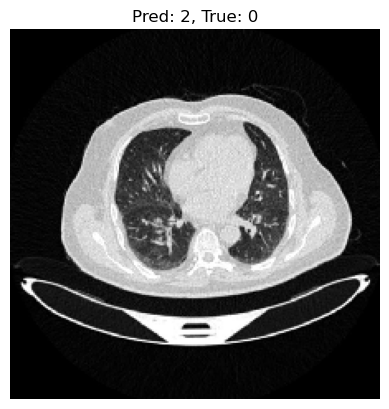

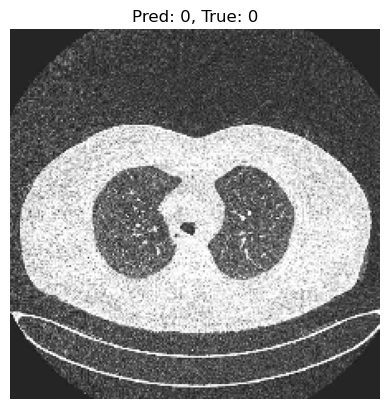

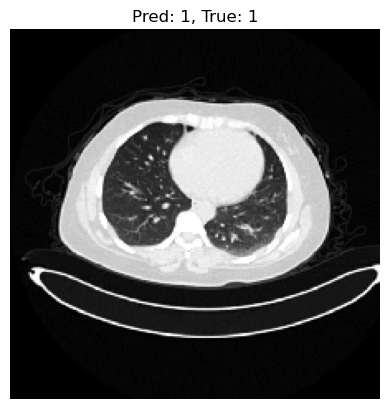

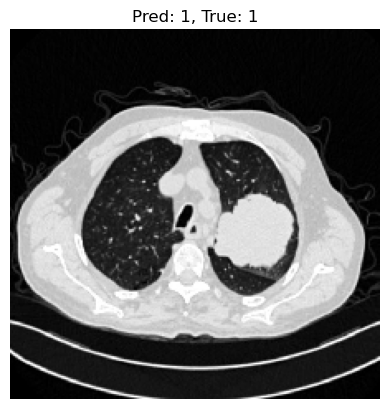

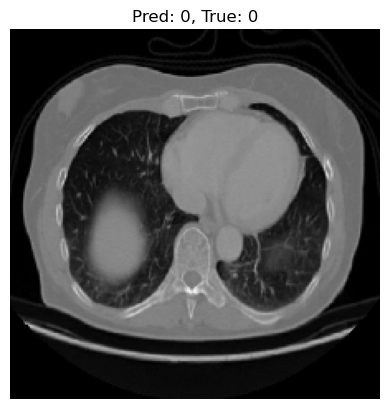

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener imágenes y etiquetas del generador
images, labels = next(val_generator)

# Hacer predicciones
predictions = vit_model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels, axis=1)

# Mostrar algunas imágenes con sus predicciones
for i in range(5):  # Muestra las primeras 5 imágenes
    plt.imshow(images[i])
    plt.title(f"Pred: {predicted_classes[i]}, True: {true_classes[i]}")
    plt.axis('off')
    plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 320ms/step
              precision    recall  f1-score   support

      Bengin       0.25      0.21      0.23        73
   Malignant       0.43      0.40      0.41       123
      Normal       0.32      0.40      0.36        93

    accuracy                           0.35       289
   macro avg       0.33      0.33      0.33       289
weighted avg       0.35      0.35      0.35       289



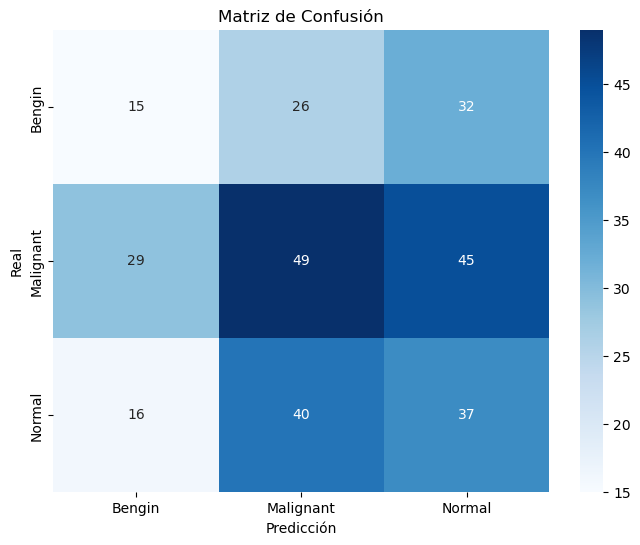

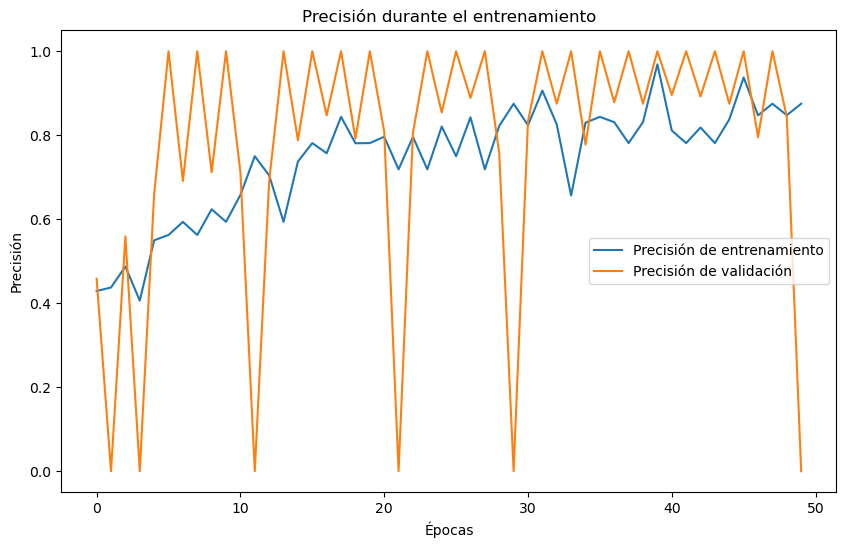

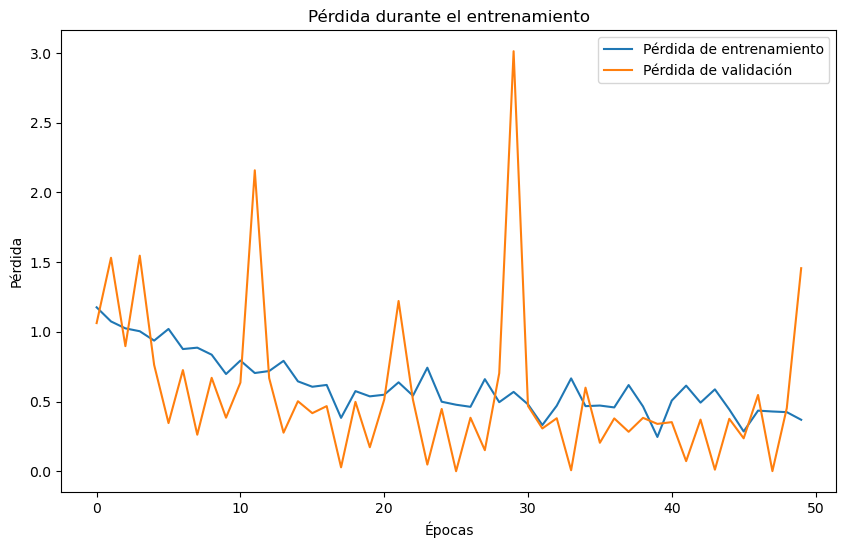

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Generar reporte de clasificación
val_generator.reset()
predictions = vit_model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes

# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=list(val_generator.class_indices.keys())))

# Matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Graficar precisión y pérdida durante el entrenamiento
# Asegúrate de tener el objeto `history` que contiene los registros de entrenamiento
# history.history es un diccionario que incluye 'accuracy', 'val_accuracy', 'loss', 'val_loss'

# Graficar precisión
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar pérdida
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [79]:
from sklearn.metrics import classification_report, confusion_matrix

# Obtener predicciones para todo el conjunto de validación
val_generator.reset()
predictions = vit_model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = val_generator.classes

# Generar reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=list(val_generator.class_indices.keys())))

# Generar matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Matriz de confusión:")
print(conf_matrix)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step
              precision    recall  f1-score   support

      Bengin       0.20      0.16      0.18        73
   Malignant       0.38      0.36      0.37       123
      Normal       0.31      0.38      0.34        93

    accuracy                           0.31       289
   macro avg       0.30      0.30      0.30       289
weighted avg       0.31      0.31      0.31       289

Matriz de confusión:
[[12 29 32]
 [32 44 47]
 [16 42 35]]


In [ ]:
espacio

Versión de TensorFlow: 2.16.1
Found 141 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


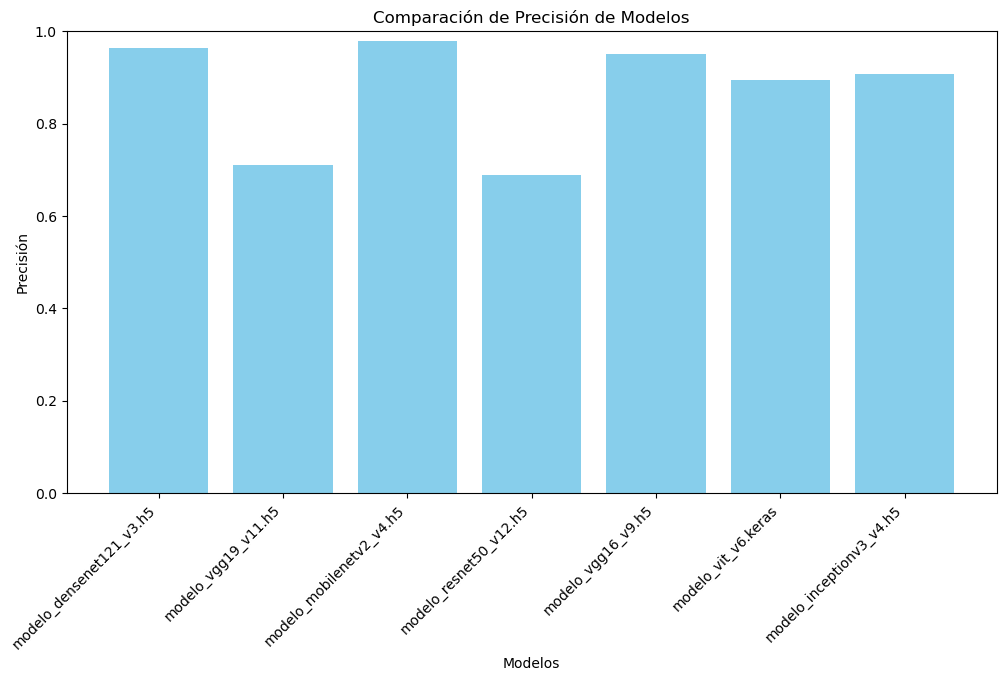

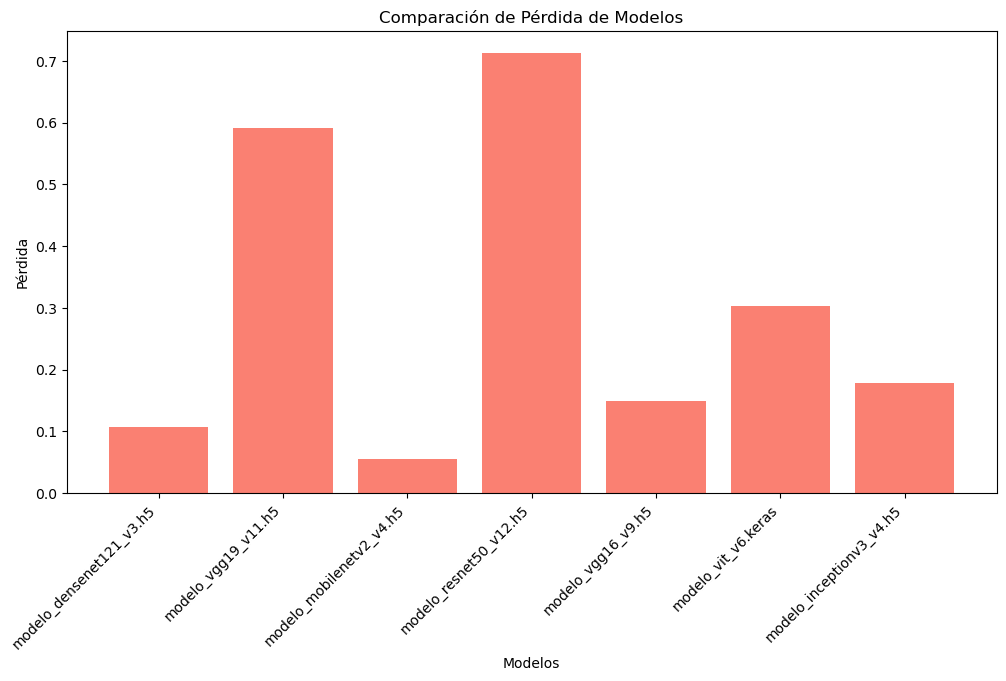

In [74]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Verificar la versión de TensorFlow
print(f"Versión de TensorFlow: {tf.__version__}")

# Registrar la clase personalizada
from tensorflow.keras.saving import register_keras_serializable

@register_keras_serializable()
class PatchExtractor(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtractor, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        patches = tf.image.extract_patches(
            images=inputs,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

# Configuración de los datos de prueba
test_dir = 'D:/UPN/Capstone/Modelos/Dataset/test'
batch_size = 32

# Diccionario de tamaños de entrada por modelo
input_sizes = {
    "default": (224, 224),  # Tamaño de entrada para ViT y otros modelos
    "inception": (299, 299)  # Tamaño de entrada para modelos Inception
}

# Lista de modelos para evaluar
modelos = [
    ('D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_densenet121_v3.h5', "default"),
    ('D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_vgg19_v11.h5', "default"),
    ('D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_mobilenetv2_v4.h5', "default"),
    ('D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_resnet50_v12.h5', "default"),
    ('D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_vgg16_v9.h5', "default"),
    ('D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_vit_v6.keras', "default"),  # Modelo ViT
    ('D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_inceptionv3_v4.h5', "inception")  # Modelo Inception
]

# Diccionario para capas personalizadas
custom_objects = {'PatchExtractor': PatchExtractor}

# Inicializar listas para almacenar resultados
precisiones = []
perdidas = []

# Evaluar los modelos
for modelo_path, modelo_tipo in modelos:
    try:
        # Ajustar el tamaño de entrada según el modelo
        input_size = input_sizes.get(modelo_tipo, input_sizes["default"])
        
        # Crear el generador de datos para este modelo
        datagen = ImageDataGenerator(rescale=1./255)
        test_generator = datagen.flow_from_directory(
            test_dir,
            target_size=input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
        
        # Cargar el modelo, asegurándose de que las clases personalizadas sean reconocidas
        if modelo_path.endswith('.keras'):
            modelo = load_model(modelo_path, custom_objects=custom_objects, compile=False)
        else:
            modelo = load_model(modelo_path, compile=False)
        
        # Compilar el modelo si es necesario
        modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Evaluar el modelo
        loss, accuracy = modelo.evaluate(test_generator, verbose=0)
        precisiones.append(accuracy)
        perdidas.append(loss)
    except Exception as e:
        print(f"Error al cargar o evaluar el modelo {modelo_path}: {e}")
        precisiones.append(np.nan)  # Agregar NaN en caso de error
        perdidas.append(np.nan)

# Recortar nombres de modelos para gráficos
modelos_recortados = [modelo.split('/')[-1] for modelo, _ in modelos]

# Crear gráfico de barras para precisiones
plt.figure(figsize=(12, 6))
plt.bar(modelos_recortados, precisiones, color='skyblue', label='Precisión')
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.title('Comparación de Precisión de Modelos')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.show()

# Crear gráfico de barras para pérdidas
plt.figure(figsize=(12, 6))
plt.bar(modelos_recortados, perdidas, color='salmon', label='Pérdida')
plt.xlabel('Modelos')
plt.ylabel('Pérdida')
plt.title('Comparación de Pérdida de Modelos')
plt.xticks(rotation=45, ha="right")
plt.show()


In [64]:
from tensorflow.keras.models import load_model

model_path = 'D:/UPN/Capstone/Modelos/ModelosSeleccionados/modelo_vit_v5.keras'

vit_model = load_model(
    model_path,
    custom_objects={'PatchExtractor': PatchExtractor},
    compile=False
)
print("Modelo cargado exitosamente.")


Modelo cargado exitosamente.


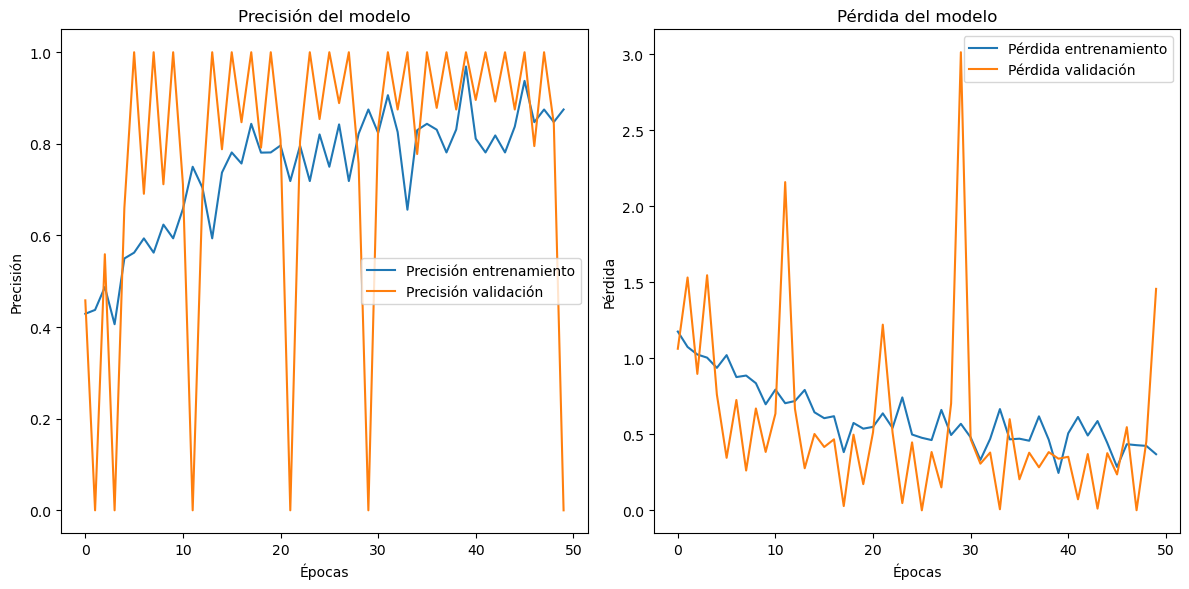

In [80]:
import matplotlib.pyplot as plt

# Suponiendo que `history` es el historial del entrenamiento del modelo
# Si ya tienes el historial, puedes cargarlo directamente o usar la variable `history`
# Ejemplo: history = model.fit(...)

# Graficar precisión
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Subgráfico para la precisión
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar pérdida
plt.subplot(1, 2, 2)  # Subgráfico para la pérdida
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()